# Running MOFA/MEFISTO on multiome RNA+ATAC from donor P13 (with matched annotations from RNA)

Invading EVT (VCT_CCC onwards) **and** VCT population (united VCT and VCT_p) - because we want to be able to project how well factors (and which ones) resolve VCT_CCC_vs_VCT comparison, so for that I need to run the model on data **including** a united VCT population just like it is accounted for in DE and DA comparisons and chromatic accessibility in TF analysis

02.2022

### This is a branch of analysis with binarised accessibility matrix in ATAC (worked better than denoised cisTopic values for me) that needs an additional step of TF-IDF normalisation and NO regression of technical covariates (rather ignoring the technical-driven factors post model training)


For details of this analysis if smth is unclear please feel free to contact Britta Velten (Stegle team) - I was discussing this analysis with her and she should be sufficiently aware of what's happening here

In [1]:
import mofapy2 # needs 'pip install mofapy2'
import muon as mu # needs 'pip install muon'
import mudata as md
import os
import scanpy as sc
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import anndata

In [2]:
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

In [3]:
%%bash

pip freeze

absl-py==0.12.0
aiohttp==3.7.4.post0
airr==1.3.1
alabaster==0.7.12
alembic @ file:///home/conda/feedstock_root/build_artifacts/alembic_1613901514078/work
anndata @ file:///home/conda/feedstock_root/build_artifacts/anndata_1605539061264/work
anndata2ri==1.0.6
annoy @ file:///home/conda/feedstock_root/build_artifacts/python-annoy_1610271511811/work
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1614388751160/work/dist
arboreto==0.1.6
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1610522574055/work
astunparse==1.6.3
async-generator==1.10
async-timeout==3.0.1
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1605083924122/work
Babel @ file:///home/conda/feedstock_root/build_artifacts/babel_1605182336601/work
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache==1.6.1
bbknn @ file:///opt/conda/conda-bld/bbknn_1616434096000/work
bleach @ file:///home/conda/feedstock_

## Data preparations

In [4]:
data_dir = "/lustre/scratch117/cellgen/team292/aa22/with_Stijn/202111_snATAC-seq_data_MFI/multiome_ATAC_samples_analysis/trophoblast_only_analysis/downstream_analysis_custom_clust/"
outdir = data_dir + "out_MOFA_analysis/"

In [5]:
# RNA for donor P13
path_rna_P13 = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202007_snRNA-seq_MFI/snRNA_seq_MFI_202007_adatas/202012_FINAL_reanalysis_with_souporcell_deconvolution_common_variants/donor_P13_all_samples_analysis_202110/'
RNA_file = path_rna_P13 + 'adata_raw_filtered.h5ad'
RNA_file_with_annot = path_rna_P13 + 'adata_P13_scVI_analysed_corr_by_sample_SN_and_multiome_trophoblast_v5_final.h5ad'

# ATAC, donor P13 multiome, inv trophoblast only
ATAC_file = "multiome_only_MFI_trophoblast_only_peak_calling_w_custom_clusters_ATAC.wCisTopic.h5ad"


In [6]:
# subset to interesting cell states
interesting_states = ['VCT_CCC', 'EVT_1', 'EVT_2', 'eEVT', 'iEVT', 'GC',
                     'VCT','VCT_p' # will be united into 'VCT'
                     ]

## Load data

In [7]:
# raw and filtered count values in .X, all genes
adata_rna = sc.read_h5ad(RNA_file)
adata_rna

AnnData object with n_obs × n_vars = 94014 × 29058
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7'

In [8]:
adata_rna_with_annot = sc.read_h5ad(RNA_file_with_annot)
adata_rna_with_annot

AnnData object with n_obs × n_vars = 37675 × 29058
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'barcode_sample_copy', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'annotation_prev', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'annotation_prev_or_removed', 'inv_troph_labels_initial', 'louvain_scvi_n_latent_8', 'final_annot_inv_troph', 'louvain_scvi_troph_rest', 'final_annot_all_troph', 'final_annot_inv_troph_corrected', 'final_annot_all_troph_corrected'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', '

In [9]:
# subset and transfer final annotations
adata_rna = adata_rna[adata_rna_with_annot.obs_names,:]

# transfer metadata
for col in adata_rna_with_annot.obs.columns:
    print(col)
    adata_rna.obs[col] = adata_rna_with_annot.obs.loc[adata_rna.obs_names, col]

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


n_genes
donor
tissue_block
age
sample
percent_mito
n_counts
dataset
technique
scrublet_score
scrublet_cluster_score
bh_pval
batch
is_doublet
barcode_sample_copy
barcode
souporcell_assignment
inter_ind_doublet
S_score
G2M_score
phase
annotation_prev
louvain
is_doublet_propagate
origin_M_F
annotation_prev_or_removed
inv_troph_labels_initial
louvain_scvi_n_latent_8
final_annot_inv_troph
louvain_scvi_troph_rest
final_annot_all_troph
final_annot_inv_troph_corrected
final_annot_all_troph_corrected


In [10]:
np.unique(adata_rna.obs['sample'])

array(['Pla_Camb10691970', 'Pla_Camb10691971',
       'Pla_Camb10714919_and_40110_Pla_Camb10687915',
       'Pla_Camb10714920_and_40110_Pla_Camb10687916', 'WSSS_PLA8764121',
       'WSSS_PLA8764122', 'WSSS_PLA8810750', 'WSSS_PLA8810751'],
      dtype=object)

In [11]:
adata_rna.obs['technology'] = ['10X_multiome' if sample in ['Pla_Camb10714919_and_40110_Pla_Camb10687915',
       'Pla_Camb10714920_and_40110_Pla_Camb10687916'] else '10X_snRNA-seq' for sample in adata_rna.obs['sample']]

In [12]:
list(adata_rna_with_annot.obs_names) == list(adata_rna.obs_names)

True

In [13]:
curr_embedding_key = 'X_umap_scVI_n_latent_8_sample'
adata_rna.obsm['X_umap_scVI_n_latent_8_sample'] = adata_rna_with_annot.obsm['X_umap_scVI_n_latent_8_sample']

In [14]:
# subset to cell states of interest
adata_rna.obs['celltype'] = adata_rna.obs['final_annot_all_troph_corrected']
adata_rna_sub = adata_rna[[g in interesting_states for g in adata_rna.obs['celltype']],] 
adata_rna_sub = adata_rna_sub[[g == "P13" for g in adata_rna_sub.obs['donor']],] 
# also alternative version of analysis: let's look only at multiome nuclei
adata_rna_sub = adata_rna_sub[adata_rna_sub.obs['technology'] == '10X_multiome']
adata_rna_sub

View of AnnData object with n_obs × n_vars = 1744 × 29058
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'barcode_sample_copy', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'annotation_prev', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'annotation_prev_or_removed', 'inv_troph_labels_initial', 'louvain_scvi_n_latent_8', 'final_annot_inv_troph', 'louvain_scvi_troph_rest', 'final_annot_all_troph', 'final_annot_inv_troph_corrected', 'final_annot_all_troph_corrected', 'technology', 'celltype'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5',

/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'technology' as categorical


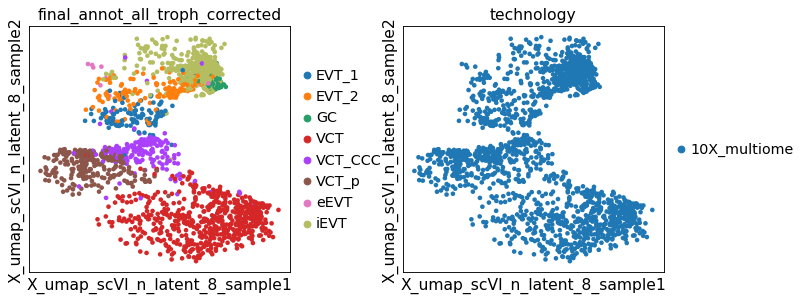

In [15]:
sc.pl.embedding(adata_rna_sub, curr_embedding_key, color = ['final_annot_all_troph_corrected', 'technology'], wspace=0.3)

In [16]:
# uniting VCT and VCT_p into VCT
adata_rna_sub.obs['celltype'] = ['VCT' if ct in ['VCT','VCT_p'] else ct for ct in adata_rna_sub.obs['celltype']]

... storing 'celltype' as categorical


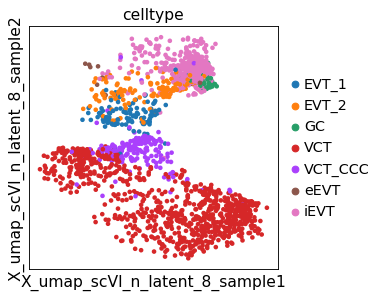

In [17]:
sc.pl.embedding(adata_rna_sub, curr_embedding_key, color = ['celltype'], wspace=0.3)

In [18]:
adata_atac = sc.read_h5ad(os.path.join(data_dir, ATAC_file))
adata_atac

AnnData object with n_obs × n_vars = 7449 × 42558
    obs: 'cellatac_code', 'sample', 'barcode', 'donor', 'annot_multiome_combined', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'age', 'tissue', 'technology'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'age_colors', 'annot_multiome_combined_colors', 'donor_colors', 'neighbors', 'sample_colors', 'technology_colors', 'tissue_colors', 'umap'
    obsm: 'X_cistopic_50', 'X_umap'
    varm: 'peak2gene'
    layers: 'binary_raw'
    obsp: 'connectivities', 'distances'

In [19]:
# subset to cell states of interest
adata_atac.obs['celltype'] = adata_atac.obs['annot_multiome_combined']
adata_atac_sub = adata_atac[[g in interesting_states for g in adata_atac.obs['celltype']],]
#adata_atac_sub = adata_atac_sub[[g == "P13" for g in adata_atac_sub.obs['donor']],] # use only cells from donor P13

# also alternative version of analysis: let's look only at multiome nuclei
adata_atac_sub = adata_atac_sub[adata_atac_sub.obs['technology'] == '10X_multiome']
adata_atac_sub

View of AnnData object with n_obs × n_vars = 2211 × 42558
    obs: 'cellatac_code', 'sample', 'barcode', 'donor', 'annot_multiome_combined', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'age', 'tissue', 'technology', 'celltype'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'age_colors', 'annot_multiome_combined_colors', 'donor_colors', 'neighbors', 'sample_colors', 'technology_colors', 'tissue_colors', 'umap'
    obsm: 'X_cistopic_50', 'X_umap'
    varm: 'peak2gene'
    layers: 'binary_raw'
    obsp: 'connectivities', 'distances'

In [20]:
adata_atac_sub.uns['donor_colors']

array(['#1f77b4', '#ff7f0e', '#279e68'], dtype=object)

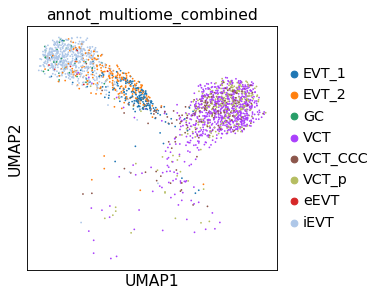

In [21]:
sc.pl.umap(adata_atac_sub, color = ['annot_multiome_combined'], 
           #palette = ['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b']
           size=10
          )

In [22]:
# uniting VCT and VCT_p into VCT
adata_atac_sub.obs['celltype'] = ['VCT' if ct in ['VCT','VCT_p'] else ct for ct in adata_atac_sub.obs['celltype']]

Trying to set attribute `.obs` of view, copying.


... storing 'celltype' as categorical


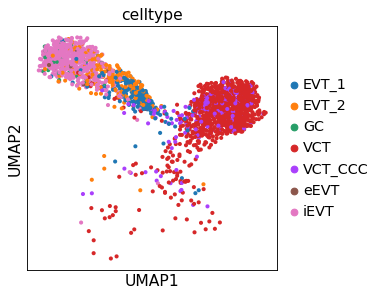

In [23]:
sc.pl.umap(adata_atac_sub, color = ['celltype'], ncols = 3, 
           color_map = 'OrRd',
           wspace = 0.4
          )

In [24]:
adata_rna_sub.obs['celltype'].value_counts()

VCT        855
iEVT       422
VCT_CCC    170
EVT_2      133
EVT_1      119
GC          36
eEVT         9
Name: celltype, dtype: int64

In [25]:
adata_rna_sub.obs['donor'].value_counts()

P13    1744
Name: donor, dtype: int64

In [26]:
adata_atac_sub.obs['celltype'].value_counts()

VCT        1029
iEVT        544
EVT_2       213
EVT_1       197
VCT_CCC     190
GC           29
eEVT          9
Name: celltype, dtype: int64

In [27]:
adata_atac_sub.obs['donor'].value_counts()

P13      1911
P14       167
Hrv43     133
Name: donor, dtype: int64

In [28]:
adata_atac_sub.obs.index = [adata_atac_sub.obs.loc[idx, 'barcode'][3:] + '_' + adata_atac_sub.obs.loc[idx, 'sample'] for idx in adata_atac_sub.obs_names]

In [29]:
# additional - subsetting to barcodes that have both RNA and ATAC here - this will only be donor P13 data, but can add other donors too later..
common_barcodes = list(set(adata_atac_sub.obs_names) & set(adata_rna_sub.obs_names))
len(common_barcodes)

1605

In [30]:
adata_rna_sub = adata_rna_sub[common_barcodes,:]
adata_rna_sub.obs['donor'].value_counts()

P13    1605
Name: donor, dtype: int64

In [31]:
adata_rna_sub.obs['celltype'].value_counts()

VCT        776
iEVT       401
VCT_CCC    154
EVT_2      130
EVT_1      106
GC          29
eEVT         9
Name: celltype, dtype: int64

In [32]:
adata_atac_sub = adata_atac_sub[common_barcodes,:]
adata_atac_sub.obs['donor'].value_counts()

P13    1605
Name: donor, dtype: int64

In [33]:
adata_atac_sub.obs['celltype'].value_counts()

VCT        776
iEVT       401
VCT_CCC    154
EVT_2      130
EVT_1      106
GC          29
eEVT         9
Name: celltype, dtype: int64

In [34]:
adata_rna_sub.obs['celltype'].value_counts()

VCT        776
iEVT       401
VCT_CCC    154
EVT_2      130
EVT_1      106
GC          29
eEVT         9
Name: celltype, dtype: int64

In [35]:
adata_atac_sub.obs['barcode_sample_rna_like'] = [barcode[3:] + '_' + sample for barcode,sample in zip(adata_atac_sub.obs['barcode'],
                                                                                                     adata_atac_sub.obs['sample'])]

Trying to set attribute `.obs` of view, copying.


In [36]:
# important: for obs_names to match
adata_atac_sub.obs.set_index('barcode_sample_rna_like', inplace=True)

In [37]:
adata_atac_sub.obs

cellatac_code  \
barcode_sample_rna_like                                            
ACGTCAAGTCCGCTGT-1_Pla_Camb10714919_and_40110_P...            10   
CTCACACTCTGCAACG-1_Pla_Camb10714919_and_40110_P...            10   
AGTGCACGTGTTTGCT-1_Pla_Camb10714920_and_40110_P...            11   
CTTGTAAAGTAATCCA-1_Pla_Camb10714920_and_40110_P...            11   
ACTAATCCATAAGGAC-1_Pla_Camb10714919_and_40110_P...            10   
...                                                          ...   
CCATAATCACTTACAG-1_Pla_Camb10714919_and_40110_P...            10   
GTGCTTACACCTCAGG-1_Pla_Camb10714919_and_40110_P...            10   
GGTGTTGTCCTTGTTG-1_Pla_Camb10714920_and_40110_P...            11   
TAGCCTCTCAGCCAAT-1_Pla_Camb10714920_and_40110_P...            11   
AAAGGAGCATCTAGCA-1_Pla_Camb10714920_and_40110_P...            11   

                                                                                         sample  \
barcode_sample_rna_like                                                                           
ACGTCAAGTCCGCTGT-1_Pla_Camb10714919_and_40110_P...  Pla_Camb10714919_and_40110_Pla_Camb10687915   
CTCACACTCTGCAACG-1_Pla_Camb10714919_and_40110_P...  Pla_Camb10714919_and_40110_Pla_Camb10687915   
AGTGCACGTGTTTGCT-1_Pla_Camb10714920_and_40110_P...  Pla_Camb10714920_and_40110_Pla_Camb10687916   
CTTGTAAAGTAATCCA-1_Pla_Camb10714920_and_40110_P...  Pla_Camb10714920_and_40110_Pla_Camb10687916   
ACTAATCCATAAGGAC-1_Pla_Camb10714919_and_40110_P...  Pla_Camb10714919_and_40110_Pla_Camb10687915   
...                                                                                         ...   
CCATAATCACTTACAG-1_Pla_Camb10714919_and_40110_P...  Pla_Camb10714919_and_40110_Pla_Camb10687915   
GTGCTTACACCTCAGG-1_Pla_Camb10714919_and_40110_P...  Pla_Camb10714919_and_40110_Pla_Camb10687915   
GGTGTTGTCCTTGTTG-1_Pla_Camb10714920_and_40110_P...  Pla_Camb10714920_and_40110_Pla_Camb10687916   
TAGCCTCTCAGCCAAT-1_Pla_Camb10714920_and_40110_P...  Pla_Camb10714920_and_40110_Pla_Camb10687916   
AAAGGAGCATCTAGCA-1_Pla_Camb10714920_and_40110_P...  Pla_Camb10714920_and_40110_Pla_Camb10687916   

                                                                  barcode  \
barcode_sample_rna_like                                                     
ACGTCAAGTCCGCTGT-1_Pla_Camb10714919_and_40110_P...  10-ACGTCAAGTCCGCTGT-1   
CTCACACTCTGCAACG-1_Pla_Camb10714919_and_40110_P...  10-CTCACACTCTGCAACG-1   
AGTGCACGTGTTTGCT-1_Pla_Camb10714920_and_40110_P...  11-AGTGCACGTGTTTGCT-1   
CTTGTAAAGTAATCCA-1_Pla_Camb10714920_and_40110_P...  11-CTTGTAAAGTAATCCA-1   
ACTAATCCATAAGGAC-1_Pla_Camb10714919_and_40110_P...  10-ACTAATCCATAAGGAC-1   
...                                                                   ...   
CCATAATCACTTACAG-1_Pla_Camb10714919_and_40110_P...  10-CCATAATCACTTACAG-1   
GTGCTTACACCTCAGG-1_Pla_Camb10714919_and_40110_P...  10-GTGCTTACACCTCAGG-1   
GGTGTTGTCCTTGTTG-1_Pla_Camb10714920_and_40110_P...  11-GGTGTTGTCCTTGTTG-1   
TAGCCTCTCAGCCAAT-1_Pla_Camb10714920_and_40110_P...  11-TAGCCTCTCAGCCAAT-1   
AAAGGAGCATCTAGCA-1_Pla_Camb10714920_and_40110_P...  11-AAAGGAGCATCTAGCA-1   

                                                   donor  \
barcode_sample_rna_like                                    
ACGTCAAGTCCGCTGT-1_Pla_Camb10714919_and_40110_P...   P13   
CTCACACTCTGCAACG-1_Pla_Camb10714919_and_40110_P...   P13   
AGTGCACGTGTTTGCT-1_Pla_Camb10714920_and_40110_P...   P13   
CTTGTAAAGTAATCCA-1_Pla_Camb10714920_and_40110_P...   P13   
ACTAATCCATAAGGAC-1_Pla_Camb10714919_and_40110_P...   P13   
...                                                  ...   
CCATAATCACTTACAG-1_Pla_Camb10714919_and_40110_P...   P13   
GTGCTTACACCTCAGG-1_Pla_Camb10714919_and_40110_P...   P13   
GGTGTTGTCCTTGTTG-1_Pla_Camb10714920_and_40110_P...   P13   
TAGCCTCTCAGCCAAT-1_Pla_Camb10714920_and_40110_P...   P13   
AAAGGAGCATCTAGCA-1_Pla_Camb10714920_and_40110_P...   P13   

                                                   annot_multiome_combined  \
barcode_sample_rn

In [38]:
# annotations in rna and atac match? -> yes, moving on
list(adata_atac_sub.obs.loc[adata_rna_sub.obs_names,'celltype']) == list(adata_rna_sub.obs['celltype'])

True

In [39]:
adata_atac_sub.obs['celltype'].value_counts()

VCT        776
iEVT       401
VCT_CCC    154
EVT_2      130
EVT_1      106
GC          29
eEVT         9
Name: celltype, dtype: int64

In [40]:
adata_atac_sub

AnnData object with n_obs × n_vars = 1605 × 42558
    obs: 'cellatac_code', 'sample', 'barcode', 'donor', 'annot_multiome_combined', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'age', 'tissue', 'technology', 'celltype'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'age_colors', 'annot_multiome_combined_colors', 'donor_colors', 'neighbors', 'sample_colors', 'technology_colors', 'tissue_colors', 'umap', 'celltype_colors'
    obsm: 'X_cistopic_50', 'X_umap'
    varm: 'peak2gene'
    layers: 'binary_raw'
    obsp: 'connectivities', 'distances'

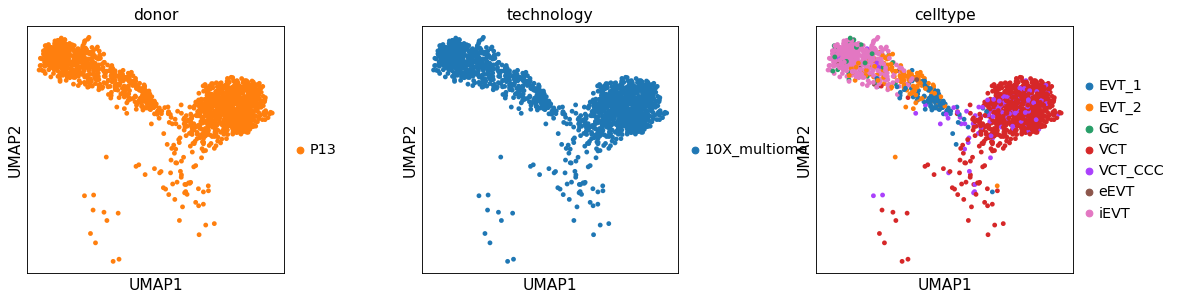

In [41]:
sc.pl.umap(adata_atac_sub, color = ['donor', 'technology','celltype'], ncols = 3, 
           color_map = 'OrRd',
           wspace = 0.4
          )

# No longer used: subsetting ATAC data into different views according to (a) annotation of the peaks (done in M0 notebook) and (b) assignment of peaks to enhancer regions (done separately using data from Zhang et al. and project FANTOM5)

And additionally looking at peaks containing H3K36me3 mark to see active promoters and gene bodies to judge how well the epigenetic data from 2nd trim CTB (Zhang et al) represents GEX here) and H3K9me3 (should be in repressed promoters so expecting lower expression)

In [42]:
# read in bed files with peaks overlapping certain enhancer regions
peaks_enhancer_overlaps_path = '/lustre/scratch117/cellgen/team292/aa22/with_Stijn/202111_snATAC-seq_data_MFI/multiome_ATAC_samples_analysis/trophoblast_only_analysis/downstream_analysis_custom_clust/enhancer_related/union_final2use/2nd_trimester/'

peaks_enhancers = {}

peaks_enhancers['primed'] = pd.read_csv(peaks_enhancer_overlaps_path + 'peaks_containing_primed_enhancer_regions.csv', sep='\t', header=None)
peaks_enhancers['active'] = pd.read_csv(peaks_enhancer_overlaps_path + 'peaks_containing_active_enhancer_regions.csv', sep='\t', header=None)
peaks_enhancers['repressed'] = pd.read_csv(peaks_enhancer_overlaps_path + 'peaks_containing_repressed_enhancer_regions.csv', sep='\t', header=None)
#peaks_enhancers['FANTOM5'] = pd.read_csv(peaks_enhancer_overlaps_path + 'peaks_containing_FANTOM5_enhancer_regions.csv', sep='\t', header=None)

for key in list(peaks_enhancers.keys()):
    print(key)
    peaks_enhancers[key]['peak_id'] = [peaks_enhancers[key].loc[idx,0] + ':' + str(peaks_enhancers[key].loc[idx,1]) + '-' + str(peaks_enhancers[key].loc[idx,2]) for idx in peaks_enhancers[key].index]
    peaks_enhancers[key].set_index('peak_id', inplace=True)
    
    # overlap with features of adata_atac_sub
    print('number of peaks overlapping with', key, 'enhancers:', len(peaks_enhancers[key]))
    print('of those in adata_atac_sub:', len(set(peaks_enhancers[key].index) & set(adata_atac_sub.var.index)))
    print('\n')



primed
number of peaks overlapping with primed enhancers: 35134
of those in adata_atac_sub: 10838


active
number of peaks overlapping with active enhancers: 45865
of those in adata_atac_sub: 21165


repressed
number of peaks overlapping with repressed enhancers: 39814
of those in adata_atac_sub: 11143




In [43]:
peaks_enhancers['primed']

0          1          2
peak_id                                             
chr1:779609-779967        chr1     779609     779967
chr1:845586-845942        chr1     845586     845942
chr1:851477-852159        chr1     851477     852159
chr1:869573-870018        chr1     869573     870018
chr1:966847-967127        chr1     966847     967127
...                        ...        ...        ...
chrX:153922077-153922418  chrX  153922077  153922418
chrX:153927861-153928690  chrX  153927861  153928690
chrX:154785520-154785997  chrX  154785520  154785997
chrX:154980854-154981132  chrX  154980854  154981132
chrX:155394839-155395249  chrX  155394839  155395249

[35134 rows x 3 columns]

_______

In [44]:
adata_atac_sub.var = pd.read_csv('./20220209_var_table.csv', index_col=0)

In [45]:
adata_atac_sub.var['contains_primed_enhancers'].value_counts()

0    31720
1    10838
Name: contains_primed_enhancers, dtype: int64

In [46]:
adata_atac_sub.var['contains_active_enhancers'].value_counts()

0    21393
1    21165
Name: contains_active_enhancers, dtype: int64

In [47]:
adata_atac_sub.var['contains_repressed_enhancers'].value_counts()

0    31415
1    11143
Name: contains_repressed_enhancers, dtype: int64

In [48]:
#adata_atac_sub.var['contains_FANTOM5_enhancers'].value_counts()

In [49]:
# any peaks containing multiple types of enhancers? will not restrict for now..
len(adata_atac_sub.var[(adata_atac_sub.var['contains_primed_enhancers'] == 1)
                  & (adata_atac_sub.var['contains_active_enhancers'] == 1)])

5245

In [50]:
# any peaks containing multiple types of enhancers? will not restrict for now..
len(adata_atac_sub.var[(adata_atac_sub.var['contains_primed_enhancers'] == 1)
                  & (adata_atac_sub.var['contains_repressed_enhancers'] == 1)])

7337

In [51]:
# any peaks containing multiple types of enhancers? will not restrict for now..
len(adata_atac_sub.var[(adata_atac_sub.var['contains_active_enhancers'] == 1)
                  & (adata_atac_sub.var['contains_repressed_enhancers'] == 1)])

4289

In [52]:
# any peaks containing multiple types of enhancers? will not restrict for now..
len(adata_atac_sub.var[(adata_atac_sub.var['contains_primed_enhancers'] == 1)
    & (adata_atac_sub.var['contains_active_enhancers'] == 1)
                  & (adata_atac_sub.var['contains_repressed_enhancers'] == 1)])

2984

In [53]:
# any peaks containing no types of enhancers?
len(adata_atac_sub.var[(adata_atac_sub.var['contains_primed_enhancers'] == 0)
    & (adata_atac_sub.var['contains_active_enhancers'] == 0)
                  & (adata_atac_sub.var['contains_repressed_enhancers'] == 0)])

13299

In [54]:
adata_atac_sub_views = {}

adata_atac_sub_views['ATAC_all'] = adata_atac_sub

adata_atac_sub_views['ATAC_primed_enhancers'] = adata_atac_sub[:,(adata_atac_sub.var['contains_primed_enhancers'] == 1)
                                                              & (adata_atac_sub.var['contains_active_enhancers'] == 0)
                                                              & (adata_atac_sub.var['contains_repressed_enhancers'] == 0)
                                                              #& (adata_atac_sub.var['contains_FANTOM5_enhancers'] == 0)
                                                              ]
adata_atac_sub_views['ATAC_active_enhancers'] = adata_atac_sub[:,(adata_atac_sub.var['contains_active_enhancers'] == 1)
                                                              & (adata_atac_sub.var['contains_primed_enhancers'] == 0)
                                                              & (adata_atac_sub.var['contains_repressed_enhancers'] == 0)
                                                              #& (adata_atac_sub.var['contains_FANTOM5_enhancers'] == 0)
                                                              ]
adata_atac_sub_views['ATAC_repressed_enhancers'] = adata_atac_sub[:,(adata_atac_sub.var['contains_repressed_enhancers'] == 1)
                                                                 & (adata_atac_sub.var['contains_active_enhancers'] == 0)
                                                              & (adata_atac_sub.var['contains_primed_enhancers'] == 0)
                                                                 #& (adata_atac_sub.var['contains_FANTOM5_enhancers'] == 0)
                                                                 ]
#adata_atac_sub_views['ATAC_FANTOM5_enhancers'] = adata_atac_sub[:,(adata_atac_sub.var['contains_repressed_enhancers'] == 0)
#                                                                 & (adata_atac_sub.var['contains_active_enhancers'] == 0)
#                                                              & (adata_atac_sub.var['contains_primed_enhancers'] == 0)
#                                                                 & (adata_atac_sub.var['contains_FANTOM5_enhancers'] == 1)]


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [55]:
adata_atac_sub_views['ATAC_all']

AnnData object with n_obs × n_vars = 1605 × 42558
    obs: 'cellatac_code', 'sample', 'barcode', 'donor', 'annot_multiome_combined', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'age', 'tissue', 'technology', 'celltype'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'contains_primed_enhancers', 'contains_active_enhancers', 'contains_repressed_enhancers'
    uns: 'age_colors', 'annot_multiome_combined_colors', 'donor_colors', 'neighbors', 'sample_colors', 'technology_colors', 'tissue_colors', 'umap', 'celltype_colors'
    obsm: 'X_cistopic_50', 'X_umap'
    varm: 'peak2gene'
    layers: 'binary_raw'
    obsp: 'connectivities', 'dis

In [56]:
adata_atac_sub_views['ATAC_primed_enhancers'].X.shape[1]

1240

In [57]:
adata_atac_sub_views['ATAC_active_enhancers'].X.shape[1]

14615

In [58]:
adata_atac_sub_views['ATAC_repressed_enhancers'].X.shape[1]

2501

In [60]:
adata_atac_sub_views.keys()

dict_keys(['ATAC_all', 'ATAC_primed_enhancers', 'ATAC_active_enhancers', 'ATAC_repressed_enhancers'])

In [61]:
adata_atac_sub.var

peak_width  exon  gene  promoter  annotation  \
peak_id                                                                  
chr1:904345-904907               563     0     0         0  intergenic   
chr1:938156-938411               256     0     1         1    promoter   
chr1:959000-959712               713     1     1         1        exon   
chr1:966208-966555               348     1     1         1        exon   
chr1:966847-967127               281     0     1         0      intron   
...                              ...   ...   ...       ...         ...   
chrX:154805785-154806070         286     0     1         1    promoter   
chrX:155026470-155027451         982     1     1         1        exon   
chrX:155070780-155071828        1049     1     1         1        exon   
chrX:155215852-155216966        1115     1     1         1        exon   
chrX:155880939-155881650         712     1     1         1        exon   

                         gene_name          gene_id  tss_distance  \
peak_id                                                             
chr1:904345-904907             NaN              NaN         19020   
chr1:938156-938411          SAMD11  ENSG00000187634           863   
chr1:959000-959712          KLHL17  ENSG00000187961             0   
chr1:966208-966555         PLEKHN1  ENSG00000187583             0   
chr1:966847-967127         PLEKHN1  ENSG00000187583           344   
...                            ...              ...           ...   
chrX:154805785-154806070      MPP1  ENSG00000130830           257   
chrX:155026470-155027451    FUNDC2  ENSG00000165775             0   
chrX:155070780-155071828     BRCC3  ENSG00000185515             0   
chrX:155215852-155216966      VBP1  ENSG00000155959             0   
chrX:155880939-155881650     VAMP7  ENSG00000124333             0   

                          ENCODE_blacklist  n_cells_by_counts  mean_counts  \
peak_id                                                                      
chr1:904345-904907                       0                147     0.019650   
chr1:938156-938411                       0                 50     0.006684   
chr1:959000-959712                       0                273     0.036492   
chr1:966208-966555                       0                 97     0.012966   
chr1:966847-967127                       0                104     0.013902   
...                                    ...                ...          ...   
chrX:154805785-154806070                 0                120     0.016041   
chrX:155026470-155027451                 0                431     0.057613   
chrX:155070780-155071828                 0                483     0.064564   
chrX:155215852-155216966                 0                203     0.027135   
chrX:155880939-155881650                 0                214     0.028606   

                          log1p_mean_counts  pct_dropout_by_counts  \
peak_id                                                              
chr1:904345-904907                 0.019459              98.035022   
chr1:938156-938411                 0.006661              99.331640   
chr1:959000-959712                 0.035842              96.350755   
chr1:966208-966555                 0.012883              98.703382   
chr1:966847-967127                 0.013806              98.609812   
...                                     ...                    ...   
chrX:154805785-154806070           0.015913              98.395936   
chrX:155026470-155027451           0.056014              94.238738   
chrX:155070780-155071828           0.062565              93.543644   
chrX:155215852-155216966           0.026774              97.286459   
chrX:155880939-155881650           0.028204              97.139420   

                          total_counts  log1p_total_counts  \
peak_id                                                      
chr1:904345-904907               147.0            4.997212   
chr1:938156-938411                50.0            3.9

In [62]:
adata_atac_sub.var['annotation'].value_counts()

intergenic    14832
exon          13140
intron        12496
promoter       2090
Name: annotation, dtype: int64

In [63]:
adata_atac_sub

AnnData object with n_obs × n_vars = 1605 × 42558
    obs: 'cellatac_code', 'sample', 'barcode', 'donor', 'annot_multiome_combined', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'age', 'tissue', 'technology', 'celltype'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'contains_primed_enhancers', 'contains_active_enhancers', 'contains_repressed_enhancers'
    uns: 'age_colors', 'annot_multiome_combined_colors', 'donor_colors', 'neighbors', 'sample_colors', 'technology_colors', 'tissue_colors', 'umap', 'celltype_colors'
    obsm: 'X_cistopic_50', 'X_umap'
    varm: 'peak2gene'
    layers: 'binary_raw'
    obsp: 'connectivities', 'dis

In [64]:
for annotation in np.unique(adata_atac_sub.var['annotation']):
    print(annotation)
    adata_atac_sub_views['ATAC_' + annotation] = adata_atac_sub[:,(adata_atac_sub.var['annotation'] == annotation)
                                                               & (adata_atac_sub.var['contains_primed_enhancers'] == 0)
                                                                & (adata_atac_sub.var['contains_active_enhancers'] == 0)
                                                                & (adata_atac_sub.var['contains_repressed_enhancers'] == 0)
                                                                #& (adata_atac_sub.var['contains_FANTOM5_enhancers'] == 0)
                                                               ].copy()
    
    

exon
intergenic
intron
promoter


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **

In [65]:
adata_atac_sub_views['ATAC_active_enhancers']

View of AnnData object with n_obs × n_vars = 1605 × 14615
    obs: 'cellatac_code', 'sample', 'barcode', 'donor', 'annot_multiome_combined', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'age', 'tissue', 'technology', 'celltype'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'contains_primed_enhancers', 'contains_active_enhancers', 'contains_repressed_enhancers'
    uns: 'age_colors', 'annot_multiome_combined_colors', 'donor_colors', 'neighbors', 'sample_colors', 'technology_colors', 'tissue_colors', 'umap', 'celltype_colors'
    obsm: 'X_cistopic_50', 'X_umap'
    varm: 'peak2gene'
    layers: 'binary_raw'
    obsp: 'connectivitie

In [66]:
adata_atac_sub_views.keys()

dict_keys(['ATAC_all', 'ATAC_primed_enhancers', 'ATAC_active_enhancers', 'ATAC_repressed_enhancers', 'ATAC_exon', 'ATAC_intergenic', 'ATAC_intron', 'ATAC_promoter'])

In [67]:
adata_atac_sub.var

peak_width  exon  gene  promoter  annotation  \
peak_id                                                                  
chr1:904345-904907               563     0     0         0  intergenic   
chr1:938156-938411               256     0     1         1    promoter   
chr1:959000-959712               713     1     1         1        exon   
chr1:966208-966555               348     1     1         1        exon   
chr1:966847-967127               281     0     1         0      intron   
...                              ...   ...   ...       ...         ...   
chrX:154805785-154806070         286     0     1         1    promoter   
chrX:155026470-155027451         982     1     1         1        exon   
chrX:155070780-155071828        1049     1     1         1        exon   
chrX:155215852-155216966        1115     1     1         1        exon   
chrX:155880939-155881650         712     1     1         1        exon   

                         gene_name          gene_id  tss_distance  \
peak_id                                                             
chr1:904345-904907             NaN              NaN         19020   
chr1:938156-938411          SAMD11  ENSG00000187634           863   
chr1:959000-959712          KLHL17  ENSG00000187961             0   
chr1:966208-966555         PLEKHN1  ENSG00000187583             0   
chr1:966847-967127         PLEKHN1  ENSG00000187583           344   
...                            ...              ...           ...   
chrX:154805785-154806070      MPP1  ENSG00000130830           257   
chrX:155026470-155027451    FUNDC2  ENSG00000165775             0   
chrX:155070780-155071828     BRCC3  ENSG00000185515             0   
chrX:155215852-155216966      VBP1  ENSG00000155959             0   
chrX:155880939-155881650     VAMP7  ENSG00000124333             0   

                          ENCODE_blacklist  n_cells_by_counts  mean_counts  \
peak_id                                                                      
chr1:904345-904907                       0                147     0.019650   
chr1:938156-938411                       0                 50     0.006684   
chr1:959000-959712                       0                273     0.036492   
chr1:966208-966555                       0                 97     0.012966   
chr1:966847-967127                       0                104     0.013902   
...                                    ...                ...          ...   
chrX:154805785-154806070                 0                120     0.016041   
chrX:155026470-155027451                 0                431     0.057613   
chrX:155070780-155071828                 0                483     0.064564   
chrX:155215852-155216966                 0                203     0.027135   
chrX:155880939-155881650                 0                214     0.028606   

                          log1p_mean_counts  pct_dropout_by_counts  \
peak_id                                                              
chr1:904345-904907                 0.019459              98.035022   
chr1:938156-938411                 0.006661              99.331640   
chr1:959000-959712                 0.035842              96.350755   
chr1:966208-966555                 0.012883              98.703382   
chr1:966847-967127                 0.013806              98.609812   
...                                     ...                    ...   
chrX:154805785-154806070           0.015913              98.395936   
chrX:155026470-155027451           0.056014              94.238738   
chrX:155070780-155071828           0.062565              93.543644   
chrX:155215852-155216966           0.026774              97.286459   
chrX:155880939-155881650           0.028204              97.139420   

                          total_counts  log1p_total_counts  \
peak_id                                                      
chr1:904345-904907               147.0            4.997212   
chr1:938156-938411                50.0            3.9

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='peak_width', ylabel='Density'>

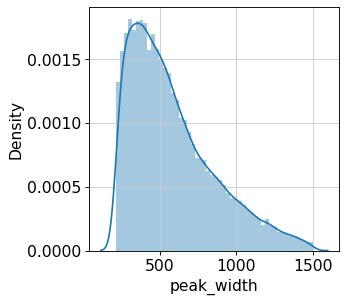

In [68]:
sns.distplot(adata_atac_sub.var['peak_width'])

In [69]:
mdata = mu.MuData({'RNA': adata_rna_sub, 
                   'ATAC_all': adata_atac_sub, # 20220209 - trying with all ATAC in a view
                   
                   #'ATAC_exon': adata_atac_sub_views['ATAC_exon'],
                   #'ATAC_intergenic': adata_atac_sub_views['ATAC_intergenic'],
                   #'ATAC_intron': adata_atac_sub_views['ATAC_intron'],
                   #'ATAC_promoter': adata_atac_sub_views['ATAC_promoter'],
                   
                   #'ATAC_primed_enhancers': adata_atac_sub_views['ATAC_primed_enhancers'], 
                   #'ATAC_active_enhancers': adata_atac_sub_views['ATAC_active_enhancers'],
                   #'ATAC_repressed_enhancers': adata_atac_sub_views['ATAC_repressed_enhancers'],
                   
                   
                   ### not using any more for now
                   
                   #'ATAC_FANTOM5_enhancers': adata_atac_sub_views['ATAC_FANTOM5_enhancers'],
                   
                   #'ATAC_primed_and_active_enhancers': adata_atac_sub_views['ATAC_primed_and_active_enhancers'], 
                   #'ATAC_primed_and_repressed_enhancers': adata_atac_sub_views['ATAC_primed_and_repressed_enhancers'],
                   #'ATAC_active_and_repressed_enhancers': adata_atac_sub_views['ATAC_active_and_repressed_enhancers'],
                   #'ATAC_all_3_enhancers': adata_atac_sub_views['ATAC_all_3_enhancers'],
                   
                  })
mdata

MuData object with n_obs × n_vars = 1605 × 71616
  2 modalities
    RNA:	1605 x 29058
      obs:	'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'barcode_sample_copy', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'annotation_prev', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'annotation_prev_or_removed', 'inv_troph_labels_initial', 'louvain_scvi_n_latent_8', 'final_annot_inv_troph', 'louvain_scvi_troph_rest', 'final_annot_all_troph', 'final_annot_inv_troph_corrected', 'final_annot_all_troph_corrected', 'technology', 'celltype'
      var:	'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7'
      uns:	'final_annot_all_troph_corrected_colors', 'technology_colors', 'celltype_colors'
      obsm:	'X_umap_scVI_n_latent_8_sample'
    ATAC_all:	1605 x 42558
      obs:	'cellatac_code', 'sample', 'barcode', 'donor', 'annot_multiome_combined', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'age', 'tissue', 'technology', 'celltype'
      var:	'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'contains_primed_enhancers', 'contains_active_enhancers', 'contains_repressed_enhancers'
      uns:	'age_colors', 'annot_multiome_combined_colors', 'donor_colors', 'neighbors', 'sample_colors', 'technology_colors', 'tissue_colors', 'umap', 'celltype_colors'
      obsm:	'X_cistopic_50', 'X_umap'
      varm:	'peak2gene'
      layers:	'binary_raw'
      obsp:	'connectivities', 'distances'

In [70]:
mdata.obs

RNA:n_genes RNA:donor  \
ACGTCAAGTCCGCTGT-1_Pla_Camb10714919_and_40110_P...         2324       P13   
CTCACACTCTGCAACG-1_Pla_Camb10714919_and_40110_P...         3669       P13   
AGTGCACGTGTTTGCT-1_Pla_Camb10714920_and_40110_P...         3991       P13   
CTTGTAAAGTAATCCA-1_Pla_Camb10714920_and_40110_P...         5466       P13   
ACTAATCCATAAGGAC-1_Pla_Camb10714919_and_40110_P...         5006       P13   
...                                                         ...       ...   
CCATAATCACTTACAG-1_Pla_Camb10714919_and_40110_P...         2453       P13   
GTGCTTACACCTCAGG-1_Pla_Camb10714919_and_40110_P...         5380       P13   
GGTGTTGTCCTTGTTG-1_Pla_Camb10714920_and_40110_P...         4787       P13   
TAGCCTCTCAGCCAAT-1_Pla_Camb10714920_and_40110_P...         4607       P13   
AAAGGAGCATCTAGCA-1_Pla_Camb10714920_and_40110_P...         4371       P13   

                                                   RNA:tissue_block  RNA:age  \
ACGTCAAGTCCGCTGT-1_Pla_Camb10714919_and_40110_P...          unknown  8-9_PCW   
CTCACACTCTGCAACG-1_Pla_Camb10714919_and_40110_P...          unknown  8-9_PCW   
AGTGCACGTGTTTGCT-1_Pla_Camb10714920_and_40110_P...          unknown  8-9_PCW   
CTTGTAAAGTAATCCA-1_Pla_Camb10714920_and_40110_P...          unknown  8-9_PCW   
ACTAATCCATAAGGAC-1_Pla_Camb10714919_and_40110_P...          unknown  8-9_PCW   
...                                                             ...      ...   
CCATAATCACTTACAG-1_Pla_Camb10714919_and_40110_P...          unknown  8-9_PCW   
GTGCTTACACCTCAGG-1_Pla_Camb10714919_and_40110_P...          unknown  8-9_PCW   
GGTGTTGTCCTTGTTG-1_Pla_Camb10714920_and_40110_P...          unknown  8-9_PCW   
TAGCCTCTCAGCCAAT-1_Pla_Camb10714920_and_40110_P...          unknown  8-9_PCW   
AAAGGAGCATCTAGCA-1_Pla_Camb10714920_and_40110_P...          unknown  8-9_PCW   

                                                                                     RNA:sample  \
ACGTCAAGTCCGCTGT-1_Pla_Camb10714919_and_40110_P...  Pla_Camb10714919_and_40110_Pla_Camb10687915   
CTCACACTCTGCAACG-1_Pla_Camb10714919_and_40110_P...  Pla_Camb10714919_and_40110_Pla_Camb10687915   
AGTGCACGTGTTTGCT-1_Pla_Camb10714920_and_40110_P...  Pla_Camb10714920_and_40110_Pla_Camb10687916   
CTTGTAAAGTAATCCA-1_Pla_Camb10714920_and_40110_P...  Pla_Camb10714920_and_40110_Pla_Camb10687916   
ACTAATCCATAAGGAC-1_Pla_Camb10714919_and_40110_P...  Pla_Camb10714919_and_40110_Pla_Camb10687915   
...                                                                                         ...   
CCATAATCACTTACAG-1_Pla_Camb10714919_and_40110_P...  Pla_Camb10714919_and_40110_Pla_Camb10687915   
GTGCTTACACCTCAGG-1_Pla_Camb10714919_and_40110_P...  Pla_Camb10714919_and_40110_Pla_Camb10687915   
GGTGTTGTCCTTGTTG-1_Pla_Camb10714920_and_40110_P...  Pla_Camb10714920_and_40110_Pla_Camb10687916   
TAGCCTCTCAGCCAAT-1_Pla_Camb10714920_and_40110_P...  Pla_Camb10714920_and_40110_Pla_Camb10687916   
AAAGGAGCATCTAGCA-1_Pla_Camb10714920_and_40110_P...  Pla_Camb10714920_and_40110_Pla_Camb10687916   

                                                    RNA:percent_mito  \
ACGTCAAGTCCGCTGT-1_Pla_Camb10714919_and_40110_P...          0.005542   
CTCACACTCTGCAACG-1_Pla_Camb10714919_and_40110_P...          0.002136   
AGTGCACGTGTTTGCT-1_Pla_Camb10714920_and_40110_P...          0.013277   
CTTGTAAAGTAATCCA-1_Pla_Camb10714920_and_40110_P...          0.011342   
ACTAATCCATAAGGAC-1_Pla_Camb10714919_and_40110_P...          0.006303   
...                                                              ...   
CCATAATCACTTACAG-1_Pla_Camb10714919_and_40110_P...          0.011505   
GTGCTTACACCTCAGG-1_Pla_Camb10714919_and_40110_P...          0.007200   
GGTGTTGTCCTTGTTG-1_Pla_Camb10714920_and_40110_P...          0.002841   
TAGCCTCTCAGCCAAT-1_Pla_Camb10714920_and_40110_P...          0.002369   
AAAGGAGCATCTAGCA-1_Pla_Camb10714920_and_40110_P...          0.004854   

                                                    RNA:n_counts RNA:dataset  \
ACGTCAAGTCCGCTGT-1_Pla_Camb10714

In [71]:
# debugging
adata_rna_sub.obs['celltype_from_mdata'] = mdata.obs.loc[list(adata_rna_sub.obs.index), 'RNA:celltype']

Trying to set attribute `.obs` of view, copying.


In [72]:
list(adata_rna_sub.obs['celltype_from_mdata']) == list(adata_rna_sub.obs['celltype'])

True

In [73]:
mdata.obs

RNA:n_genes RNA:donor  \
ACGTCAAGTCCGCTGT-1_Pla_Camb10714919_and_40110_P...         2324       P13   
CTCACACTCTGCAACG-1_Pla_Camb10714919_and_40110_P...         3669       P13   
AGTGCACGTGTTTGCT-1_Pla_Camb10714920_and_40110_P...         3991       P13   
CTTGTAAAGTAATCCA-1_Pla_Camb10714920_and_40110_P...         5466       P13   
ACTAATCCATAAGGAC-1_Pla_Camb10714919_and_40110_P...         5006       P13   
...                                                         ...       ...   
CCATAATCACTTACAG-1_Pla_Camb10714919_and_40110_P...         2453       P13   
GTGCTTACACCTCAGG-1_Pla_Camb10714919_and_40110_P...         5380       P13   
GGTGTTGTCCTTGTTG-1_Pla_Camb10714920_and_40110_P...         4787       P13   
TAGCCTCTCAGCCAAT-1_Pla_Camb10714920_and_40110_P...         4607       P13   
AAAGGAGCATCTAGCA-1_Pla_Camb10714920_and_40110_P...         4371       P13   

                                                   RNA:tissue_block  RNA:age  \
ACGTCAAGTCCGCTGT-1_Pla_Camb10714919_and_40110_P...          unknown  8-9_PCW   
CTCACACTCTGCAACG-1_Pla_Camb10714919_and_40110_P...          unknown  8-9_PCW   
AGTGCACGTGTTTGCT-1_Pla_Camb10714920_and_40110_P...          unknown  8-9_PCW   
CTTGTAAAGTAATCCA-1_Pla_Camb10714920_and_40110_P...          unknown  8-9_PCW   
ACTAATCCATAAGGAC-1_Pla_Camb10714919_and_40110_P...          unknown  8-9_PCW   
...                                                             ...      ...   
CCATAATCACTTACAG-1_Pla_Camb10714919_and_40110_P...          unknown  8-9_PCW   
GTGCTTACACCTCAGG-1_Pla_Camb10714919_and_40110_P...          unknown  8-9_PCW   
GGTGTTGTCCTTGTTG-1_Pla_Camb10714920_and_40110_P...          unknown  8-9_PCW   
TAGCCTCTCAGCCAAT-1_Pla_Camb10714920_and_40110_P...          unknown  8-9_PCW   
AAAGGAGCATCTAGCA-1_Pla_Camb10714920_and_40110_P...          unknown  8-9_PCW   

                                                                                     RNA:sample  \
ACGTCAAGTCCGCTGT-1_Pla_Camb10714919_and_40110_P...  Pla_Camb10714919_and_40110_Pla_Camb10687915   
CTCACACTCTGCAACG-1_Pla_Camb10714919_and_40110_P...  Pla_Camb10714919_and_40110_Pla_Camb10687915   
AGTGCACGTGTTTGCT-1_Pla_Camb10714920_and_40110_P...  Pla_Camb10714920_and_40110_Pla_Camb10687916   
CTTGTAAAGTAATCCA-1_Pla_Camb10714920_and_40110_P...  Pla_Camb10714920_and_40110_Pla_Camb10687916   
ACTAATCCATAAGGAC-1_Pla_Camb10714919_and_40110_P...  Pla_Camb10714919_and_40110_Pla_Camb10687915   
...                                                                                         ...   
CCATAATCACTTACAG-1_Pla_Camb10714919_and_40110_P...  Pla_Camb10714919_and_40110_Pla_Camb10687915   
GTGCTTACACCTCAGG-1_Pla_Camb10714919_and_40110_P...  Pla_Camb10714919_and_40110_Pla_Camb10687915   
GGTGTTGTCCTTGTTG-1_Pla_Camb10714920_and_40110_P...  Pla_Camb10714920_and_40110_Pla_Camb10687916   
TAGCCTCTCAGCCAAT-1_Pla_Camb10714920_and_40110_P...  Pla_Camb10714920_and_40110_Pla_Camb10687916   
AAAGGAGCATCTAGCA-1_Pla_Camb10714920_and_40110_P...  Pla_Camb10714920_and_40110_Pla_Camb10687916   

                                                    RNA:percent_mito  \
ACGTCAAGTCCGCTGT-1_Pla_Camb10714919_and_40110_P...          0.005542   
CTCACACTCTGCAACG-1_Pla_Camb10714919_and_40110_P...          0.002136   
AGTGCACGTGTTTGCT-1_Pla_Camb10714920_and_40110_P...          0.013277   
CTTGTAAAGTAATCCA-1_Pla_Camb10714920_and_40110_P...          0.011342   
ACTAATCCATAAGGAC-1_Pla_Camb10714919_and_40110_P...          0.006303   
...                                                              ...   
CCATAATCACTTACAG-1_Pla_Camb10714919_and_40110_P...          0.011505   
GTGCTTACACCTCAGG-1_Pla_Camb10714919_and_40110_P...          0.007200   
GGTGTTGTCCTTGTTG-1_Pla_Camb10714920_and_40110_P...          0.002841   
TAGCCTCTCAGCCAAT-1_Pla_Camb10714920_and_40110_P...          0.002369   
AAAGGAGCATCTAGCA-1_Pla_Camb10714920_and_40110_P...          0.004854   

                                                    RNA:n_counts RNA:dataset  \
ACGTCAAGTCCGCTGT-1_Pla_Camb10714

In [74]:
for key in mdata.mod.keys():
    print(key)
    print(mdata.mod[key].X.shape)
    print('\n')

RNA
(1605, 29058)


ATAC_all
(1605, 42558)




## RNA

In [75]:
rna = mdata.mod['RNA'].copy()

In [76]:
# normalise and log transform the raw data
sc.pp.normalize_per_cell(rna, counts_per_cell_after=1e4)
sc.pp.log1p(rna)

# saving normalised and log transformed values into the raw attribute to later be able to plot
rna.raw = rna.copy()

rna.var_names_make_unique()
rna.obs_names_make_unique()

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


This object was already QC-ed, normalized + log-transformed. Here we need to select the most variable genes for use in MOFA.

In [77]:
# calculating HVGs

In [78]:
all(rna.obs['donor'] =="P13")

True

In [79]:
rna.obs['celltype'].value_counts()

VCT        776
iEVT       401
VCT_CCC    154
EVT_2      130
EVT_1      106
GC          29
eEVT         9
Name: celltype, dtype: int64

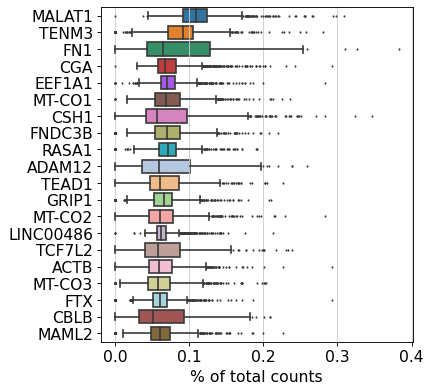

In [80]:
sc.pl.highest_expr_genes(rna, n_top=20)

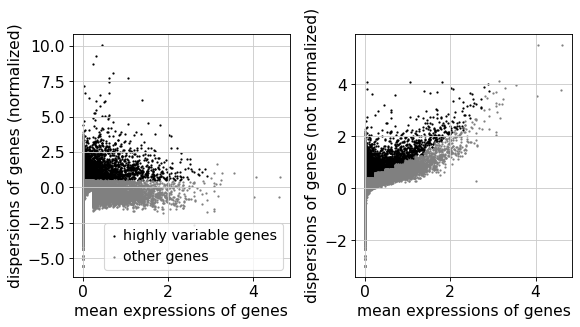

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


View of AnnData object with n_obs × n_vars = 1605 × 4925
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'barcode_sample_copy', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'annotation_prev', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'annotation_prev_or_removed', 'inv_troph_labels_initial', 'louvain_scvi_n_latent_8', 'final_annot_inv_troph', 'louvain_scvi_troph_rest', 'final_annot_all_troph', 'final_annot_inv_troph_corrected', 'final_annot_all_troph_corrected', 'technology', 'celltype', 'celltype_from_mdata'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_c

In [81]:
#find highly variable genes (RNA)
sc.pp.highly_variable_genes(rna, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(rna)
rna = rna[:, rna.var.highly_variable]
rna

In [82]:
curr_embedding_key = 'X_umap_scVI_n_latent_8_sample'

Trying to set attribute `.uns` of view, copying.


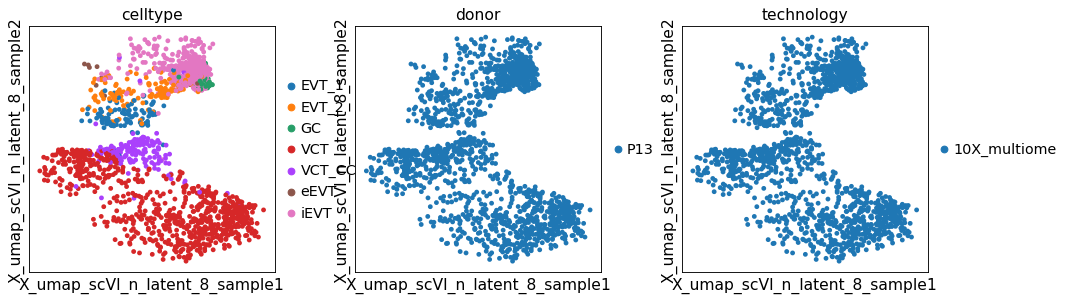

In [83]:
sc.pl.embedding(rna, curr_embedding_key, color = ['celltype', 'donor', 'technology'])

In [84]:
# scaling data also
sc.pp.scale(rna, max_value=10)

In [85]:
# re-assign filtered RNA data to muon object
rna.raw = rna.copy()
mdata.mod['RNA'] = rna.copy()

## ATAC

In [86]:
atac = {}

atac_views_keys = adata_atac_sub_views.keys()
atac_views_keys


dict_keys(['ATAC_all', 'ATAC_primed_enhancers', 'ATAC_active_enhancers', 'ATAC_repressed_enhancers', 'ATAC_exon', 'ATAC_intergenic', 'ATAC_intron', 'ATAC_promoter'])

In [87]:
# if using only 1 atac view with all the relevant peaks
atac_views_keys = ['ATAC_all']

# if using other informative views
#atac_views_keys = ['ATAC_primed_enhancers', 'ATAC_active_enhancers', 'ATAC_repressed_enhancers', 'ATAC_exon', 'ATAC_intergenic', 'ATAC_intron', 'ATAC_promoter']

In [88]:
for key in atac_views_keys:
    print(key)
    atac[key] = mdata.mod[key]
    print(atac[key].X.shape)

ATAC_all
(1605, 42558)


In [89]:
# normalize ATAC data using TFIDF
#atac_copy = atac.copy()

for key in atac_views_keys:
    print('shape before:', atac[key].X.shape)
    print(key)
    # this is not ideal!
    #sc.pp.normalize_per_cell(atac[key], counts_per_cell_after=1e4)
    
    
    mu.atac.pp.tfidf(atac[key], scale_factor=1e4) #- need to make this work! breaks currently
    
    print('shape after:', atac[key].X.shape)

#sc.pp.normalize_per_cell(atac_copy, counts_per_cell_after=1e4)
#sc.pp.log1p(atac_copy)

shape before: (1605, 42558)
ATAC_all
shape after: (1605, 42558)


/opt/conda/lib/python3.8/site-packages/muon/_atac/preproc.py:64: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.asarray(adata.shape[0] / adata.X.sum(axis=0)).reshape(-1)


In [90]:
for key in atac_views_keys: #['ATAC_all']:
    print(key, atac[key].X.shape)

ATAC_all (1605, 42558)


## later: for peaks with dual labels prioritising enhancer labels and for the ones with multiple enhancer labels making separate little views to keep the data

_________

# Selecting HV features in `ATAC_all` view

## Path A: using raw ATAC counts (straight out of peak calling)

In [91]:
# feature selection in ATAC: using raw accessibility values straight out of peak calling to calculate variability of features on pseudobulks (by cell type)
# and eventually choose features based on that

# Define variables

cellatac_outdir = '/lustre/scratch117/cellgen/team292/aa22/with_Stijn/202111_snATAC-seq_data_MFI/multiome_ATAC_samples_analysis/trophoblast_only_analysis/results200k_customcls4/'
outdir = '/lustre/scratch117/cellgen/team292/aa22/with_Stijn/202111_snATAC-seq_data_MFI/multiome_ATAC_samples_analysis/trophoblast_only_analysis/downstream_analysis_custom_clust/'
experiment_prefix = 'multiome_only_MFI_trophoblast_only_peak_calling_w_custom_clusters'

input={'cnts': cellatac_outdir + 'peak_matrix/peaks_bc_matrix.mmtx.gz',
        "bcs": cellatac_outdir + 'peak_matrix/bc.txt',
      "peaks": cellatac_outdir + 'peak_matrix/peaks.txt',
      'clusters': cellatac_outdir + 'qc/seurat-clades.tsv'}

output = {
    "cnt_mmtx":outdir + experiment_prefix + '_ATAC_cisTopic.mmtx',
    "cnt_peaks":outdir + experiment_prefix + '_ATAC_cisTopic.peaks.tsv',
    "cnt_cells":outdir + experiment_prefix + '_ATAC_cisTopic.cells.tsv',
    "h5ad":outdir + experiment_prefix + '_ATAC_raw.h5ad',
}


adata_atac_raw = sc.read_mtx(input["cnts"]).T

bc = pd.read_table(input["bcs"], header=None)
feat = pd.read_table(input["peaks"], header=None)

adata_atac_raw.obs_names = bc[0]
adata_atac_raw.var_names = feat[0]
adata_atac_raw


AnnData object with n_obs × n_vars = 7481 × 114030

In [92]:
# subset to peaks anf cell IDs in the final object
adata_atac_raw = adata_atac_raw[adata_atac_sub.obs['barcode'], adata_atac_sub.var_names].copy()

In [93]:
adata_atac_raw

AnnData object with n_obs × n_vars = 1605 × 42558

In [94]:
adata_atac_raw.obs['celltype'] = adata_atac_sub.obs.set_index('barcode').loc[adata_atac_raw.obs_names,'celltype']

In [95]:
adata_atac_raw

AnnData object with n_obs × n_vars = 1605 × 42558
    obs: 'celltype'

In [96]:
# checking - these values should NOT be binary
adata_atac_raw_mtx = adata_atac_raw.X.todense()

In [97]:
np.max(adata_atac_raw_mtx) # YES not binary - good

8.0

In [98]:
np.min(adata_atac_raw_mtx)

0.0

In [99]:
# creating a pseudobulk object

# per ATAC view

adatas_atac_raw_pseudobulk = {} 

for key in atac_views_keys: #['ATAC_all']:
    print(key, atac[key].X.shape)
    
    adatas_atac_raw_pseudobulk[key] = anndata.AnnData(obs = pd.DataFrame(index = np.unique(atac[key].obs['celltype'])),
                                            var = atac[key].var)

ATAC_all (1605, 42558)


In [100]:
adatas_atac_raw_pseudobulk['ATAC_all']

AnnData object with n_obs × n_vars = 7 × 42558
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'contains_primed_enhancers', 'contains_active_enhancers', 'contains_repressed_enhancers'

In [101]:
adatas_atac_raw_pseudobulk['ATAC_all'].obs

Empty DataFrame
Columns: []
Index: [EVT_1, EVT_2, GC, VCT, VCT_CCC, eEVT, iEVT]

In [102]:
adatas_atac_raw_pseudobulk[key]

AnnData object with n_obs × n_vars = 7 × 42558
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'contains_primed_enhancers', 'contains_active_enhancers', 'contains_repressed_enhancers'

In [102]:
%%time

# takes ~9 minutes

adatas_atac_raw_pseudobulk_X_df = {}

for key in atac_views_keys: #['ATAC_all']:
    print(key)
    adatas_atac_raw_pseudobulk_X_df[key] = pd.DataFrame(index = adatas_atac_raw_pseudobulk[key].obs.index,
                                                       columns = adatas_atac_raw_pseudobulk[key].var.index)
    for ct in adatas_atac_raw_pseudobulk_X_df[key].index:
        #print(ct)
        #curr_adata_atac_raw_subset = adata_atac_raw[]
        adatas_atac_raw_pseudobulk_X_df[key].loc[ct,:] = [np.mean(adata_atac_raw[(adata_atac_raw.obs['celltype'] == ct), peak_id].X.todense()) for peak_id in list(adatas_atac_raw_pseudobulk_X_df[key].columns)]
        
    

ATAC_all


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


CPU times: user 9min 8s, sys: 1.16 s, total: 9min 9s
Wall time: 9min 9s


In [103]:
adatas_atac_raw_pseudobulk_X_df['ATAC_all']

peak_id chr1:904345-904907 chr1:938156-938411 chr1:959000-959712  \
EVT_1             0.037736           0.028302            0.04717   
EVT_2             0.015385                0.0           0.076923   
GC                     0.0                0.0           0.034483   
VCT               0.015464           0.005155           0.034794   
VCT_CCC           0.032468           0.006494           0.025974   
eEVT              0.111111           0.111111                0.0   
iEVT              0.029925           0.002494           0.074813   

peak_id chr1:966208-966555 chr1:966847-967127 chr1:975929-976561  \
EVT_1             0.037736           0.028302           0.009434   
EVT_2             0.015385                0.0           0.046154   
GC                     0.0                0.0           0.034483   
VCT               0.006443           0.016753           0.037371   
VCT_CCC           0.006494           0.025974           0.045455   
eEVT              0.111111           0.111111                0.0   
iEVT              0.042394           0.024938           0.027431   

peak_id chr1:999901-1000393 chr1:1000739-1000971 chr1:1006456-1006715  \
EVT_1              0.084906             0.018868             0.056604   
EVT_2              0.130769             0.107692             0.015385   
GC                      0.0             0.034483             0.068966   
VCT                0.030928             0.006443             0.006443   
VCT_CCC            0.025974             0.045455             0.012987   
eEVT                    0.0                  0.0                  0.0   
iEVT               0.119701             0.104738             0.057357   

peak_id chr1:1013031-1013734  ... chrX:154719165-154719708  \
EVT_1               0.103774  ...                 0.037736   
EVT_2               0.092308  ...                 0.053846   
GC                  0.034483  ...                      0.0   
VCT                 0.025773  ...                 0.001289   
VCT_CCC             0.051948  ...                 0.006494   
eEVT                     0.0  ...                 0.222222   
iEVT                0.112219  ...                 0.077307   

peak_id chrX:154748779-154749228 chrX:154762329-154763078  \
EVT_1                        0.0                 0.103774   
EVT_2                   0.030769                 0.084615   
GC                           0.0                      0.0   
VCT                     0.002577                 0.039948   
VCT_CCC                      0.0                 0.071429   
eEVT                    0.111111                 0.111111   
iEVT                    0.042394                 0.109726   

peak_id chrX:154785520-154785997 chrX:154805075-154805684  \
EVT_1                    0.04717                 0.009434   
EVT_2                   0.038462                 0.038462   
GC                           0.0                 0.034483   
VCT                     0.006443                 0.043814   
VCT_CCC                      0.0                 0.025974   
eEVT                         0.0                 0.333333   
iEVT                    0.054863                 0.024938   

peak_id chrX:154805785-154806070 chrX:155026470-155027451  \
EVT_1                   0.018868                 0.141509   
EVT_2                   0.007692                 0.107692   
GC                           0.0                 0.034483   
VCT                     0.025773                 0.043814   
VCT_CCC                 0.012987                 0.084416   
eEVT                    0.222222                      0.0   
iEVT                    0.037406                 0.167082   

peak_id chrX:155070780-155071828 chrX:155215852-155216966  \
EVT_1                   0.141509                 0.018868   
EVT_2                   0.130769                 0.023077   
GC                      0.034483                      0.0   
VCT                     0.069588                 0.023196   
VCT_CCC                 0.090909                 0.03246

## to think about: is the variance of a peak correlating with the total count of that peak? may not be crucial here 

In [104]:
# calculate variance
for key in atac_views_keys: #['ATAC_all']:
    print(key)
    adatas_atac_raw_pseudobulk_X_df[key].loc['variance',:] = [np.var(list(adatas_atac_raw_pseudobulk_X_df[key].loc[:,peak_id])) for peak_id in list(adatas_atac_raw_pseudobulk_X_df[key].columns)]
    
    

ATAC_all


In [105]:
adatas_atac_raw_pseudobulk_X_df['ATAC_all']

peak_id  chr1:904345-904907 chr1:938156-938411 chr1:959000-959712  \
EVT_1              0.037736           0.028302            0.04717   
EVT_2              0.015385                0.0           0.076923   
GC                      0.0                0.0           0.034483   
VCT                0.015464           0.005155           0.034794   
VCT_CCC            0.032468           0.006494           0.025974   
eEVT               0.111111           0.111111                0.0   
iEVT               0.029925           0.002494           0.074813   
variance           0.001118           0.001408           0.000636   

peak_id  chr1:966208-966555 chr1:966847-967127 chr1:975929-976561  \
EVT_1              0.037736           0.028302           0.009434   
EVT_2              0.015385                0.0           0.046154   
GC                      0.0                0.0           0.034483   
VCT                0.006443           0.016753           0.037371   
VCT_CCC            0.006494           0.025974           0.045455   
eEVT               0.111111           0.111111                0.0   
iEVT               0.042394           0.024938           0.027431   
variance           0.001286           0.001228            0.00027   

peak_id  chr1:999901-1000393 chr1:1000739-1000971 chr1:1006456-1006715  \
EVT_1               0.084906             0.018868             0.056604   
EVT_2               0.130769             0.107692             0.015385   
GC                       0.0             0.034483             0.068966   
VCT                 0.030928             0.006443             0.006443   
VCT_CCC             0.025974             0.045455             0.012987   
eEVT                     0.0                  0.0                  0.0   
iEVT                0.119701             0.104738             0.057357   
variance            0.002612             0.001686             0.000703   

peak_id  chr1:1013031-1013734  ... chrX:154719165-154719708  \
EVT_1                0.103774  ...                 0.037736   
EVT_2                0.092308  ...                 0.053846   
GC                   0.034483  ...                      0.0   
VCT                  0.025773  ...                 0.001289   
VCT_CCC              0.051948  ...                 0.006494   
eEVT                      0.0  ...                 0.222222   
iEVT                 0.112219  ...                 0.077307   
variance             0.001596  ...                 0.005285   

peak_id  chrX:154748779-154749228 chrX:154762329-154763078  \
EVT_1                         0.0                 0.103774   
EVT_2                    0.030769                 0.084615   
GC                            0.0                      0.0   
VCT                      0.002577                 0.039948   
VCT_CCC                       0.0                 0.071429   
eEVT                     0.111111                 0.111111   
iEVT                     0.042394                 0.109726   
variance                 0.001444                 0.001471   

peak_id  chrX:154785520-154785997 chrX:154805075-154805684  \
EVT_1                     0.04717                 0.009434   
EVT_2                    0.038462                 0.038462   
GC                            0.0                 0.034483   
VCT                      0.006443                 0.043814   
VCT_CCC                       0.0                 0.025974   
eEVT                          0.0                 0.333333   
iEVT                     0.054863                 0.024938   
variance                 0.000524                 0.011409   

peak_id  chrX:154805785-154806070 chrX:155026470-155027451  \
EVT_1                    0.018868                 0.141509   
EVT_2                    0.007692                 0.107692   
GC                            0.0                 0.034483   
VCT                      0.025773                 0.043814   
VCT_CCC                  0.012987                 0.084416   
eEVT                     0.2222

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


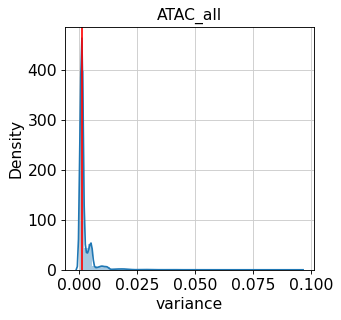

In [106]:
# with only ATAC_all view
for key in atac_views_keys:
    #print(key)
    plt.figure(figsize=(4,4))
    plt.title(key)
    sns.distplot(adatas_atac_raw_pseudobulk_X_df[key].loc['variance',:])
    plt.axvline(np.quantile(adatas_atac_raw_pseudobulk_X_df[key].loc['variance',:], 0.5), c='r')

In [107]:
# transpose to filter easier
for key in atac_views_keys: #['ATAC_all']:
    #print(key)
    adatas_atac_raw_pseudobulk_X_df[key] = adatas_atac_raw_pseudobulk_X_df[key].T

In [108]:
# for each view select top N% of features (by variance)

# for ATAC_all view aiming to select about 10K features
Q = 0.75 # N/100

selected_features = {}

for key in atac_views_keys: #['ATAC_all']:
    print(key)
    cutoff = np.quantile(adatas_atac_raw_pseudobulk_X_df[key]['variance'], Q)
    selected_features[key] = list(adatas_atac_raw_pseudobulk_X_df[key][adatas_atac_raw_pseudobulk_X_df[key]['variance'] >= cutoff].index)
    print(len(selected_features[key]), 'features selected out of', len(adatas_atac_raw_pseudobulk_X_df[key].index))
    print('\n')

ATAC_all
10640 features selected out of 42558




In [109]:
# actually subsetting all view to HV features according to this approach

for key in atac_views_keys: #['ATAC_all']:
    print(key)
    atac[key].var['highly_variable'] = [True if idx in selected_features[key] else False for idx in atac[key].var_names]
    
    atac[key] = atac[key][:, atac[key].var.highly_variable]
    
    print(atac[key].X.shape, '\n')

ATAC_all
(1605, 10640) 



/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [111]:
# expot these peak IDs to be able to look at them in IGV
pd.DataFrame(atac['ATAC_all'].var.loc[:,'highly_variable']).to_csv('./20220209_peak_IDs_and_HV_status_for_1_ATAC_view_with_VCT.csv')

In [103]:
HV_peaks_df = pd.read_csv('./20220209_peak_IDs_and_HV_status_for_1_ATAC_view_with_VCT.csv', index_col=0)
HV_peaks_df

highly_variable
peak_id                                  
chr1:999901-1000393                  True
chr1:1019192-1019792                 True
chr1:1073233-1074498                 True
chr1:1079363-1080404                 True
chr1:1115778-1116666                 True
...                                   ...
chrX:154719165-154719708             True
chrX:154805075-154805684             True
chrX:154805785-154806070             True
chrX:155026470-155027451             True
chrX:155070780-155071828             True

[10640 rows x 1 columns]

In [104]:
atac['ATAC_all'] = atac['ATAC_all'][:,HV_peaks_df.index]

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [105]:
atac['ATAC_all'].var['highly_variable'] = [True for elem in atac['ATAC_all'].var.index]

Trying to set attribute `.var` of view, copying.


_______________

In [106]:
# also scaling data to avoid very small values in output of the model for atac views

for key in atac_views_keys: #['ATAC_all']:
    print(key)
    sc.pp.scale(atac[key], max_value=10)

ATAC_all


In [107]:
# compute PCA to just have a look?

object_copies_for_pca = {}

for key in atac_views_keys:
    print(key)
    object_copies_for_pca[key] = atac[key].copy()
    #sc.pp.scale(object_copies_for_pca[key])
    sc.tl.pca(object_copies_for_pca[key])

ATAC_all


... storing 'annotation' as categorical
... storing 'gene_name' as categorical
... storing 'gene_id' as categorical


ATAC_all


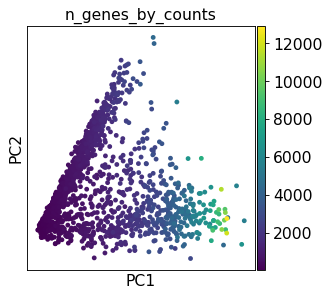

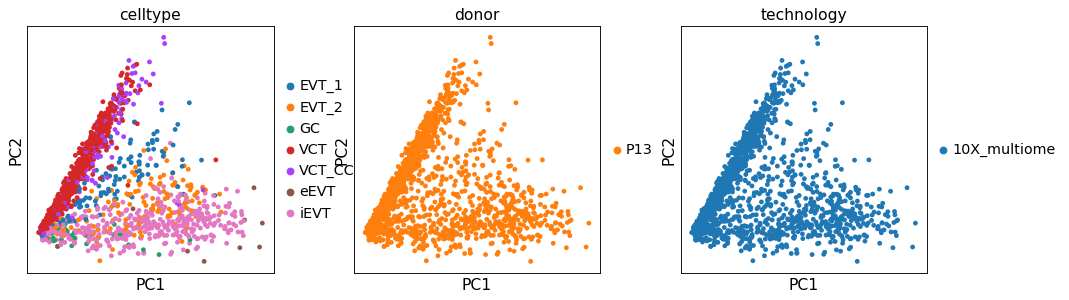

In [108]:
# only multiome, HV peaks calc on raw counts

for key in atac_views_keys:
    print(key)
    sc.pl.pca(object_copies_for_pca[key], color=["n_genes_by_counts"])
    sc.pl.pca(object_copies_for_pca[key], color=["celltype", "donor", "technology"])

In [109]:
# making matrix dense to assist visualisation
mdata.mod['ATAC_all'].X = mdata.mod['ATAC_all'].X.toarray()

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


KeyboardInterrupt: 

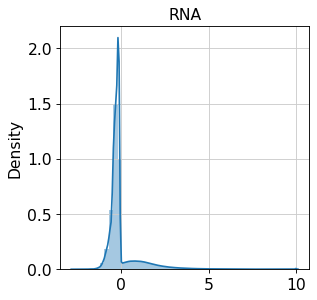

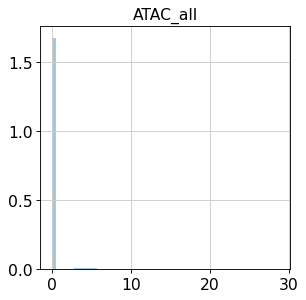

In [110]:
# with scaling
for key in mdata.mod.keys():
    #print(key)
    plt.figure(figsize=(4,4))
    plt.title(key)
    sns.distplot(mdata.mod[key].X)

In [111]:
# re-assign new ATAC data to muon object
for key in atac_views_keys: #['ATAC_all']:
    print(key)
    atac[key].raw = atac[key].copy()
    mdata.mod[key] = atac[key].copy()

ATAC_all


In [112]:
mdata.mod.keys()

dict_keys(['RNA', 'ATAC_all'])

In [113]:
#mdata.mod['ATAC_all'].X = mdata['ATAC_all'].X.toarray()

In [114]:
mdata.mod['ATAC_all'].X # is it sparse or dense?

array([[ 6.0863967 , -0.27167657, -0.3052345 , ..., -0.15510783,
        -0.28190702, -0.293187  ],
       [-0.22384228, -0.27167657, -0.3052345 , ..., -0.15510783,
         2.3389459 , -0.293187  ],
       [-0.22384228, -0.27167657, -0.3052345 , ..., -0.15510783,
        -0.28190702, -0.293187  ],
       ...,
       [-0.22384228, -0.27167657, -0.3052345 , ..., -0.15510783,
        -0.28190702, -0.293187  ],
       [-0.22384228, -0.27167657, -0.3052345 , ..., -0.15510783,
        -0.28190702, -0.293187  ],
       [-0.22384228, -0.27167657, -0.3052345 , ..., -0.15510783,
        -0.28190702,  2.2339203 ]], dtype=float32)

In [118]:
mdata.obs['ATAC_all:celltype']

ACGTCAAGTCCGCTGT-1_Pla_Camb10714919_and_40110_Pla_Camb10687915        VCT
CTCACACTCTGCAACG-1_Pla_Camb10714919_and_40110_Pla_Camb10687915      EVT_2
AGTGCACGTGTTTGCT-1_Pla_Camb10714920_and_40110_Pla_Camb10687916    VCT_CCC
CTTGTAAAGTAATCCA-1_Pla_Camb10714920_and_40110_Pla_Camb10687916      EVT_2
ACTAATCCATAAGGAC-1_Pla_Camb10714919_and_40110_Pla_Camb10687915       iEVT
                                                                   ...   
CCATAATCACTTACAG-1_Pla_Camb10714919_and_40110_Pla_Camb10687915       iEVT
GTGCTTACACCTCAGG-1_Pla_Camb10714919_and_40110_Pla_Camb10687915        VCT
GGTGTTGTCCTTGTTG-1_Pla_Camb10714920_and_40110_Pla_Camb10687916      EVT_1
TAGCCTCTCAGCCAAT-1_Pla_Camb10714920_and_40110_Pla_Camb10687916      EVT_2
AAAGGAGCATCTAGCA-1_Pla_Camb10714920_and_40110_Pla_Camb10687916       iEVT
Name: ATAC_all:celltype, Length: 1605, dtype: category
Categories (7, object): ['EVT_1', 'EVT_2', 'GC', 'VCT', 'VCT_CCC', 'eEVT', 'iEVT']

In [116]:
mdata.obs['RNA:celltype']

ACGTCAAGTCCGCTGT-1_Pla_Camb10714919_and_40110_Pla_Camb10687915        VCT
CTCACACTCTGCAACG-1_Pla_Camb10714919_and_40110_Pla_Camb10687915      EVT_2
AGTGCACGTGTTTGCT-1_Pla_Camb10714920_and_40110_Pla_Camb10687916    VCT_CCC
CTTGTAAAGTAATCCA-1_Pla_Camb10714920_and_40110_Pla_Camb10687916      EVT_2
ACTAATCCATAAGGAC-1_Pla_Camb10714919_and_40110_Pla_Camb10687915       iEVT
                                                                   ...   
CCATAATCACTTACAG-1_Pla_Camb10714919_and_40110_Pla_Camb10687915       iEVT
GTGCTTACACCTCAGG-1_Pla_Camb10714919_and_40110_Pla_Camb10687915        VCT
GGTGTTGTCCTTGTTG-1_Pla_Camb10714920_and_40110_Pla_Camb10687916      EVT_1
TAGCCTCTCAGCCAAT-1_Pla_Camb10714920_and_40110_Pla_Camb10687916      EVT_2
AAAGGAGCATCTAGCA-1_Pla_Camb10714920_and_40110_Pla_Camb10687916       iEVT
Name: RNA:celltype, Length: 1605, dtype: category
Categories (7, object): ['EVT_1', 'EVT_2', 'GC', 'VCT', 'VCT_CCC', 'eEVT', 'iEVT']

In [115]:
mdata.mod['RNA'].X

array([[-0.29736206, -0.14327154, -0.43604034, ..., -0.2570238 ,
        -0.39097264, -0.32425636],
       [-0.29736206, -0.14327154, -0.43604034, ..., -0.2570238 ,
        -0.39097264, -0.32425636],
       [ 2.9540756 , -0.14327154,  1.742354  , ..., -0.2570238 ,
         3.8129957 , -0.32425636],
       ...,
       [-0.29736206, -0.14327154, -0.43604034, ..., -0.2570238 ,
        -0.39097264, -0.32425636],
       [-0.29736206, -0.14327154, -0.43604034, ..., -0.2570238 ,
         1.3238814 , -0.32425636],
       [-0.29736206, -0.14327154, -0.43604034, ..., -0.2570238 ,
        -0.39097264, -0.32425636]], dtype=float32)

## Train MEFISTO (on all multiome nuclei) using UMAP coordinates (recalculated here only for the subset of nuclei present, RNA) as pseudotime in MEFISTO

In [119]:
mdata

MuData object with n_obs × n_vars = 1605 × 71616
  2 modalities
    RNA:	1605 x 4925
      obs:	'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'barcode_sample_copy', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'annotation_prev', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'annotation_prev_or_removed', 'inv_troph_labels_initial', 'louvain_scvi_n_latent_8', 'final_annot_inv_troph', 'louvain_scvi_troph_rest', 'final_annot_all_troph', 'final_annot_inv_troph_corrected', 'final_annot_all_troph_corrected', 'technology', 'celltype', 'celltype_from_mdata'
      var:	'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'final_annot_all_troph_corrected_colors', 'technology_colors', 'celltype_colors', 'log1p', 'hvg', 'donor_colors'
      obsm:	'X_umap_scVI_n_latent_8_sample'
    ATAC_all:	1605 x 10640
      obs:	'cellatac_code', 'sample', 'barcode', 'donor', 'annot_multiome_combined', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'age', 'tissue', 'technology', 'celltype'
      var:	'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'contains_primed_enhancers', 'contains_active_enhancers', 'contains_repressed_enhancers', 'highly_variable', 'mean', 'std'
      uns:	'age_colors', 'annot_multiome_combined_colors', 'donor_colors', 'neighbors', 'sample_colors', 'technology_colors', 'tissue_colors', 'umap', 'celltype_colors'
      obsm:	'X_cistopic_50', 'X_umap'
      varm:	'peak2gene'
      layers:	'binary_raw'
      obsp:	'connectivities', 'distances'

In [120]:
# check format of matrices - should all be dense for MOFA
mdata.mod.keys()

dict_keys(['RNA', 'ATAC_all'])

In [121]:
outdir = '/lustre/scratch117/cellgen/team292/aa22/with_Stijn/202111_snATAC-seq_data_MFI/multiome_ATAC_samples_analysis/trophoblast_only_analysis/downstream_analysis_custom_clust/out_MOFA_analysis/'

In [135]:
# save muon object

# 20220209, here atac is only 1 view subsetted to HV features with pseudobulk-based approach ON RAW values and binarised + TF-IDF normalised values are in atac.X view; both RNA and ATAC are scaled (per view)
mdata.write(outdir + "20220209_data4mofa_only_multiome_with_1_atac_view_HV_features_calc_on_raw_and_bin_tfidf_atac_values_all_views_scaled_only_common_barcodes_with_RNA_based_annotations.h5mu")



... storing 'annotation' as categorical
... storing 'gene_name' as categorical
... storing 'gene_id' as categorical
... storing 'annotation' as categorical
... storing 'gene_name' as categorical
... storing 'gene_id' as categorical


In [136]:
mdata

MuData object with n_obs × n_vars = 1605 × 15565
  var:	'highly_variable', 'mean', 'std'
  obsm:	'X_mofa'
  varm:	'LFs'
  2 modalities
    RNA:	1605 x 4925
      obs:	'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'barcode_sample_copy', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'annotation_prev', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'annotation_prev_or_removed', 'inv_troph_labels_initial', 'louvain_scvi_n_latent_8', 'final_annot_inv_troph', 'louvain_scvi_troph_rest', 'final_annot_all_troph', 'final_annot_inv_troph_corrected', 'final_annot_all_troph_corrected', 'technology', 'celltype', 'celltype_from_mdata'
      var:	'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'final_annot_all_troph_corrected_colors', 'technology_colors', 'celltype_colors', 'log1p', 'hvg', 'donor_colors'
      obsm:	'X_umap_scVI_n_latent_8_sample'
    ATAC_all:	1605 x 10640
      obs:	'cellatac_code', 'sample', 'barcode', 'donor', 'annot_multiome_combined', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'age', 'tissue', 'technology', 'celltype'
      var:	'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'contains_primed_enhancers', 'contains_active_enhancers', 'contains_repressed_enhancers', 'highly_variable', 'mean', 'std'
      uns:	'age_colors', 'annot_multiome_combined_colors', 'donor_colors', 'neighbors', 'sample_colors', 'technology_colors', 'tissue_colors', 'umap', 'celltype_colors'
      obsm:	'X_cistopic_50', 'X_umap'
      varm:	'peak2gene'
      layers:	'binary_raw'
      obsp:	'connectivities', 'distances'

In [137]:
# read in muon object

# 20220209, here atac is only 1 view subsetted to HV features with pseudobulk-based approach ON RAW values and binarised + TF-IDF normalised values are in atac.X view; both RNA and ATAC are scaled (per view)
mdata = mu.read(outdir + "20220209_data4mofa_only_multiome_with_1_atac_view_HV_features_calc_on_raw_and_bin_tfidf_atac_values_all_views_scaled_only_common_barcodes_with_RNA_based_annotations.h5mu")


In [138]:
mdata.obs

ATAC_all:cellatac_code  \
ACGTCAAGTCCGCTGT-1_Pla_Camb10714919_and_40110_P...                     10   
CTCACACTCTGCAACG-1_Pla_Camb10714919_and_40110_P...                     10   
AGTGCACGTGTTTGCT-1_Pla_Camb10714920_and_40110_P...                     11   
CTTGTAAAGTAATCCA-1_Pla_Camb10714920_and_40110_P...                     11   
ACTAATCCATAAGGAC-1_Pla_Camb10714919_and_40110_P...                     10   
...                                                                   ...   
CCATAATCACTTACAG-1_Pla_Camb10714919_and_40110_P...                     10   
GTGCTTACACCTCAGG-1_Pla_Camb10714919_and_40110_P...                     10   
GGTGTTGTCCTTGTTG-1_Pla_Camb10714920_and_40110_P...                     11   
TAGCCTCTCAGCCAAT-1_Pla_Camb10714920_and_40110_P...                     11   
AAAGGAGCATCTAGCA-1_Pla_Camb10714920_and_40110_P...                     11   

                                                                                ATAC_all:sample  \
ACGTCAAGTCCGCTGT-1_Pla_Camb10714919_and_40110_P...  Pla_Camb10714919_and_40110_Pla_Camb10687915   
CTCACACTCTGCAACG-1_Pla_Camb10714919_and_40110_P...  Pla_Camb10714919_and_40110_Pla_Camb10687915   
AGTGCACGTGTTTGCT-1_Pla_Camb10714920_and_40110_P...  Pla_Camb10714920_and_40110_Pla_Camb10687916   
CTTGTAAAGTAATCCA-1_Pla_Camb10714920_and_40110_P...  Pla_Camb10714920_and_40110_Pla_Camb10687916   
ACTAATCCATAAGGAC-1_Pla_Camb10714919_and_40110_P...  Pla_Camb10714919_and_40110_Pla_Camb10687915   
...                                                                                         ...   
CCATAATCACTTACAG-1_Pla_Camb10714919_and_40110_P...  Pla_Camb10714919_and_40110_Pla_Camb10687915   
GTGCTTACACCTCAGG-1_Pla_Camb10714919_and_40110_P...  Pla_Camb10714919_and_40110_Pla_Camb10687915   
GGTGTTGTCCTTGTTG-1_Pla_Camb10714920_and_40110_P...  Pla_Camb10714920_and_40110_Pla_Camb10687916   
TAGCCTCTCAGCCAAT-1_Pla_Camb10714920_and_40110_P...  Pla_Camb10714920_and_40110_Pla_Camb10687916   
AAAGGAGCATCTAGCA-1_Pla_Camb10714920_and_40110_P...  Pla_Camb10714920_and_40110_Pla_Camb10687916   

                                                         ATAC_all:barcode  \
ACGTCAAGTCCGCTGT-1_Pla_Camb10714919_and_40110_P...  10-ACGTCAAGTCCGCTGT-1   
CTCACACTCTGCAACG-1_Pla_Camb10714919_and_40110_P...  10-CTCACACTCTGCAACG-1   
AGTGCACGTGTTTGCT-1_Pla_Camb10714920_and_40110_P...  11-AGTGCACGTGTTTGCT-1   
CTTGTAAAGTAATCCA-1_Pla_Camb10714920_and_40110_P...  11-CTTGTAAAGTAATCCA-1   
ACTAATCCATAAGGAC-1_Pla_Camb10714919_and_40110_P...  10-ACTAATCCATAAGGAC-1   
...                                                                   ...   
CCATAATCACTTACAG-1_Pla_Camb10714919_and_40110_P...  10-CCATAATCACTTACAG-1   
GTGCTTACACCTCAGG-1_Pla_Camb10714919_and_40110_P...  10-GTGCTTACACCTCAGG-1   
GGTGTTGTCCTTGTTG-1_Pla_Camb10714920_and_40110_P...  11-GGTGTTGTCCTTGTTG-1   
TAGCCTCTCAGCCAAT-1_Pla_Camb10714920_and_40110_P...  11-TAGCCTCTCAGCCAAT-1   
AAAGGAGCATCTAGCA-1_Pla_Camb10714920_and_40110_P...  11-AAAGGAGCATCTAGCA-1   

                                                   ATAC_all:donor  \
ACGTCAAGTCCGCTGT-1_Pla_Camb10714919_and_40110_P...            P13   
CTCACACTCTGCAACG-1_Pla_Camb10714919_and_40110_P...            P13   
AGTGCACGTGTTTGCT-1_Pla_Camb10714920_and_40110_P...            P13   
CTTGTAAAGTAATCCA-1_Pla_Camb10714920_and_40110_P...            P13   
ACTAATCCATAAGGAC-1_Pla_Camb10714919_and_40110_P...            P13   
...                                                           ...   
CCATAATCACTTACAG-1_Pla_Camb10714919_and_40110_P...            P13   
GTGCTTACACCTCAGG-1_Pla_Camb10714919_and_40110_P...            P13   
GGTGTTGTCCTTGTTG-1_Pla_Camb10714920_and_40110_P...            P13   
TAGCCTCTCAGCCAAT-1_Pla_Camb10714920_and_40110_P...            P13   
AAAGGAGCATCTAGCA-1_Pla_Camb10714920_and_40110_P...            P13   

                                                   ATAC_all:annot_multiome_combined  \
ACGTCAAGTCCGCTGT-1_Pla_Camb10714919_and_40110_P...                            VCT_p   
CTCACACTC

In [139]:
mdata

MuData object with n_obs × n_vars = 1605 × 15565
  var:	'highly_variable', 'mean', 'std'
  obsm:	'X_mofa'
  varm:	'LFs'
  2 modalities
    ATAC_all:	1605 x 10640
      obs:	'cellatac_code', 'sample', 'barcode', 'donor', 'annot_multiome_combined', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'age', 'tissue', 'technology', 'celltype'
      var:	'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'contains_primed_enhancers', 'contains_active_enhancers', 'contains_repressed_enhancers', 'highly_variable', 'mean', 'std'
      uns:	'age_colors', 'annot_multiome_combined_colors', 'celltype_colors', 'donor_colors', 'neighbors', 'sample_colors', 'technology_colors', 'tissue_colors', 'umap'
      obsm:	'X_cistopic_50', 'X_umap'
      varm:	'peak2gene'
      layers:	'binary_raw'
      obsp:	'connectivities', 'distances'
    RNA:	1605 x 4925
      obs:	'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'barcode_sample_copy', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'annotation_prev', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'annotation_prev_or_removed', 'inv_troph_labels_initial', 'louvain_scvi_n_latent_8', 'final_annot_inv_troph', 'louvain_scvi_troph_rest', 'final_annot_all_troph', 'final_annot_inv_troph_corrected', 'final_annot_all_troph_corrected', 'technology', 'celltype', 'celltype_from_mdata'
      var:	'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'celltype_colors', 'donor_colors', 'final_annot_all_troph_corrected_colors', 'hvg', 'technology_colors'
      obsm:	'X_umap_scVI_n_latent_8_sample'

In [159]:
# for running MEFISTO let's calculate a quick UMAP with the RNA data here with conventional pipeline - no need for batch correction since batch shouldn't be bad?

# this object has normalised, log tr, HVG subsetted and scaled values
# need to run PCA, neighbors and umap
mdata.mod['RNA']


AnnData object with n_obs × n_vars = 1605 × 4925
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'barcode_sample_copy', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'annotation_prev', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'annotation_prev_or_removed', 'inv_troph_labels_initial', 'louvain_scvi_n_latent_8', 'final_annot_inv_troph', 'louvain_scvi_troph_rest', 'final_annot_all_troph', 'final_annot_inv_troph_corrected', 'final_annot_all_troph_corrected', 'technology', 'celltype'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


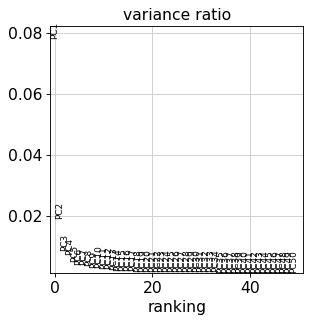

In [124]:
sc.tl.pca(mdata.mod['RNA'], n_comps=50)
sc.pl.pca_variance_ratio(mdata.mod['RNA'], n_pcs=50)

In [125]:
n_pcs_using = 8

rna_object_copy = mdata.mod['RNA'].copy()


sc.tl.pca(rna_object_copy, n_comps=n_pcs_using)
sc.pp.neighbors(rna_object_copy)
sc.tl.umap(rna_object_copy)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


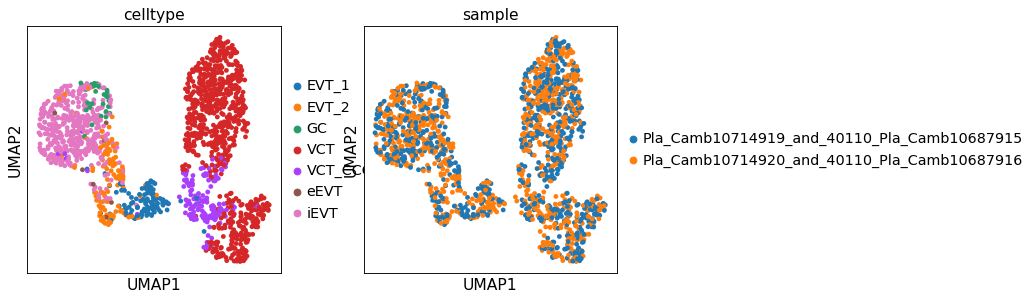

In [126]:
sc.pl.umap(rna_object_copy, color = ['celltype','sample'])

## it's fine here to use either the general UMAP coordinates or recalculated..

In [127]:
outdir

'/lustre/scratch117/cellgen/team292/aa22/with_Stijn/202111_snATAC-seq_data_MFI/multiome_ATAC_samples_analysis/trophoblast_only_analysis/downstream_analysis_custom_clust/out_MOFA_analysis/'

In [128]:
#rna_object_copy.write(outdir + 'rna_object_copy_with_de_novo_UMAP_with_VCT_20220209.h5ad')

In [130]:
rna_object_copy = sc.read(outdir + 'rna_object_copy_with_de_novo_UMAP_with_VCT_20220209.h5ad')

In [129]:
# for an alternative run of the model with a UMAP recalculated for a subset of nuclei here
mdata.obs['UMAP1_upd'] = rna_object_copy.obsm['X_umap'][:,0]
mdata.obs['UMAP2_upd'] = rna_object_copy.obsm['X_umap'][:,1]


In [ ]:
%%time

# started at around 13:00
# takes about 10 hours (uses 10 CPUs)

# train MEFISTO model (like MOFA but with added 2-D UMAP annotations to serve as proxy for pseudotime - may be good to use inv troph only umap here eventually??)
# takes a bit longer than MOFA... 5 hours ish

mu.tl.mofa(mdata, 
           outfile=outdir + 'models/' + '20220209_MEFISTO_using_de_novo_umap_with_VCT_rna_atac_multiome_only_with_1_atac_view_and_bin_tfidf_atac_values_all_views_scaled_only_common_barcodes_with_RNA_based_annotations.hdf5', 
           use_obs = "union",
           smooth_covariate=["UMAP1_upd", "UMAP2_upd"],
           use_float32=True # makes it run twice faster
          )



        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
use_float32 set to True: replacing float64 arrays by float32 arrays to speed up computations...

Loaded view='RNA' group='group1' with N=1605 samples and D=4925 features...
Loaded view='ATAC_all' group='group1' with N=1605 samples and D=10640 features...


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on t

### MEFISTO: Multiome nuclei only, with only 1 ATAC view, bin + TF-IDF normalised values, subsetted to HV peaks through pseudoblk-based approach using raw counts

using umap coordinates from recalculated manifold (inv troph + VCT)

09.02.2022

In [141]:
mdata.var

ATAC_all:peak_width  ATAC_all:exon  ATAC_all:gene  \
chr1:999901-1000393                 493.0            1.0            1.0   
chr1:1019192-1019792                601.0            0.0            0.0   
chr1:1073233-1074498               1266.0            1.0            1.0   
chr1:1079363-1080404               1042.0            0.0            0.0   
chr1:1115778-1116666                889.0            1.0            1.0   
...                                   ...            ...            ...   
ZSCAN9                                NaN            NaN            NaN   
ZSWIM5                                NaN            NaN            NaN   
ZSWIM6                                NaN            NaN            NaN   
ZWINT                                 NaN            NaN            NaN   
ZYG11A                                NaN            NaN            NaN   

                      ATAC_all:promoter ATAC_all:annotation  \
chr1:999901-1000393                 1.0                exon   
chr1:1019192-1019792                1.0            promoter   
chr1:1073233-1074498                1.0                exon   
chr1:1079363-1080404                0.0          intergenic   
chr1:1115778-1116666                1.0                exon   
...                                 ...                 ...   
ZSCAN9                              NaN                 NaN   
ZSWIM5                              NaN                 NaN   
ZSWIM6                              NaN                 NaN   
ZWINT                               NaN                 NaN   
ZYG11A                              NaN                 NaN   

                     ATAC_all:gene_name ATAC_all:gene_id  \
chr1:999901-1000393               ISG15  ENSG00000187608   
chr1:1019192-1019792               AGRN  ENSG00000188157   
chr1:1073233-1074498             RNF223  ENSG00000237330   
chr1:1079363-1080404                nan              nan   
chr1:1115778-1116666           C1orf159  ENSG00000131591   
...                                 ...              ...   
ZSCAN9                              NaN              NaN   
ZSWIM5                              NaN              NaN   
ZSWIM6                              NaN              NaN   
ZWINT                               NaN              NaN   
ZYG11A                              NaN              NaN   

                      ATAC_all:tss_distance  ATAC_all:ENCODE_blacklist  \
chr1:999901-1000393                     0.0                        0.0   
chr1:1019192-1019792                  330.0                        0.0   
chr1:1073233-1074498                    0.0                        0.0   
chr1:1079363-1080404                 3667.0                        0.0   
chr1:1115778-1116666                    0.0                        0.0   
...                                     ...                        ...   
ZSCAN9                                  NaN                        NaN   
ZSWIM5                                  NaN                        NaN   
ZSWIM6                                  NaN                        NaN   
ZWINT                                   NaN                        NaN   
ZYG11A                                  NaN                        NaN   

                      ATAC_all:n_cells_by_counts  ...   RNA:gene_ids-7  \
chr1:999901-1000393                        246.0  ...              NaN   
chr1:1019192-1019792                       300.0  ...              NaN   
chr1:1073233-1074498                       692.0  ...              NaN   
chr1:1079363-1080404                       537.0  ...              NaN   
chr1:1115778-1116666                       481.0  ...              NaN   
...                                          ...  ...              ...   
ZSCAN9                                       NaN  ...  ENSG00000137185   
ZSWIM5                                       NaN  ...  ENSG00000162415   
ZSWIM6                                       NaN  ...  ENSG00000130449   
ZWINT         

In [142]:
outdir

'/lustre/scratch117/cellgen/team292/aa22/with_Stijn/202111_snATAC-seq_data_MFI/multiome_ATAC_samples_analysis/trophoblast_only_analysis/downstream_analysis_custom_clust/out_MOFA_analysis/'

In [7]:
# load trained model
import mofax as mfx # needs 'pip install mofax'
model = mfx.mofa_model(outdir + 'models/' + '20220209_MEFISTO_using_de_novo_umap_with_VCT_rna_atac_multiome_only_with_1_atac_view_and_bin_tfidf_atac_values_all_views_scaled_only_common_barcodes_with_RNA_based_annotations.hdf5'
                      )

In [158]:
len(set(model.samples_metadata.index) & set(mdata.obs.index))

0

In [161]:
model.samples_metadata['RNA:barcode'][0]

'GACGTAAAGGACCTGC-1_Pla_Camb10714920_and_40110_Pla_Camb10687916'

In [162]:
# something happened to indices in model.samples_metadata so let's fix it
model.samples_metadata.index = model.samples_metadata['RNA:barcode']

In [163]:
len(set(model.samples_metadata.index) & set(mdata.obs.index))

1605

In [164]:
# ok so for some reason the indices in mdata got reshuffled so let's organise it so that their order matches that in model.samples_metadata
list(mdata.obs.index) == list(model.samples_metadata.index)

False

In [167]:
# fixing order
mdata.obs = mdata.obs.loc[list(model.samples_metadata.index),:]

In [169]:
model.samples_metadata['RNA:celltype']

RNA:barcode
GACGTAAAGGACCTGC-1_Pla_Camb10714920_and_40110_Pla_Camb10687916     VCT
GGGTCAACATAGCTTG-1_Pla_Camb10714919_and_40110_Pla_Camb10687915     VCT
AAGCCTCCACCTGCTC-1_Pla_Camb10714919_and_40110_Pla_Camb10687915    iEVT
CAAAGGATCCTGCGAA-1_Pla_Camb10714920_and_40110_Pla_Camb10687916     VCT
GTTTGTAAGGCATGAA-1_Pla_Camb10714920_and_40110_Pla_Camb10687916    iEVT
                                                                  ... 
TACCTCATCCTGAATA-1_Pla_Camb10714920_and_40110_Pla_Camb10687916     VCT
ATGCTTAAGAGGCTAA-1_Pla_Camb10714920_and_40110_Pla_Camb10687916     VCT
CGCTCCATCATGCTCC-1_Pla_Camb10714919_and_40110_Pla_Camb10687915     VCT
GAGCAAATCCAGGGAG-1_Pla_Camb10714919_and_40110_Pla_Camb10687915     VCT
CATGGATTCTCGCCTG-1_Pla_Camb10714919_and_40110_Pla_Camb10687915     VCT
Name: RNA:celltype, Length: 1605, dtype: object

In [170]:
mdata.obs['RNA:celltype']

GACGTAAAGGACCTGC-1_Pla_Camb10714920_and_40110_Pla_Camb10687916     VCT
GGGTCAACATAGCTTG-1_Pla_Camb10714919_and_40110_Pla_Camb10687915     VCT
AAGCCTCCACCTGCTC-1_Pla_Camb10714919_and_40110_Pla_Camb10687915    iEVT
CAAAGGATCCTGCGAA-1_Pla_Camb10714920_and_40110_Pla_Camb10687916     VCT
GTTTGTAAGGCATGAA-1_Pla_Camb10714920_and_40110_Pla_Camb10687916    iEVT
                                                                  ... 
TACCTCATCCTGAATA-1_Pla_Camb10714920_and_40110_Pla_Camb10687916     VCT
ATGCTTAAGAGGCTAA-1_Pla_Camb10714920_and_40110_Pla_Camb10687916     VCT
CGCTCCATCATGCTCC-1_Pla_Camb10714919_and_40110_Pla_Camb10687915     VCT
GAGCAAATCCAGGGAG-1_Pla_Camb10714919_and_40110_Pla_Camb10687915     VCT
CATGGATTCTCGCCTG-1_Pla_Camb10714919_and_40110_Pla_Camb10687915     VCT
Name: RNA:celltype, Length: 1605, dtype: category
Categories (7, object): ['EVT_1', 'EVT_2', 'GC', 'VCT', 'VCT_CCC', 'eEVT', 'iEVT']

In [171]:
mdata.obsm["X_mofa"] = model.get_factors()

# If only highly variable features were used
w = model.get_weights()
# Set the weights of features that were not used to zero
mdata.varm["LFs"] = np.zeros(shape=(mdata.n_vars, w.shape[1]))
mdata.varm["LFs"][mdata.var["highly_variable"]] = w


In [172]:
#model.training_opts

In [173]:
#list(mdata.var.columns)

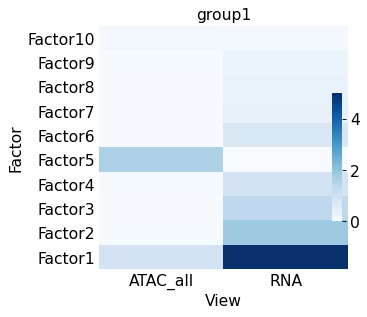

In [174]:
# with only 1 ATAC view 
mfx.plot_r2(model, x='View', 
            vmax=5,
           )

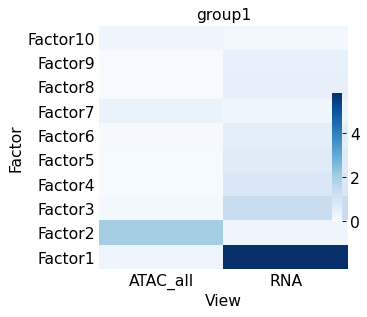

In [263]:
# with only 1 ATAC view - old, without VCT
mfx.plot_r2(model, x='View', 
            #vmax=10,
           )

In [137]:
model.get_r2()


Factor      View   Group        R2
0    Factor1       RNA  group1  7.014686
1    Factor1  ATAC_all  group1  0.928563
2    Factor2       RNA  group1  1.892042
3    Factor2  ATAC_all  group1  0.057942
4    Factor3       RNA  group1  1.358265
5    Factor3  ATAC_all  group1  0.025117
6    Factor4       RNA  group1  0.931376
7    Factor4  ATAC_all  group1  0.079280
8    Factor5       RNA  group1 -0.667727
9    Factor5  ATAC_all  group1  1.606351
10   Factor6       RNA  group1  0.773042
11   Factor6  ATAC_all  group1  0.032121
12   Factor7       RNA  group1  0.385380
13   Factor7  ATAC_all  group1  0.029147
14   Factor8       RNA  group1  0.357318
15   Factor8  ATAC_all  group1  0.028509
16   Factor9       RNA  group1  0.300342
17   Factor9  ATAC_all  group1  0.046998
18  Factor10       RNA  group1  0.109094
19  Factor10  ATAC_all  group1  0.175577

In [126]:
model.features['RNA']

array(['A2M', 'A2ML1', 'A2ML1-AS1', ..., 'ZSWIM6', 'ZWINT', 'ZYG11A'],
      dtype='<U50')

In [127]:
RNA_weights = pd.DataFrame(model.get_weights('RNA'),
                           index = list(model.get_features('RNA')['feature']),
                           columns = ['Factor' + str(i) for i in range(1,11)],
                           )

In [128]:
RNA_weights

Factor1   Factor2   Factor3   Factor4   Factor5   Factor6  \
A2M        0.001503  0.003686  0.033969 -0.000193  0.000443 -0.013401   
A2ML1     -0.003083 -0.000689  0.000795  0.018289  0.001893  0.045848   
A2ML1-AS1 -0.128762  0.032699  0.006681 -0.051920  0.072458  0.065276   
AACS       0.321728  0.050359 -0.003024 -0.228185 -0.076741 -0.026040   
AADAC     -0.001534  0.100761 -0.128032  0.006951  0.001830  0.023678   
...             ...       ...       ...       ...       ...       ...   
ZSCAN9    -0.002221 -0.000369 -0.005410 -0.002299 -0.001930  0.007397   
ZSWIM5    -0.098065  0.005302 -0.106716 -0.016082  0.016884  0.017601   
ZSWIM6    -0.002221  0.002319 -0.014729 -0.000254 -0.017323  0.051113   
ZWINT     -0.081529  0.225321 -0.204313 -0.007160  0.054058 -0.013479   
ZYG11A    -0.109794  0.096094 -0.240715 -0.043862  0.031090 -0.019378   

            Factor7   Factor8   Factor9  Factor10  
A2M       -0.031463 -0.046859  0.003702  0.021130  
A2ML1     -0.003254 -0.020290 -0.002244 -0.007029  
A2ML1-AS1 -0.087660 -0.174053 -0.015724 -0.005350  
AACS       0.250138 -0.004431 -0.353301 -0.005265  
AADAC      0.001793  0.042208  0.016518 -0.007975  
...             ...       ...       ...       ...  
ZSCAN9     0.000361  0.013312 -0.011321  0.086999  
ZSWIM5    -0.000237  0.014706 -0.027350  0.027991  
ZSWIM6    -0.031860  0.013353  0.010607 -0.014804  
ZWINT     -0.002365  0.086490 -0.054333 -0.003225  
ZYG11A     0.024046 -0.079460 -0.071625  0.003760  

[4925 rows x 10 columns]

In [129]:
# eEVT markers seems to pop up here in factor 7!
RNA_weights.loc[['NCAM1','JAG1']]

Factor1   Factor2   Factor3   Factor4   Factor5   Factor6   Factor7  \
NCAM1 -0.002187  0.006515  0.089291  0.006354 -0.096477  0.000236 -0.000397   
JAG1  -0.082935 -0.053643 -0.000168  0.000036 -0.052528 -0.011900 -0.160984   

        Factor8   Factor9  Factor10  
NCAM1  0.001513 -0.003919  0.968775  
JAG1   0.010044  0.012350  0.832495

In [130]:
RNA_weights.loc[['CSF1R','HLA-G','ADAM19']] # invasion seems to be pronounced in factor 9

Factor1   Factor2   Factor3   Factor4   Factor5   Factor6   Factor7  \
CSF1R   0.192793  0.004220 -0.010821  0.582211 -0.000190 -0.328073 -0.214431   
HLA-G   0.388100 -0.000185  0.037398 -0.192551 -0.103856 -0.530367  0.189538   
ADAM19  0.429085  0.000161  0.001444 -0.237013 -0.135083 -0.278414  0.293061   

         Factor8   Factor9  Factor10  
CSF1R   0.000855 -0.290197 -0.010298  
HLA-G  -0.000367  0.124544 -0.000488  
ADAM19 -0.000923 -0.192196  0.001690

In [131]:
RNA_weights[RNA_weights['Factor1'] > np.quantile(RNA_weights['Factor1'],0.99)]

Factor1   Factor2   Factor3   Factor4   Factor5   Factor6  \
AC016831.7  0.401281 -0.003604 -0.000417 -0.410635 -0.085057  0.080881   
ADAM19      0.429085  0.000161  0.001444 -0.237013 -0.135083 -0.278414   
ASAP3       0.442929  0.071218  0.063802 -0.025266 -0.100868  0.108966   
CLNK        0.403869  0.000741 -0.004726 -0.001329 -0.101885  0.033844   
COL27A1     0.457217  0.058236 -0.000322  0.226045 -0.127181 -0.000179   
COL4A1      0.390902  0.046086  0.052469  0.171022 -0.112250 -0.386865   
CORO6       0.433379  0.001630  0.002504 -0.246450 -0.120041  0.062419   
CPED1       0.385981  0.000412 -0.009497 -0.335792 -0.104107  0.141895   
CPM         0.390482 -0.061532 -0.022822 -0.297114 -0.134138 -0.241774   
CSF2RB      0.398774  0.000384  0.022785 -0.248757 -0.104641 -0.306100   
DDX60L      0.411211  0.014389  0.001322  0.091721 -0.109877 -0.062753   
EBI3        0.399602 -0.000958  0.001937 -0.258071 -0.116641 -0.428648   
EXTL3       0.392297 -0.000236 -0.002482 -0.078534 -0.077125 -0.220839   
FGFR1       0.387286  0.104376  0.006764 -0.090274 -0.085723 -0.071975   
FHOD3       0.425690  0.046699 -0.016376 -0.003190 -0.114787  0.226917   
FSTL3       0.391874  0.049491  0.087159  0.171058 -0.096559 -0.489257   
GPR78       0.486152  0.027600  0.042512 -0.043072 -0.160440  0.069296   
HEG1        0.386559  0.034220  0.000121  0.188922 -0.117285 -0.191524   
HIP1        0.418774  0.042356  0.000839 -0.115605 -0.108003  0.000795   
HLA-G       0.388100 -0.000185  0.037398 -0.192551 -0.103856 -0.530367   
HPGD        0.456861  0.030591  0.071707 -0.179371 -0.145216 -0.057245   
HSPG2       0.440157  0.013832  0.055533 -0.236742 -0.133801 -0.286344   
HTRA4       0.449804  0.005533  0.003520  0.098860 -0.136343 -0.237693   
IL1R1       0.400656  0.003030  0.000840 -0.070089 -0.097442 -0.202581   
IL1RAP      0.439738  0.062412  0.005704  0.169186 -0.109446  0.003733   
IL2RB       0.397431 -0.000190 -0.001573 -0.150797 -0.104876 -0.304446   
ISM2        0.401141  0.000378  0.098297 -0.244397 -0.098755 -0.283101   
ITGA1       0.416683  0.000799  0.000361 -0.119873 -0.143754 -0.184789   
ITGA5       0.428668  0.008709  0.034854  0.043166 -0.135066 -0.419296   
KIF21A      0.414835  0.081955 -0.078908 -0.013572 -0.108436  0.090067   
KLHL5       0.409765  0.002405 -0.020220  0.246331 -0.101980 -0.002690   
LHFPL6      0.409721  0.105422 -0.003205 -0.010663 -0.126945  0.077925   
MCAM        0.404933 -0.000341 -0.000273 -0.123815 -0.112495 -0.431397   
MGAT5       0.429429  0.084340 -0.064935 -0.163073 -0.120292  0.023152   
MMP2        0.387464  0.000089  0.021380 -0.000179 -0.120499 -0.647496   
MYCNUT      0.449481  0.060072 -0.000093  0.312929 -0.159000  0.095236   
PDLIM5      0.390334 -0.005559 -0.157359  0.087156 -0.137165  0.021216   
PLAC8       0.413154 -0.000384 -0.002088 -0.054045 -0.113256 -0.093110   
PLXDC2      0.391245 -0.000949 -0.014805 -0.067454 -0.084990 -0.003449   
PRKAG2      0.395258  0.005003  0.001331 -0.334211 -0.088096  0.165028   
PTPRF       0.434988  0.073223  0.124346 -0.078329 -0.123730 -0.127801   
RALBP1      0.390178 -0.000213 -0.120875  0.030859 -0.123579 -0.162821   
RASGRF2     0.466096  0.068868 -0.000097  0.052311 -0.102003  0.131689   
REPS2       0.389181 -0.000050 -0.005866 -0.231750 -0.078312  0.160398   
SERPINE2    0.388323  0.003332  0.061584 -0.315040 -0.138556 -0.471391   
SLC6A2      0.415700  0.004340  0.003189 -0.370665 -0.133881  0.001106   
TIMP2       0.414082  0.003846  0.002029 -0.161801 -0.161457 -0.434575   
TPM1        0.409873  0.131845  0.187272  0.005745 -0.102171 -0.002084   
VGLL3       0.390353  0.012836  0.004115  0.110757 -0.127203 -0.073524   
WIPF1       0.388739  0.060618 -0.006364  0.249076 -0.096750  0.123716   

             Factor7   Factor8   Factor9  Factor10  
AC016831.7 -0.155069 -0.002791 -0.094531 -0.011013  
ADAM19      0.293061 -0.000923 -0.192196  0.001690  
ASAP3       0.153753  0.007900  0.008329 -0.048978  
CLNK       -0.078385 -0.02

In [132]:
RNA_weights[RNA_weights['Factor2'] > np.quantile(RNA_weights['Factor2'],0.99)]

Factor1   Factor2   Factor3   Factor4   Factor5   Factor6  \
AC016205.1 -0.139750  0.523648 -0.502413  0.078916  0.074113  0.083443   
AC091057.6 -0.158046  0.456852 -0.405308  0.006164  0.073179  0.046298   
ANLN       -0.151861  0.417141 -0.454319 -0.060037  0.050878 -0.005094   
ARHGAP11A  -0.125765  0.359205 -0.251971 -0.000638  0.079705  0.000502   
ASPM       -0.183970  0.390802 -0.363325 -0.006469  0.111594 -0.001438   
ATAD2      -0.186427  0.425775 -0.379639  0.012397  0.058490  0.018648   
BLM        -0.150918  0.398865 -0.419786 -0.058657  0.067993 -0.001509   
BRIP1      -0.131364  0.457579 -0.437136  0.126430  0.042792  0.039501   
BUB1B      -0.150358  0.401764 -0.428345 -0.090848  0.044523 -0.002028   
CDK1       -0.173076  0.410161 -0.408184 -0.087566  0.102277 -0.073172   
CENPE      -0.115992  0.372620 -0.313192  0.133363  0.103924  0.013467   
CENPF      -0.170336  0.382087 -0.136729  0.002794  0.139975 -0.000129   
CENPK      -0.141942  0.379900 -0.461734  0.016630  0.027690  0.011489   
CENPP      -0.182564  0.408203 -0.525913  0.001488  0.040347  0.041612   
CEP128     -0.089439  0.413081 -0.401968  0.104632  0.053754  0.060158   
CIP2A      -0.133879  0.365783 -0.415130 -0.039918  0.036986  0.012688   
CIT        -0.142126  0.447290 -0.404085 -0.000636  0.048677  0.009753   
DIAPH3     -0.190938  0.428327 -0.503954  0.084335  0.077298  0.041734   
DNA2       -0.128946  0.375234 -0.385628 -0.000394  0.053217  0.005407   
ECT2       -0.182499  0.416181 -0.354421 -0.001676  0.077149  0.002711   
ERVMER61-1 -0.157048  0.376518 -0.538776 -0.003911  0.008781 -0.001407   
EXO1       -0.106409  0.383820 -0.337702  0.071975  0.001711  0.035006   
EZH2       -0.192417  0.399347 -0.302861 -0.004394  0.095833  0.016365   
FANCI      -0.157031  0.395930 -0.503408  0.003172  0.065234 -0.005951   
GTSE1      -0.151133  0.403367 -0.289487 -0.063135  0.097918  0.000593   
KIF11      -0.121464  0.391594 -0.394394 -0.000562  0.016310  0.002621   
KIF15      -0.138798  0.357833 -0.366427 -0.009024  0.082000  0.004153   
KIF18B     -0.128165  0.402139 -0.381294  0.001115  0.065792  0.005211   
KIF23      -0.153346  0.361417 -0.210892 -0.000766  0.083834  0.038070   
KIF4A      -0.130683  0.382124 -0.419833 -0.003658  0.071103 -0.001778   
KNL1       -0.163858  0.390483 -0.430824  0.000234  0.075065 -0.000085   
LMNB1      -0.181618  0.371527 -0.260936 -0.000944  0.074850  0.002255   
MCM10      -0.145994  0.383723 -0.262350  0.001434  0.076411 -0.002400   
MELK       -0.066694  0.435309 -0.411323  0.123083  0.006891  0.003389   
MKI67      -0.152516  0.419472 -0.260876  0.009652  0.087410 -0.001247   
MND1       -0.151129  0.383253 -0.396488 -0.105488  0.064651 -0.004288   
NCAPG      -0.125891  0.418007 -0.381821  0.006811  0.027144  0.002223   
NDC80      -0.110653  0.357776 -0.373196 -0.008258  0.012226 -0.001077   
NEIL3      -0.125381  0.355544 -0.419966 -0.062471  0.053115 -0.009818   
NUSAP1     -0.149231  0.400217 -0.302497 -0.005225  0.063310  0.000897   
POLQ       -0.175636  0.478168 -0.480758 -0.025043  0.055416  0.001632   
RACGAP1    -0.114221  0.360991 -0.373893  0.010280  0.056537 -0.003364   
RRM1       -0.167050  0.356971 -0.283583 -0.003377  0.087162 -0.003887   
SMC4       -0.175833  0.421254 -0.380822  0.050332  0.092777 -0.000087   
TACC3      -0.162138  0.378012 -0.217449 -0.093714  0.107026 -0.002936   
TICRR      -0.108297  0.381826 -0.395961  0.028124  0.021119  0.012543   
TMPO       -0.044785  0.366043 -0.351447  0.107572  0.043837 -0.105968   
TOP2A      -0.177632  0.424778 -0.314811 -0.011131  0.117896 -0.070765   
TPX2       -0.156023  0.377235 -0.288512  0.015378  0.131955 -0.002683   
VRK1       -0.157095  0.358942 -0.414160  0.005714  0.087421  0.002029   

             Factor7   Factor8   Factor9  Factor10  
AC016205.1 -0.023081 -0.031403  0.178271 -0.008519  
AC091057.6  0.001449 -0.585676 -0.004023 -0.008544  
ANLN       -0.185237 -0.537660 -0.009994  0.014645  
ARHGAP11A  -0.025391 -0.58

In [133]:
# previously JAG1 and NCAM1 came up in factor3 for previous version of cellatac analysis... now they don't
RNA_weights[RNA_weights['Factor7'] > np.quantile(RNA_weights['Factor7'],0.99)]

Factor1   Factor2   Factor3   Factor4   Factor5   Factor6  \
AC100802.1  0.265394 -0.000564 -0.008356 -0.185193 -0.018339  0.001198   
ADAM19      0.429085  0.000161  0.001444 -0.237013 -0.135083 -0.278414   
ADAP2       0.047946 -0.083385 -0.002570  0.465831  0.000536 -0.216206   
ADGRG6      0.238550 -0.055169 -0.092241  0.354865 -0.073765 -0.129199   
AFAP1       0.365456  0.103040 -0.105407  0.238377 -0.053667  0.026950   
AL356515.1  0.266972  0.000943 -0.000371 -0.231645 -0.065225  0.200986   
APBB1IP     0.196067  0.068985 -0.023353  0.206884 -0.008324  0.001647   
CCNE1       0.273526  0.175150  0.058794  0.045120 -0.055116 -0.173398   
CCNYL1      0.120626  0.000552 -0.095886  0.053475 -0.000695  0.000080   
CSGALNACT1  0.306408  0.011591 -0.005000  0.225359 -0.049439  0.005913   
DHRS3       0.344279 -0.016366 -0.003391 -0.155404 -0.086229 -0.004505   
DOPEY2      0.333640  0.059852 -0.031480  0.072492 -0.059086  0.175550   
FAM110B     0.296950  0.015648 -0.008455  0.256158 -0.034279  0.101204   
FAT2        0.384515  0.000570 -0.007304 -0.095711 -0.082346 -0.166604   
FES         0.144381  0.003801  0.002407 -0.225024 -0.053386  0.030327   
FHOD3       0.425690  0.046699 -0.016376 -0.003190 -0.114787  0.226917   
GRB2        0.199333  0.066234 -0.000617  0.274913  0.003959  0.001512   
HAPLN3      0.265545  0.017606 -0.043501  0.356690 -0.047740 -0.210631   
HTRA4       0.449804  0.005533  0.003520  0.098860 -0.136343 -0.237693   
HUNK        0.315721  0.108423 -0.190003 -0.232080 -0.086726  0.018550   
KCNQ1OT1    0.098329 -0.066218 -0.020466  0.142877  0.075535  0.171535   
LIFR        0.367708  0.017926  0.018803 -0.003515 -0.117648  0.124653   
LIFR-AS1    0.191232  0.001668 -0.009193 -0.015750 -0.069155  0.226860   
LINC01876  -0.130064 -0.055701 -0.224633  0.153663  0.075969  0.102624   
LINC02428   0.314860 -0.000233 -0.013484 -0.016313 -0.061843 -0.000704   
LYN         0.310016  0.038832 -0.019120 -0.114955 -0.022138 -0.006957   
MAMDC2      0.304269  0.000062  0.000426 -0.178534 -0.101145 -0.355572   
MAMDC2-AS1  0.195351 -0.003414 -0.061668 -0.143178 -0.050672 -0.139413   
MRLN        0.255259 -0.000066 -0.007766  0.003605 -0.063570 -0.063954   
MYCN        0.296923  0.062911  0.000995  0.344325 -0.040752 -0.004284   
MYCNOS      0.336057  0.031334 -0.021438  0.311313 -0.108165  0.137652   
PAG1        0.324034  0.003020 -0.020425  0.078209 -0.064272 -0.004949   
PAPLN       0.167893  0.000445  0.000358 -0.093054 -0.044482 -0.136316   
PARD6G      0.191149  0.059716 -0.022732  0.012682 -0.073982 -0.004602   
PDE4B      -0.349556 -0.011495 -0.197395  0.116251  0.162673  0.040226   
PDE6H       0.219489  0.000471 -0.001324 -0.288602 -0.057686  0.003665   
PLXDC2      0.391245 -0.000949 -0.014805 -0.067454 -0.084990 -0.003449   
RNF144B     0.096179 -0.071931 -0.109810 -0.290240  0.000022  0.005978   
SCUBE1      0.267599  0.000115 -0.001117  0.239795 -0.078982 -0.338430   
SLC16A9     0.153953 -0.016008 -0.013874  0.242511 -0.000270 -0.280855   
SLC6A11     0.174663  0.102725 -0.003683 -0.039298  0.000744  0.009885   
SLCO2B1     0.243830 -0.000047 -0.011181  0.276550 -0.017414 -0.002015   
SLCO4A1     0.264913  0.042486 -0.000187  0.385572 -0.005653 -0.231081   
SNTB1       0.183032 -0.043588 -0.145407 -0.015267 -0.036688  0.072912   
SPATA9      0.221994 -0.004121 -0.096124  0.266979 -0.067339  0.145380   
TACR3       0.228199 -0.000197 -0.050815 -0.001223 -0.043367  0.014642   
TET3        0.307351  0.093214 -0.140351  0.192280 -0.055086  0.082933   
TGFBR2      0.221085 -0.110634 -0.128279 -0.198969 -0.046227 -0.130724   
TIAM2       0.183129 -0.000566 -0.139517 -0.112410 -0.001520  0.098867   
TTC39C      0.193173  0.001800 -0.005834  0.178316 -0.014928  0.027541   

             Factor7   Factor8   Factor9  Factor10  
AC100802.1  0.373555  0.000664 -0.276073 -0.111436  
ADAM19      0.293061 -0.000923 -0.192196  0.001690  
ADAP2       0.319405  0.002052 -0.380582  0.291890  
ADGRG6      0.333504  0.01

In [134]:
atac_views_keys = ['ATAC_all']

In [135]:
ATAC_weights = {}


for key in ['ATAC_all']: #['ATAC_exon', 'ATAC_intergenic', 'ATAC_intron', 'ATAC_promoter', 'ATAC_primed_enhancers', 'ATAC_active_enhancers', 'ATAC_repressed_enhancers']: #['ATAC_all']:
    print(key)
    ATAC_weights[key] = pd.DataFrame(model.get_weights(key),
                           index = list(model.get_features(key)['feature']),
                           columns = ['Factor' + str(i) for i in range(1,11)],
                           )

ATAC_all


In [136]:
ATAC_weights['ATAC_all']

Factor1   Factor2   Factor3   Factor4   Factor5  \
chr1:999901-1000393       0.021972 -0.002206  0.006699  0.014004  0.095256   
chr1:1019192-1019792      0.022885 -0.000070 -0.001551  0.014184  0.126844   
chr1:1073233-1074498      0.076824  0.062108  0.026969  0.046422  0.104564   
chr1:1079363-1080404      0.075861  0.009298 -0.008317  0.012773  0.110339   
chr1:1115778-1116666      0.001281  0.009092 -0.012297  0.018624  0.156804   
...                            ...       ...       ...       ...       ...   
chrX:154719165-154719708  0.069933 -0.002228 -0.005659  0.001297  0.000017   
chrX:154805075-154805684 -0.036522 -0.004526 -0.001615  0.000196  0.019909   
chrX:154805785-154806070 -0.004101 -0.001407 -0.002678 -0.003022  0.034212   
chrX:155026470-155027451  0.017082 -0.000172  0.040572 -0.000223  0.142277   
chrX:155070780-155071828 -0.000610 -0.010886 -0.007174  0.000359  0.137544   

                           Factor6   Factor7   Factor8   Factor9  Factor10  
chr1:999901-1000393      -0.006901 -0.001335  0.003311 -0.014631 -0.013661  
chr1:1019192-1019792     -0.002182  0.030693 -0.004817  0.010640 -0.032377  
chr1:1073233-1074498      0.009809 -0.043817 -0.016851 -0.006142  0.001124  
chr1:1079363-1080404     -0.013114 -0.002638  0.004088 -0.014389  0.050362  
chr1:1115778-1116666     -0.004518  0.015393 -0.010867 -0.007142  0.007841  
...                            ...       ...       ...       ...       ...  
chrX:154719165-154719708 -0.018895  0.004122 -0.005270  0.008012  0.042709  
chrX:154805075-154805684 -0.001888  0.008267  0.004334  0.002819  0.108959  
chrX:154805785-154806070  0.001963  0.020829 -0.011322 -0.004830  0.106529  
chrX:155026470-155027451 -0.001065 -0.029132 -0.000444  0.003345 -0.013232  
chrX:155070780-155071828 -0.009297  0.040064  0.008945  0.011079  0.004114  

[10640 rows x 10 columns]

In [166]:
mdata.obsm['X_mofa'].shape


(1605, 10)

In [167]:
mdata.obs.columns

Index(['ATAC_all:cellatac_code', 'ATAC_all:sample', 'ATAC_all:barcode',
       'ATAC_all:donor', 'ATAC_all:annot_multiome_combined',
       'ATAC_all:n_genes_by_counts', 'ATAC_all:log1p_n_genes_by_counts',
       'ATAC_all:total_counts', 'ATAC_all:log1p_total_counts',
       'ATAC_all:pct_counts_in_top_50_genes',
       'ATAC_all:pct_counts_in_top_100_genes',
       'ATAC_all:pct_counts_in_top_200_genes',
       'ATAC_all:pct_counts_in_top_500_genes', 'ATAC_all:age',
       'ATAC_all:tissue', 'ATAC_all:technology', 'ATAC_all:celltype',
       'RNA:n_genes', 'RNA:donor', 'RNA:tissue_block', 'RNA:age', 'RNA:sample',
       'RNA:percent_mito', 'RNA:n_counts', 'RNA:dataset', 'RNA:technique',
       'RNA:scrublet_score', 'RNA:scrublet_cluster_score', 'RNA:bh_pval',
       'RNA:batch', 'RNA:is_doublet', 'RNA:barcode_sample_copy', 'RNA:barcode',
       'RNA:souporcell_assignment', 'RNA:inter_ind_doublet', 'RNA:S_score',
       'RNA:G2M_score', 'RNA:phase', 'RNA:annotation_prev', 'RNA:louvain'

In [168]:
mdata.obs['RNA:celltype']

AGCTTCCTCATTACTC-1_Pla_Camb10714919_and_40110_Pla_Camb10687915        VCT
GGAAGTATCGAGCAAA-1_Pla_Camb10714919_and_40110_Pla_Camb10687915         GC
CCAACCCGTTTGGTTC-1_Pla_Camb10714920_and_40110_Pla_Camb10687916    VCT_CCC
TGTAAAGCATAGACCC-1_Pla_Camb10714919_and_40110_Pla_Camb10687915      EVT_2
AAGCCTTAGGACCTGC-1_Pla_Camb10714919_and_40110_Pla_Camb10687915       iEVT
                                                                   ...   
GTAGTTATCGATATTG-1_Pla_Camb10714919_and_40110_Pla_Camb10687915       iEVT
ATCCCGCGTCGACTAA-1_Pla_Camb10714920_and_40110_Pla_Camb10687916      EVT_2
ATCCCGCGTGTTAAAC-1_Pla_Camb10714920_and_40110_Pla_Camb10687916        VCT
CTATGACAGGGACGCA-1_Pla_Camb10714919_and_40110_Pla_Camb10687915    VCT_CCC
CTAACCCTCTGTTCAT-1_Pla_Camb10714919_and_40110_Pla_Camb10687915    VCT_CCC
Name: RNA:celltype, Length: 1605, dtype: category
Categories (7, object): ['EVT_1', 'EVT_2', 'GC', 'VCT', 'VCT_CCC', 'eEVT', 'iEVT']

In [146]:
mdata['RNA'].obs.loc[list(adata_rna_sub.obs.index),'celltype']

barcode_sample
AGCTTCCTCATTACTC-1_Pla_Camb10714919_and_40110_Pla_Camb10687915        VCT
GGAAGTATCGAGCAAA-1_Pla_Camb10714919_and_40110_Pla_Camb10687915         GC
CCAACCCGTTTGGTTC-1_Pla_Camb10714920_and_40110_Pla_Camb10687916    VCT_CCC
TGTAAAGCATAGACCC-1_Pla_Camb10714919_and_40110_Pla_Camb10687915      EVT_2
AAGCCTTAGGACCTGC-1_Pla_Camb10714919_and_40110_Pla_Camb10687915       iEVT
                                                                   ...   
GTAGTTATCGATATTG-1_Pla_Camb10714919_and_40110_Pla_Camb10687915       iEVT
ATCCCGCGTCGACTAA-1_Pla_Camb10714920_and_40110_Pla_Camb10687916      EVT_2
ATCCCGCGTGTTAAAC-1_Pla_Camb10714920_and_40110_Pla_Camb10687916        VCT
CTATGACAGGGACGCA-1_Pla_Camb10714919_and_40110_Pla_Camb10687915    VCT_CCC
CTAACCCTCTGTTCAT-1_Pla_Camb10714919_and_40110_Pla_Camb10687915    VCT_CCC
Name: celltype, Length: 1605, dtype: category
Categories (7, object): ['EVT_1', 'EVT_2', 'GC', 'VCT', 'VCT_CCC', 'eEVT', 'iEVT']

In [169]:
list(mdata['RNA'].obs.loc[list(adata_rna_sub.obs.index),'celltype']) == list(adata_rna_sub.obs['celltype'])

True

In [170]:
adata_rna_sub.obs

n_genes donor  \
barcode_sample                                                      
AGCTTCCTCATTACTC-1_Pla_Camb10714919_and_40110_P...     5884   P13   
GGAAGTATCGAGCAAA-1_Pla_Camb10714919_and_40110_P...     6012   P13   
CCAACCCGTTTGGTTC-1_Pla_Camb10714920_and_40110_P...     1244   P13   
TGTAAAGCATAGACCC-1_Pla_Camb10714919_and_40110_P...     2485   P13   
AAGCCTTAGGACCTGC-1_Pla_Camb10714919_and_40110_P...     5441   P13   
...                                                     ...   ...   
GTAGTTATCGATATTG-1_Pla_Camb10714919_and_40110_P...     6328   P13   
ATCCCGCGTCGACTAA-1_Pla_Camb10714920_and_40110_P...     1769   P13   
ATCCCGCGTGTTAAAC-1_Pla_Camb10714920_and_40110_P...     2845   P13   
CTATGACAGGGACGCA-1_Pla_Camb10714919_and_40110_P...     2281   P13   
CTAACCCTCTGTTCAT-1_Pla_Camb10714919_and_40110_P...     5630   P13   

                                                   tissue_block      age  \
barcode_sample                                                             
AGCTTCCTCATTACTC-1_Pla_Camb10714919_and_40110_P...      unknown  8-9_PCW   
GGAAGTATCGAGCAAA-1_Pla_Camb10714919_and_40110_P...      unknown  8-9_PCW   
CCAACCCGTTTGGTTC-1_Pla_Camb10714920_and_40110_P...      unknown  8-9_PCW   
TGTAAAGCATAGACCC-1_Pla_Camb10714919_and_40110_P...      unknown  8-9_PCW   
AAGCCTTAGGACCTGC-1_Pla_Camb10714919_and_40110_P...      unknown  8-9_PCW   
...                                                         ...      ...   
GTAGTTATCGATATTG-1_Pla_Camb10714919_and_40110_P...      unknown  8-9_PCW   
ATCCCGCGTCGACTAA-1_Pla_Camb10714920_and_40110_P...      unknown  8-9_PCW   
ATCCCGCGTGTTAAAC-1_Pla_Camb10714920_and_40110_P...      unknown  8-9_PCW   
CTATGACAGGGACGCA-1_Pla_Camb10714919_and_40110_P...      unknown  8-9_PCW   
CTAACCCTCTGTTCAT-1_Pla_Camb10714919_and_40110_P...      unknown  8-9_PCW   

                                                                                         sample  \
barcode_sample                                                                                    
AGCTTCCTCATTACTC-1_Pla_Camb10714919_and_40110_P...  Pla_Camb10714919_and_40110_Pla_Camb10687915   
GGAAGTATCGAGCAAA-1_Pla_Camb10714919_and_40110_P...  Pla_Camb10714919_and_40110_Pla_Camb10687915   
CCAACCCGTTTGGTTC-1_Pla_Camb10714920_and_40110_P...  Pla_Camb10714920_and_40110_Pla_Camb10687916   
TGTAAAGCATAGACCC-1_Pla_Camb10714919_and_40110_P...  Pla_Camb10714919_and_40110_Pla_Camb10687915   
AAGCCTTAGGACCTGC-1_Pla_Camb10714919_and_40110_P...  Pla_Camb10714919_and_40110_Pla_Camb10687915   
...                                                                                         ...   
GTAGTTATCGATATTG-1_Pla_Camb10714919_and_40110_P...  Pla_Camb10714919_and_40110_Pla_Camb10687915   
ATCCCGCGTCGACTAA-1_Pla_Camb10714920_and_40110_P...  Pla_Camb10714920_and_40110_Pla_Camb10687916   
ATCCCGCGTGTTAAAC-1_Pla_Camb10714920_and_40110_P...  Pla_Camb10714920_and_40110_Pla_Camb10687916   
CTATGACAGGGACGCA-1_Pla_Camb10714919_and_40110_P...  Pla_Camb10714919_and_40110_Pla_Camb10687915   
CTAACCCTCTGTTCAT-1_Pla_Camb10714919_and_40110_P...  Pla_Camb10714919_and_40110_Pla_Camb10687915   

                                                    percent_mito  n_counts  \
barcode_sample                                                               
AGCTTCCTCATTACTC-1_Pla_Camb10714919_and_40110_P...      0.017595   19892.0   
GGAAGTATCGAGCAAA-1_Pla_Camb10714919_and_40110_P...      0.015620   30153.0   
CCAACCCGTTTGGTTC-1_Pla_Camb10714920_and_40110_P...      0.013176    2125.0   
TGTAAAGCATAGACCC-1_Pla_Camb10714919_and_40110_P...      0.008072    5203.0   
AAGCCTTAGGACCTGC-1_Pla_Camb10714919_and_40110_P...      0.007957   25889.0   
...                                                          ...       ...   
GTAGTTATCGATATTG-1_Pla_Camb10714919_and_40110_P...      0.017822   29514.0   
ATCCCGCGTCGACTAA-1_Pla_Camb10714920_and_40110_P...      0.005594    3218.0   
ATCCCGCGTGTTAAAC-1_Pla_Camb10714920_and_40110_P...      0.006278    5416.0   
CTATGACAGGGACGCA-1_

In [171]:
# below are plots for model with 1 ATAC view

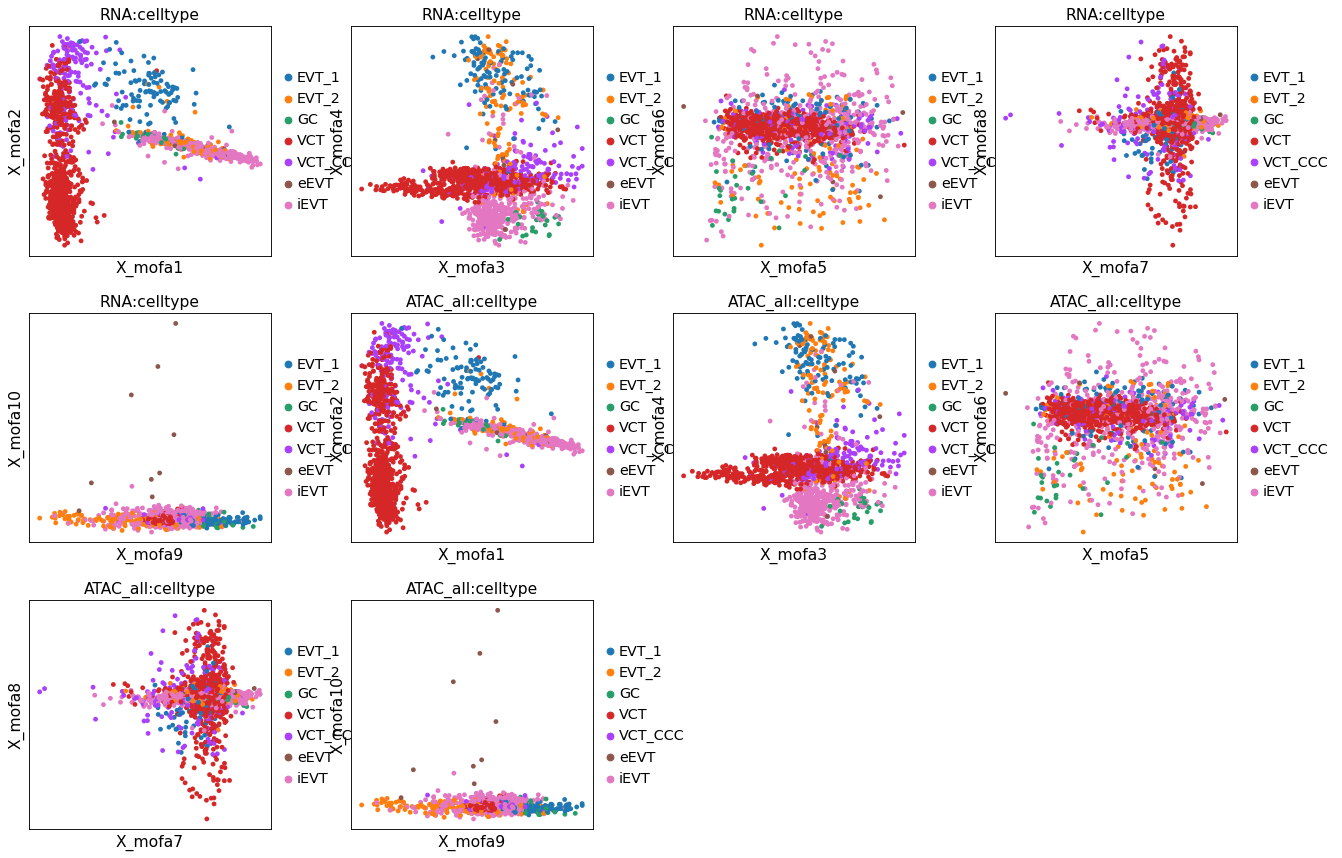

In [175]:
mu.pl.mofa(mdata, 
           color=["RNA:celltype", 
                  "ATAC_all:celltype"
                 ], components=["1,2", "3,4",'5,6','7,8','9,10'])

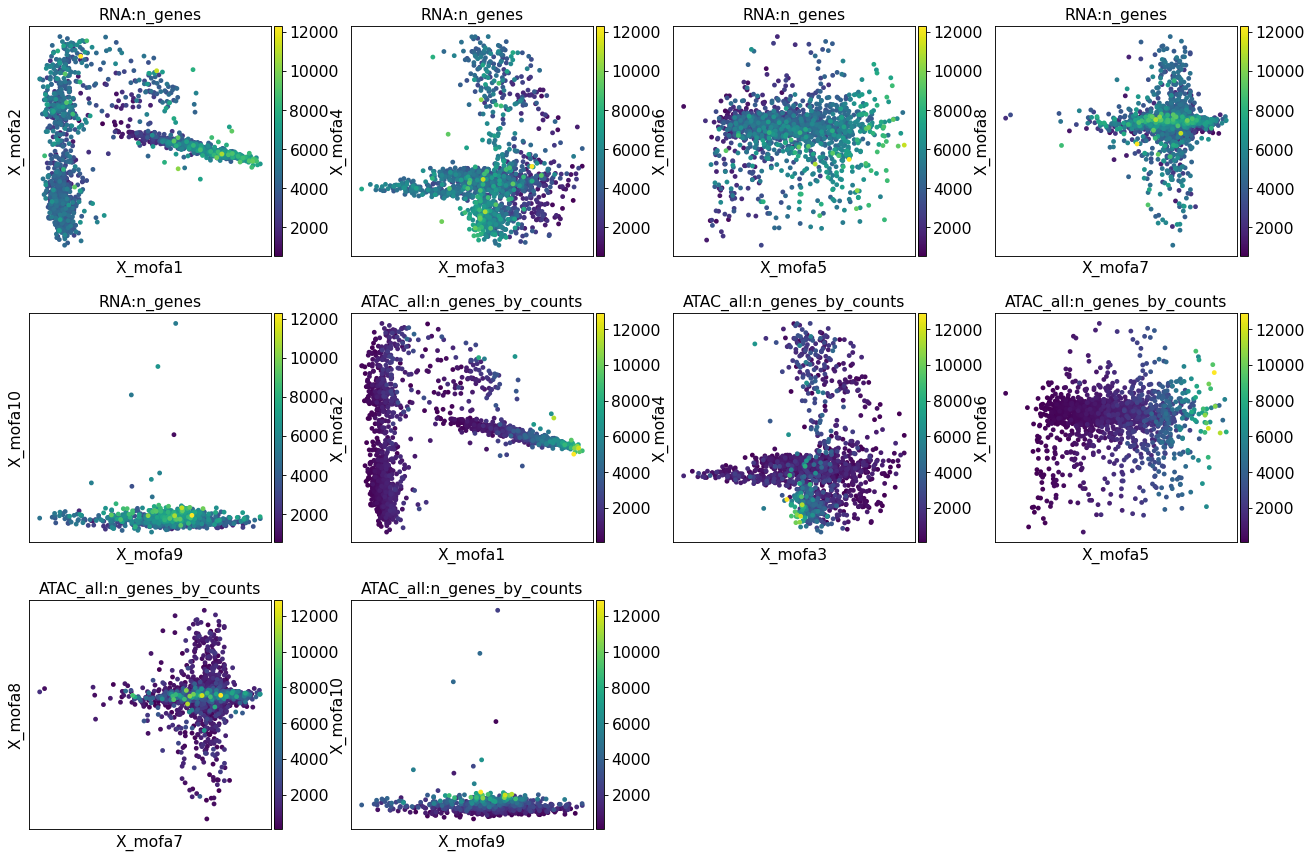

In [47]:
mu.pl.mofa(mdata, color=["RNA:n_genes", "ATAC_all:n_genes_by_counts"], components=["1,2", "3,4","5,6","7,8","9,10"])

In [176]:
# UMAP based on MOFA factors
sc.pp.neighbors(mdata, use_rep="X_mofa")
sc.tl.umap(mdata)

... storing 'ATAC_all:annotation' as categorical
... storing 'ATAC_all:gene_name' as categorical
... storing 'ATAC_all:gene_id' as categorical
... storing 'RNA:gene_ids-0' as categorical
... storing 'RNA:feature_types-0' as categorical
... storing 'RNA:genome-0' as categorical
... storing 'RNA:gene_ids-1' as categorical
... storing 'RNA:feature_types-1' as categorical
... storing 'RNA:genome-1' as categorical
... storing 'RNA:gene_ids-2' as categorical
... storing 'RNA:feature_types-2' as categorical
... storing 'RNA:genome-2' as categorical
... storing 'RNA:gene_ids-3' as categorical
... storing 'RNA:feature_types-3' as categorical
... storing 'RNA:genome-3' as categorical
... storing 'RNA:gene_ids-4' as categorical
... storing 'RNA:feature_types-4' as categorical
... storing 'RNA:genome-4' as categorical
... storing 'RNA:gene_ids-5' as categorical
... storing 'RNA:feature_types-5' as categorical
... storing 'RNA:genome-5' as categorical
... storing 'RNA:gene_ids-6' as categorical
...

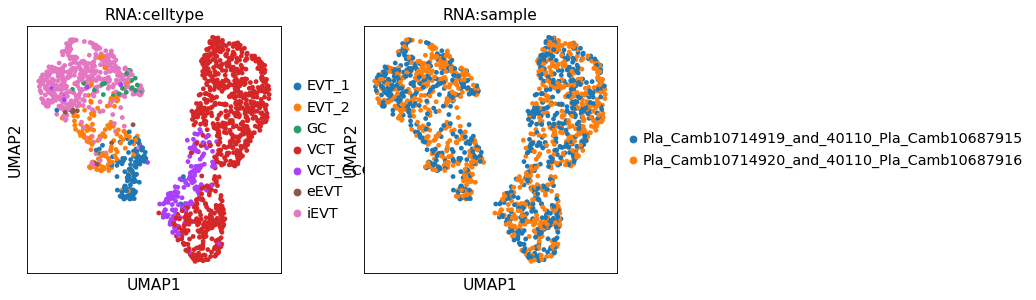

In [177]:
sc.pl.umap(mdata, color=["RNA:celltype", "RNA:sample"], ncols=2, 
           #save='_MOFA_based_UMAP_celltype_sample.pdf'
          )

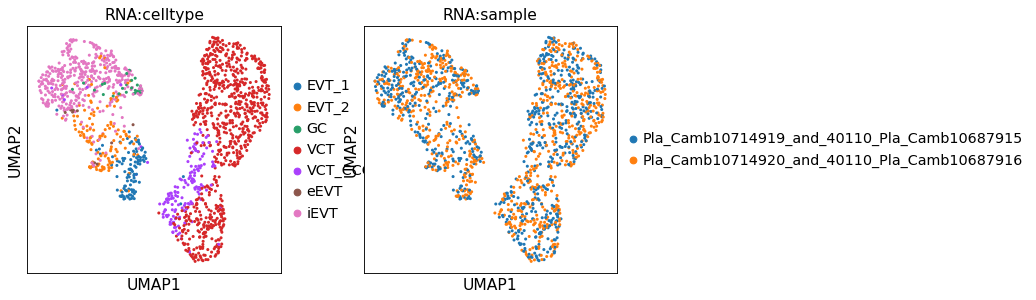

In [178]:
sc.pl.umap(mdata, color=["RNA:celltype", 
                         "RNA:sample"], ncols=2, 
           size=30,
           #save='_MOFA_based_UMAP_celltype_sample.pdf'
          )

In [179]:
mdata

MuData object with n_obs × n_vars = 1605 × 15565
  var:	'highly_variable', 'mean', 'std'
  obsm:	'X_mofa', 'X_umap'
  varm:	'LFs'
  obsp:	'distances', 'connectivities'
  2 modalities
    ATAC_all:	1605 x 10640
      obs:	'cellatac_code', 'sample', 'barcode', 'donor', 'annot_multiome_combined', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'age', 'tissue', 'technology', 'celltype'
      var:	'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'contains_primed_enhancers', 'contains_active_enhancers', 'contains_repressed_enhancers', 'highly_variable', 'mean', 'std'
      uns:	'age_colors', 'annot_multiome_combined_colors', 'celltype_colors', 'donor_colors', 'neighbors', 'sample_colors', 'technology_colors', 'tissue_colors', 'umap'
      obsm:	'X_cistopic_50', 'X_umap'
      varm:	'peak2gene'
      layers:	'binary_raw'
      obsp:	'connectivities', 'distances'
    RNA:	1605 x 4925
      obs:	'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'barcode_sample_copy', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'annotation_prev', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'annotation_prev_or_removed', 'inv_troph_labels_initial', 'louvain_scvi_n_latent_8', 'final_annot_inv_troph', 'louvain_scvi_troph_rest', 'final_annot_all_troph', 'final_annot_inv_troph_corrected', 'final_annot_all_troph_corrected', 'technology', 'celltype', 'celltype_from_mdata'
      var:	'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'celltype_colors', 'donor_colors', 'final_annot_all_troph_corrected_colors', 'hvg', 'technology_colors'
      obsm:	'X_umap_scVI_n_latent_8_sample'

In [42]:
# also getting to a manifold where we ignore factor 1 that seems to be mainly ATAC-QC-driven


In [180]:
# factor weight per cell
mdata.obsm["X_mofa"].shape

(1605, 10)

In [181]:
len(mdata.obsm["X_mofa"][:,0])

1605

In [182]:
# corr with mdata.obs['ATAC_all:n_genes_by_counts']

for n_factor in range(1,11):
    print(n_factor)
    curr_factor_weights = list(mdata.obsm["X_mofa"][:, n_factor-1])
    curr_n_genes_by_counts = list(mdata.obs['ATAC_all:n_genes_by_counts'])
    
    curr_corr = scipy.stats.spearmanr(curr_factor_weights, curr_n_genes_by_counts)
    curr_corr_R = curr_corr[0]
    curr_pval = curr_corr[1]
    
    if (curr_pval < 0.05) & (curr_corr_R > 0):
        print('found correlation with ATAC_all:n_genes_by_counts', curr_corr_R)
    
    

1
found correlation with ATAC_all:n_genes_by_counts 0.7244893806464485
2
found correlation with ATAC_all:n_genes_by_counts 0.11438282091143964
3
4
5
found correlation with ATAC_all:n_genes_by_counts 0.942100461806437
6
7
8
9
10
found correlation with ATAC_all:n_genes_by_counts 0.6210450980542834


In [13]:
# df with correlations of factor weights and ATAC_all:n_genes_by_counts
corr_df = pd.DataFrame(index = np.unique(mdata.obs['RNA:celltype']),
                      columns = ['Factor' + str(i+1) for i in range(0,10)])

In [14]:
# also doing the same thing per cell type

for ct in np.unique(mdata.obs['RNA:celltype']):
    curr_subdata = mdata[mdata.obs['RNA:celltype'] == ct]
    print(ct)
    
    for n_factor in range(1,11):
        print(n_factor)
        curr_factor_weights = list(curr_subdata.obsm["X_mofa"][:, n_factor-1])
        curr_n_genes_by_counts = list(curr_subdata.obs['ATAC_all:n_genes_by_counts'])

        curr_corr = scipy.stats.spearmanr(curr_factor_weights, curr_n_genes_by_counts)
        curr_corr_R = curr_corr[0]
        curr_pval = curr_corr[1]

        if (curr_pval < 0.05) & (curr_corr_R > 0.7):
            print('found correlation with ATAC_all:n_genes_by_counts', curr_corr_R)
            corr_df.loc[ct, 'Factor' + str(n_factor)] = curr_corr_R
        else:
            corr_df.loc[ct, 'Factor' + str(n_factor)] = 0
    print('\n')



EVT_1
1
found correlation with ATAC_all:n_genes_by_counts 0.7448396084677545
2
3
4
5
found correlation with ATAC_all:n_genes_by_counts 0.9858476545091208
6
7
8
9
10


EVT_2
1
found correlation with ATAC_all:n_genes_by_counts 0.8683363148479427
2
3
4
5
found correlation with ATAC_all:n_genes_by_counts 0.9830067323055073
6
7
8
9
10
found correlation with ATAC_all:n_genes_by_counts 0.7779841319695749


GC
1
found correlation with ATAC_all:n_genes_by_counts 0.8960591133004924
2
3
4
5
found correlation with ATAC_all:n_genes_by_counts 0.9866995073891623
6
7
8
9
10
found correlation with ATAC_all:n_genes_by_counts 0.7532019704433496


VCT
1
2
3
4
5
found correlation with ATAC_all:n_genes_by_counts 0.9868178432732436
6
7
8
9
10


VCT_CCC
1
2
3
4
5
found correlation with ATAC_all:n_genes_by_counts 0.9774808890723279
6
7
8
9
10


eEVT
1
found correlation with ATAC_all:n_genes_by_counts 0.8833333333333333
2
3
4
5
found correlation with ATAC_all:n_genes_by_counts 0.9166666666666666
6
7
8
9
10


iE

In [16]:
corr_df = corr_df.astype(float)

In [18]:
corr_df = corr_df.loc[['VCT_CCC','EVT_1','EVT_2','iEVT','GC','eEVT'],:]

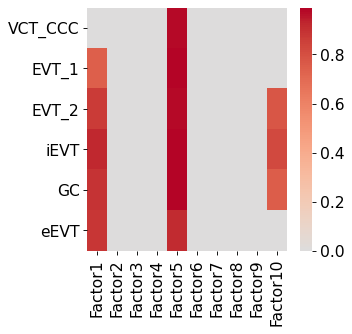

In [20]:
sns.heatmap(corr_df, cmap='coolwarm', center=0)
plt.savefig('./figures/20220215_corr_of_MEFISTO_factors_with_ATAC_all:n_genes_by_counts.pdf',
           bbox_inches='tight')

<AxesSubplot:xlabel='Smoothness', ylabel='Factor'>

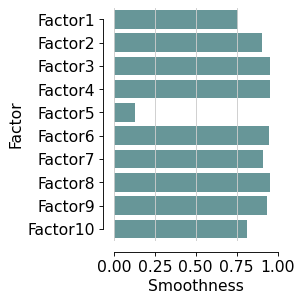

In [184]:
mfx.plot_smoothness(model)

In [9]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

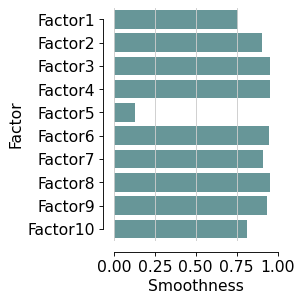

In [10]:
mfx.plot_smoothness(model)
plt.savefig('./figures/20220215_plot_smoothness_final_model.pdf')

In [185]:
# trying to redo the umap without factor 5 aka with index 4 in a python matrix

In [186]:
mdata.obsm['X_mofa'][:,[0,1,2,3,5,6,7,8,9]]

array([[-2.0562518 , -1.4895515 ,  0.55925083, ..., -0.13477103,
        -0.03984737, -0.05412919],
       [-1.4734516 ,  1.5175633 , -2.3260512 , ...,  1.4059056 ,
        -0.15271069,  0.07057329],
       [ 1.7865257 ,  0.12825087,  0.62174153, ..., -0.0363022 ,
        -0.83302337, -0.09488065],
       ...,
       [-1.8841873 , -1.9743074 , -1.0472622 , ...,  0.08861218,
         0.0958832 , -0.119697  ],
       [-1.3700093 ,  0.11284205,  0.9400662 , ...,  0.56025034,
        -0.09488616, -0.07153607],
       [-1.265812  , -1.626711  , -0.1312345 , ..., -0.00687388,
         0.05057646, -0.0682257 ]], dtype=float32)

In [187]:
mdata.obsm['X_mofa_no_factor_5'] = mdata.obsm['X_mofa'][:,[0,1,2,3,5,6,7,8,9]]

In [188]:
# UMAP based on MOFA factors
sc.pp.neighbors(mdata, use_rep="X_mofa_no_factor_5", key_added='neighbors_no_factor_5')
sc.tl.umap(mdata, neighbors_key='neighbors_no_factor_5')

In [189]:
mdata['RNA']

AnnData object with n_obs × n_vars = 1605 × 4925
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'barcode_sample_copy', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'annotation_prev', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'annotation_prev_or_removed', 'inv_troph_labels_initial', 'louvain_scvi_n_latent_8', 'final_annot_inv_troph', 'louvain_scvi_troph_rest', 'final_annot_all_troph', 'final_annot_inv_troph_corrected', 'final_annot_all_troph_corrected', 'technology', 'celltype', 'celltype_from_mdata'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4',

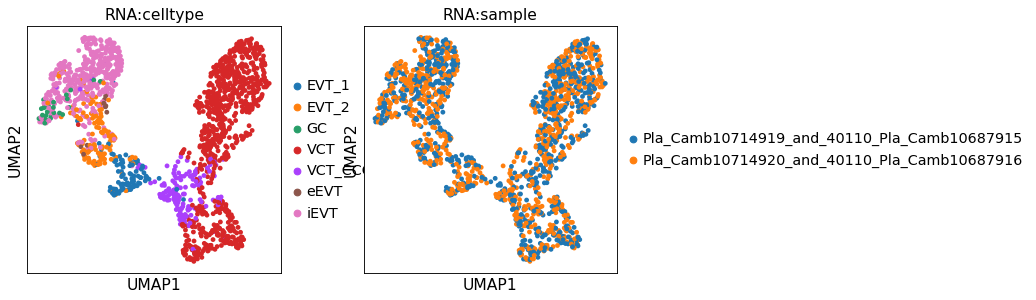

In [190]:
sc.pl.umap(mdata, color=["RNA:celltype", "RNA:sample"], ncols=2, 
           #save='_MOFA_based_UMAP_celltype_sample.pdf'
          )

In [14]:
# trying to plot factor weights for factors on top of this manifold..

# adding factor weights to the .obs of the object

for i in range(0,10):
    mdata.obs['X_mofa_Factor' + str(i+1)] = mdata.obsm['X_mofa'][:,i]

In [197]:
outdir

'/lustre/scratch117/cellgen/team292/aa22/with_Stijn/202111_snATAC-seq_data_MFI/multiome_ATAC_samples_analysis/trophoblast_only_analysis/downstream_analysis_custom_clust/out_MOFA_analysis/'

In [192]:
# remember this object
#mdata.write(outdir + 'adata_MEFISTO_final_20220128.h5ad')
mdata.write(outdir + 'adata_MEFISTO_with_VCT_20220210.h5mu')

In [5]:
# read in from file
mdata = mu.read(outdir + 'adata_MEFISTO_with_VCT_20220210.h5mu')

In [193]:
mdata

MuData object with n_obs × n_vars = 1605 × 15565
  obs:	'X_mofa_Factor1', 'X_mofa_Factor2', 'X_mofa_Factor3', 'X_mofa_Factor4', 'X_mofa_Factor5', 'X_mofa_Factor6', 'X_mofa_Factor7', 'X_mofa_Factor8', 'X_mofa_Factor9', 'X_mofa_Factor10'
  var:	'highly_variable', 'mean', 'std'
  obsm:	'X_mofa', 'X_umap', 'X_mofa_no_factor_5'
  varm:	'LFs'
  obsp:	'distances', 'connectivities', 'neighbors_no_factor_5_distances', 'neighbors_no_factor_5_connectivities'
  2 modalities
    ATAC_all:	1605 x 10640
      obs:	'cellatac_code', 'sample', 'barcode', 'donor', 'annot_multiome_combined', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'age', 'tissue', 'technology', 'celltype'
      var:	'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'contains_primed_enhancers', 'contains_active_enhancers', 'contains_repressed_enhancers', 'highly_variable', 'mean', 'std'
      uns:	'age_colors', 'annot_multiome_combined_colors', 'celltype_colors', 'donor_colors', 'neighbors', 'sample_colors', 'technology_colors', 'tissue_colors', 'umap'
      obsm:	'X_cistopic_50', 'X_umap'
      varm:	'peak2gene'
      layers:	'binary_raw'
      obsp:	'connectivities', 'distances'
    RNA:	1605 x 4925
      obs:	'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'barcode_sample_copy', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'annotation_prev', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'annotation_prev_or_removed', 'inv_troph_labels_initial', 'louvain_scvi_n_latent_8', 'final_annot_inv_troph', 'louvain_scvi_troph_rest', 'final_annot_all_troph', 'final_annot_inv_troph_corrected', 'final_annot_all_troph_corrected', 'technology', 'celltype', 'celltype_from_mdata'
      var:	'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'celltype_colors', 'donor_colors', 'final_annot_all_troph_corrected_colors', 'hvg', 'technology_colors'
      obsm:	'X_umap_scVI_n_latent_8_sample'

In [13]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

... storing 'ATAC_all:annotation' as categorical
... storing 'ATAC_all:gene_name' as categorical
... storing 'ATAC_all:gene_id' as categorical
... storing 'RNA:gene_ids-0' as categorical
... storing 'RNA:feature_types-0' as categorical
... storing 'RNA:genome-0' as categorical
... storing 'RNA:gene_ids-1' as categorical
... storing 'RNA:feature_types-1' as categorical
... storing 'RNA:genome-1' as categorical
... storing 'RNA:gene_ids-2' as categorical
... storing 'RNA:feature_types-2' as categorical
... storing 'RNA:genome-2' as categorical
... storing 'RNA:gene_ids-3' as categorical
... storing 'RNA:feature_types-3' as categorical
... storing 'RNA:genome-3' as categorical
... storing 'RNA:gene_ids-4' as categorical
... storing 'RNA:feature_types-4' as categorical
... storing 'RNA:genome-4' as categorical
... storing 'RNA:gene_ids-5' as categorical
... storing 'RNA:feature_types-5' as categorical
... storing 'RNA:genome-5' as categorical
... storing 'RNA:gene_ids-6' as categorical
...

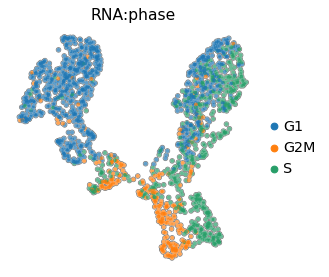

In [7]:
sc.set_figure_params(dpi_save=300)
sc.pl.umap(mdata, color=["RNA:phase"], #ncols=2, 
           frameon=False, add_outline=True, outline_width=(0.2, 0), outline_color=('grey','white'),
           size = 50,
           save='_MEFISTO_based_UMAP_cell_cycle_phase_no_factor_5_with_VCT.pdf'
          )

In [23]:
# getting more distinct colors for the zoomed in plot (donor P13 all troph)

colors_final = ['#EE2724', # EVT_1
                '#F58C74', # EVT_2
                '#726658', # GC
                '#81B2D3', # VCT
                '#88CDAF', # VCT_CCC
                '#21479E', # eEVT
                '#FEEC6E', # iEVT
               ]

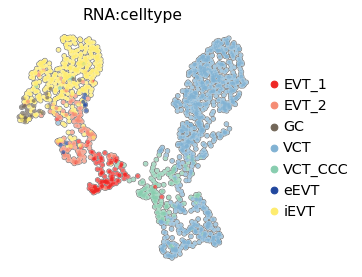

In [19]:
sc.set_figure_params(dpi_save=300)
sc.pl.umap(mdata, color=["RNA:celltype"], #ncols=2, 
           palette = colors_final,
           frameon=False, add_outline=True, outline_width=(0.2, 0), outline_color=('grey','white'),
           size = 50,
           save='_MEFISTO_based_UMAP_celltype_no_factor_5_with_VCT.pdf'
          )

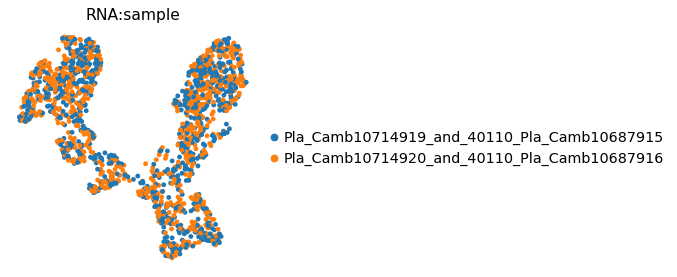

In [28]:
sc.pl.umap(mdata, color=["RNA:sample"], 
           #size=40,
           frameon=False,
           save='_MOFA_based_UMAP_celltype_sample.pdf'
          )

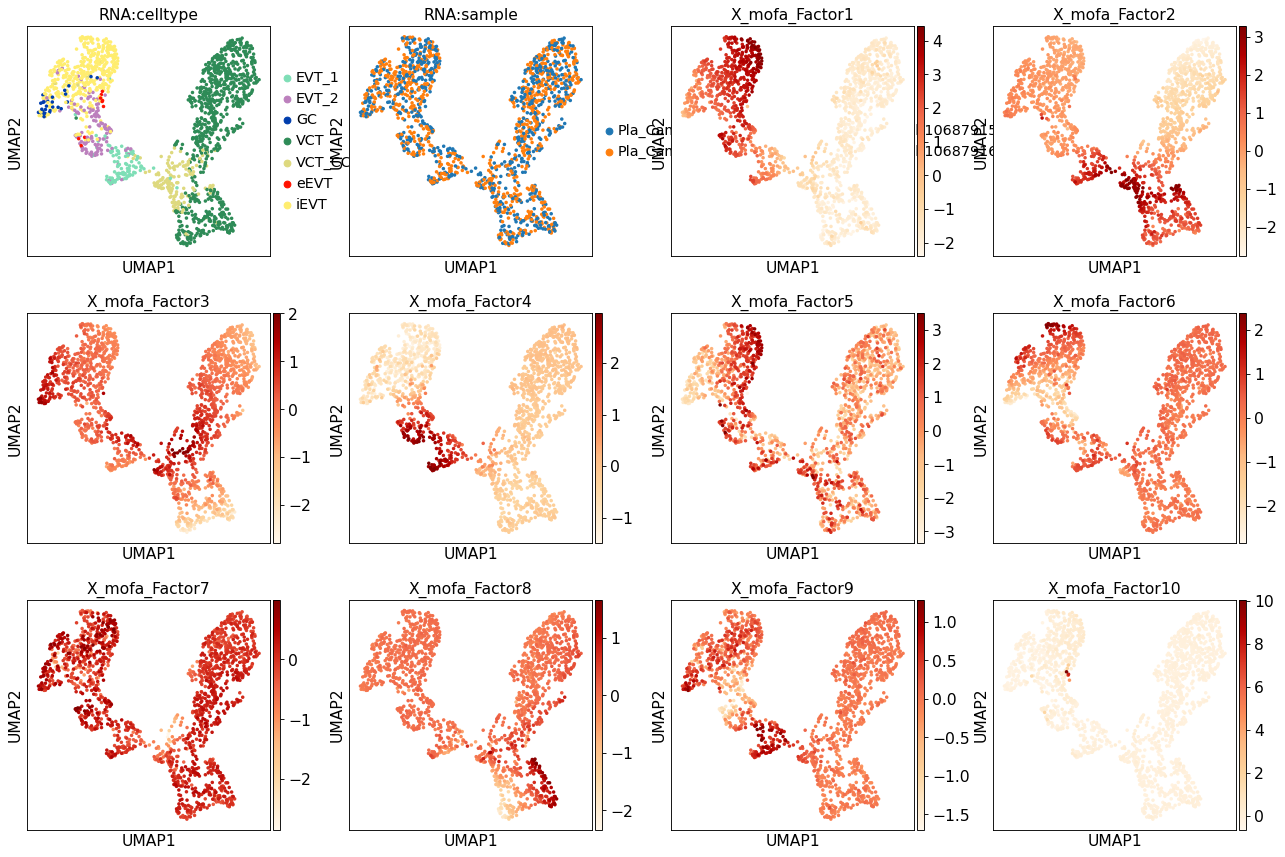

In [15]:
sc.pl.umap(mdata, color=["RNA:celltype", "RNA:sample"] + ['X_mofa_Factor' + str(i+1) for i in range(0,10)], #ncols=2, 
           size=40, cmap='OrRd'
           #save='_MOFA_based_UMAP_celltype_sample.pdf'
          )

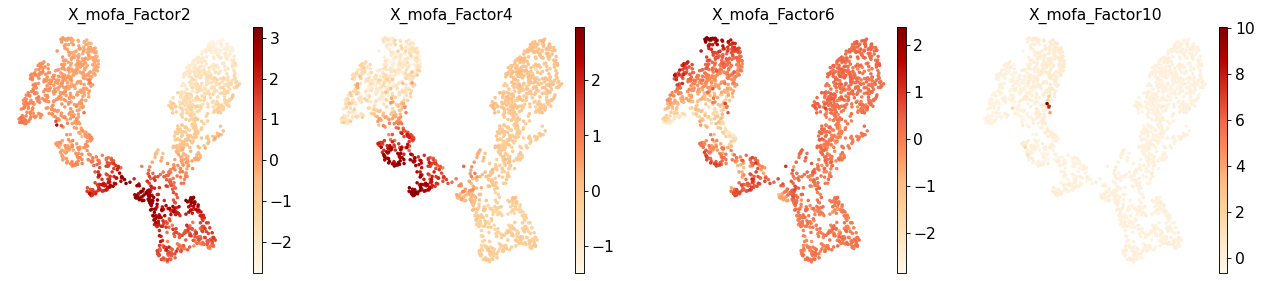

In [17]:
sc.pl.umap(mdata, color=['X_mofa_Factor' + str(i+1) for i in [1,3,5,9]], #+ ["RNA:celltype", "RNA:sample"], #ncols=2, 
           size=40, cmap='OrRd', frameon=False,
           save='_MOFA_based_UMAP_important_factors_with_VCT.pdf'
          )

In [65]:
mdata.uns['RNA:celltype_colors'] # original colors

['#7edeb6', '#bc80bd', '#003dad', '#ded97e', '#ff1200', '#ffed6f', '#7edeb6']

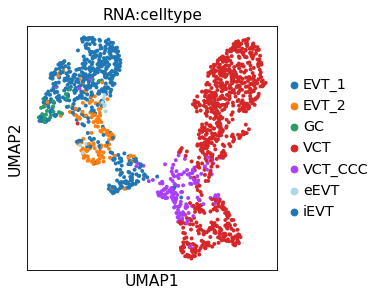

In [66]:
sc.pl.umap(mdata, color=["RNA:celltype", 
                         #"RNA:sample"] + ['X_mofa_Factor' + str(i+1) for i in range(0,10)
                        ], #ncols=2, 
           size=50, cmap='OrRd',
           palette = ['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', 'lightblue'],
           #save='_MOFA_based_UMAP_celltype_sample.pdf'
          )

<AxesSubplot:xlabel='Smoothness', ylabel='Factor'>

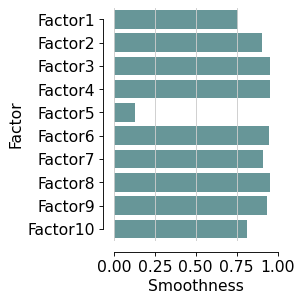

In [67]:
mfx.plot_smoothness(model)

In [22]:
rna_object_copy = sc.read(outdir + 'rna_object_copy_with_de_novo_UMAP_with_VCT_20220209.h5ad')

In [71]:
# trying to plot factor weights for factors 7 and 9 on top of this manifold..

# adding factor weights to the .obs of the object

for i in range(0,10):
    rna_object_copy.obs['X_mofa_Factor' + str(i+1)] = mdata.obsm['X_mofa'][:,i]

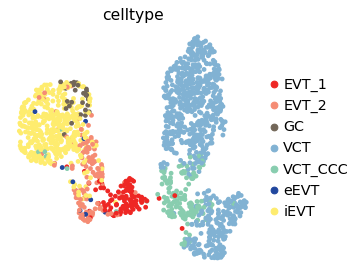

In [26]:
sc.pl.umap(rna_object_copy,
               color = ['celltype'], palette=colors_final, frameon=False,
               save = '_rna_multiome_manifold_P13_for_MEFISTO.pdf')

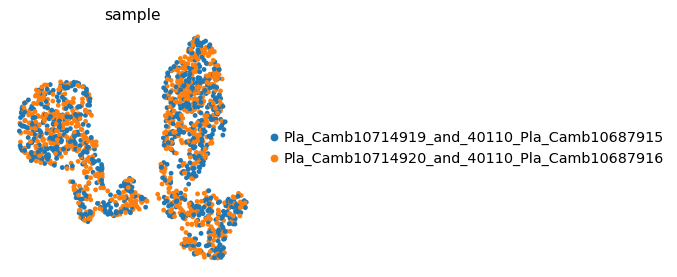

In [27]:
sc.pl.umap(rna_object_copy,
               color = ['sample'], frameon=False,
               save = '_rna_multiome_manifold_P13_for_MEFISTO_sample.pdf')

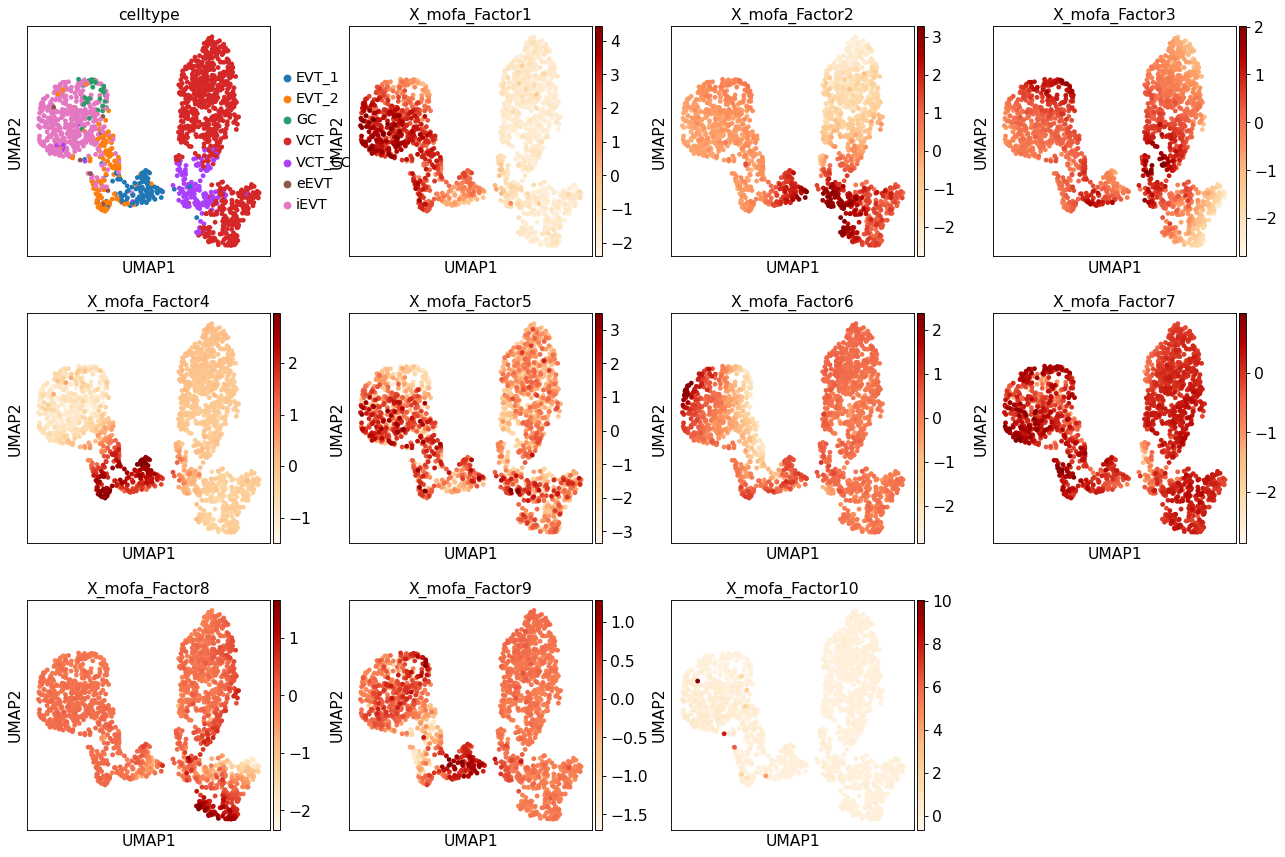

In [72]:
sc.pl.umap(rna_object_copy,
               color = ['celltype'] + ['X_mofa_Factor' + str(i+1) for i in range(0,10)],
               cmap='OrRd')

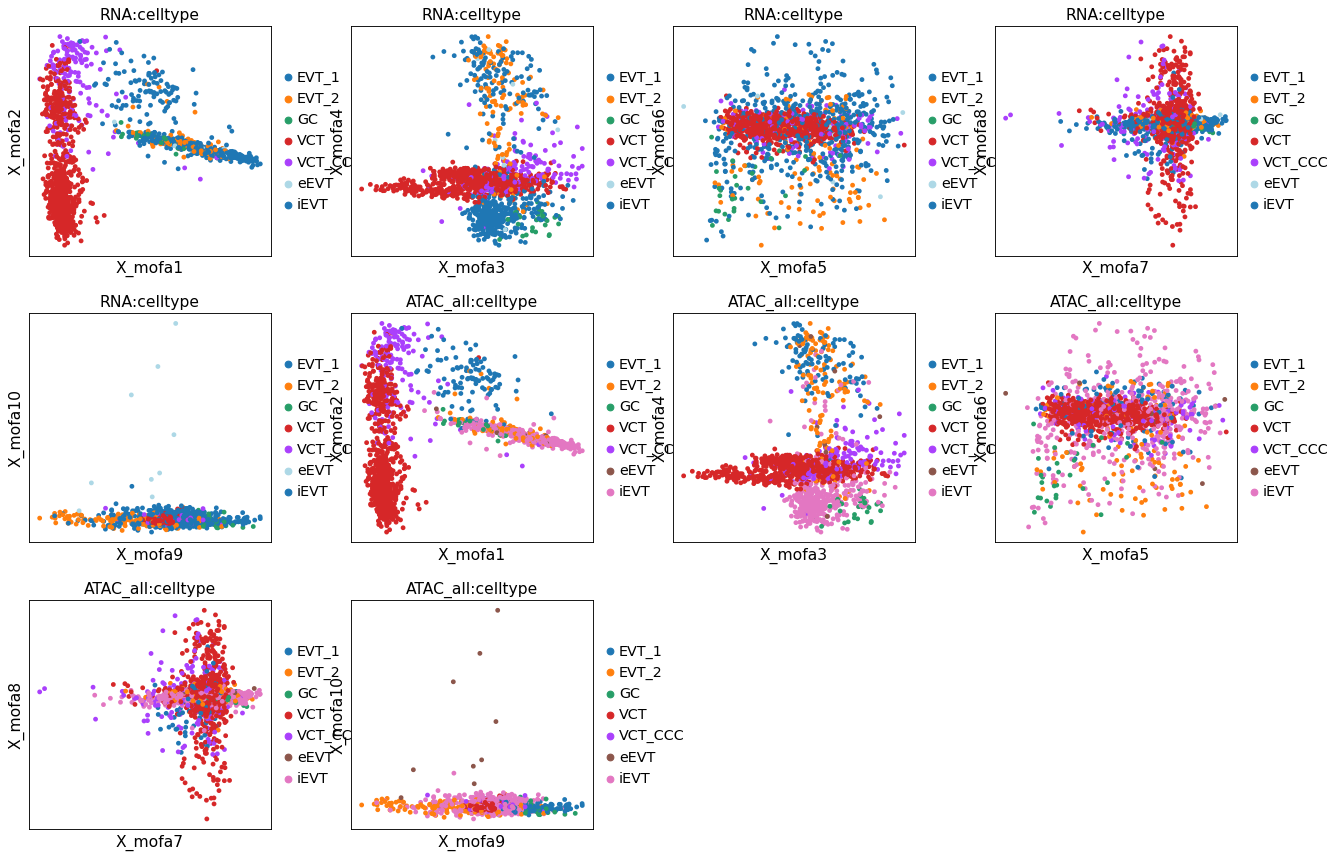

In [73]:
mu.pl.mofa(mdata, 
           color=["RNA:celltype", 
                  "ATAC_all:celltype"], components=["1,2", "3,4",'5,6','7,8','9,10'])

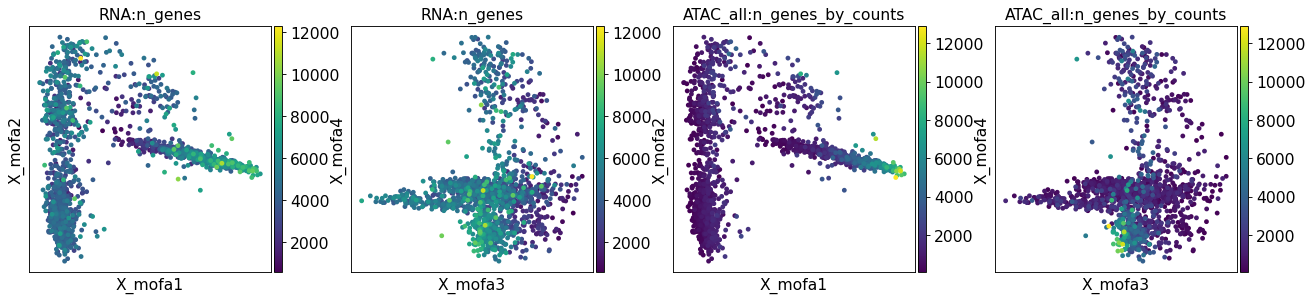

In [74]:
mu.pl.mofa(mdata, color=["RNA:n_genes", "ATAC_all:n_genes_by_counts"], components=["1,2", "3,4"])

### Interesting factors to explore: 

- 1 - VCT_CCC & cell cycle/general invasion explaining; 
- 3 - EVT_1 and EVT_2 explaining
- 4 - possibly GC explaining (& general invasion?)
- 7 - eEVT explaining

### Exploring RNA feature enrichment: using groups of genes

1. marker genes for eEVT for factor 7
2. marker genes for general invasion and GC for factor 4
3. marker genes for early invasive populations (VCT_CCC, EVT_1 and EVT_2) for factors 1 and 3
4. EMT related genes
5. other GO categories?

### Exploring ATAC feature enrichment: using groups of peaks

1. peaks that are primed/active/posied enhancers
2. peaks that belong to a certain annotation group (exon/intron/...)
3. DARs from chromVar workflow?

In [75]:
# do it here in a primitive way and do later properly with runEnrichmentAnalysis within MOFA

In [76]:
genes = {}

In [77]:
genes['eEVT_markers'] = pd.read_csv('/home/jovyan/notebooks/Vento_Lab/MFI_spatial/MFI_sc_sn_Integrated_analysis/new_scVI_analysis/CellPhone_analysis/limma_DEGs/20211123/20211123_eEVT_vs_EVT_2_limma_DEGs.csv',
                                   index_col=0)
genes['eEVT_markers'] = genes['eEVT_markers'][(genes['eEVT_markers']['adj.P.Val'] < 0.05) & (genes['eEVT_markers']['logFC'] > 0)]
genes['eEVT_markers'] = list(genes['eEVT_markers'].index)


In [78]:
genes['GC_markers'] = pd.read_csv('/home/jovyan/notebooks/Vento_Lab/MFI_spatial/MFI_sc_sn_Integrated_analysis/new_scVI_analysis/CellPhone_analysis/limma_DEGs/20211123/20211123_iEVT_vs_EVT_2_limma_DEGs.csv',
                                   index_col=0)
genes['GC_markers'] = genes['GC_markers'][(genes['GC_markers']['adj.P.Val'] < 0.05) & (genes['GC_markers']['logFC'] > 0)]
genes['GC_markers']
genes['GC_markers'] = list(genes['GC_markers'].index)


In [79]:
genes['EVT_1_markers'] = pd.read_csv('/home/jovyan/notebooks/Vento_Lab/MFI_spatial/MFI_sc_sn_Integrated_analysis/new_scVI_analysis/CellPhone_analysis/limma_DEGs/20211123/20211123_EVT_1_vs_VCT_CCC_limma_DEGs.csv',
                                   index_col=0)
genes['EVT_1_markers'] = genes['EVT_1_markers'][(genes['EVT_1_markers']['adj.P.Val'] < 0.05) & (genes['EVT_1_markers']['logFC'] > 0)]
genes['EVT_1_markers'] = list(genes['EVT_1_markers'].index)


In [80]:
genes['EVT_2_markers'] = pd.read_csv('/home/jovyan/notebooks/Vento_Lab/MFI_spatial/MFI_sc_sn_Integrated_analysis/new_scVI_analysis/CellPhone_analysis/limma_DEGs/20211123/20211123_EVT_2_vs_EVT_1_limma_DEGs.csv',
                                   index_col=0)
genes['EVT_2_markers'] = genes['EVT_2_markers'][(genes['EVT_2_markers']['adj.P.Val'] < 0.05) & (genes['EVT_2_markers']['logFC'] > 0)]
genes['EVT_2_markers'] = list(genes['EVT_2_markers'].index)


In [81]:
genes['VCT_CCC_markers'] = pd.read_csv('/home/jovyan/notebooks/Vento_Lab/MFI_spatial/MFI_sc_sn_Integrated_analysis/new_scVI_analysis/CellPhone_analysis/limma_DEGs/20211123/20211123_VCT_CCC_vs_VCT_limma_DEGs.csv',
                                   index_col=0)
genes['VCT_CCC_markers'] = genes['VCT_CCC_markers'][(genes['VCT_CCC_markers']['adj.P.Val'] < 0.05) & (genes['VCT_CCC_markers']['logFC'] > 0)]
genes['VCT_CCC_markers'] = list(genes['VCT_CCC_markers'].index)


In [82]:
# downloaded from: http://dbemt.bioinfo-minzhao.org/download.cgi, All the 1184 human Epithelial-Mesenchymal Transition genes in dbEMT 2.0.
genes['EMT_genes'] = pd.read_csv('./dbemt2.txt', sep='\t', index_col=1)

In [83]:
genes['EMT_genes']

GeneID                                              Alias  \
GeneSymbol                                                                 
TGFB1            7040                          CED|DPD1|LAP|TGFB|TGFbeta   
SNAI1            6615            SLUGH2|SNA|SNAH|SNAIL|SNAIL1|dJ710H13.1   
ZEB1             6935  AREB6|BZP|DELTAEF1|FECD6|NIL2A|PPCD3|TCF8|ZFHE...   
CDH1              999                     Arc-1|CD324|CDHE|ECAD|LCAM|UVO   
TWIST1           7291    ACS3|BPES2|BPES3|CRS|CRS1|CSO|SCS|TWIST|bHLHa38   
...               ...                                                ...   
PDCD6IP         10015                               AIP1|ALIX|DRIP4|HP95   
HDAC5           10014                                        HD5|NY-CO-9   
MIR124-2HG  100130155                                          LINC00966   
MIR875      100126309                                MIRN875|hsa-mir-875   
MIR888      100126306                                MIRN888|hsa-mir-888   

                                                        Links  Cytoband  \
GeneSymbol                                                                
TGFB1       MIM:190180|HGNC:HGNC:11766|Ensembl:ENSG0000010...   19q13.2   
SNAI1       MIM:604238|HGNC:HGNC:11128|Ensembl:ENSG0000012...  20q13.13   
ZEB1        MIM:189909|HGNC:HGNC:11642|Ensembl:ENSG0000014...  10p11.22   
CDH1        MIM:192090|HGNC:HGNC:1748|Ensembl:ENSG00000039...   16q22.1   
TWIST1      MIM:601622|HGNC:HGNC:12428|Ensembl:ENSG0000012...    7p21.1   
...                                                       ...       ...   
PDCD6IP     MIM:608074|HGNC:HGNC:8766|Ensembl:ENSG00000170...    3p22.3   
HDAC5       MIM:605315|HGNC:HGNC:14068|Ensembl:ENSG0000010...  17q21.31   
MIR124-2HG            HGNC:HGNC:48723|Ensembl:ENSG00000254377    8q12.3   
MIR875      HGNC:HGNC:33652|Ensembl:ENSG00000216069|miRBas...    8q22.2   
MIR888      HGNC:HGNC:33648|Ensembl:ENSG00000216005|miRBas...    Xq27.3   

                                               FullName        GeneType  
GeneSymbol                                                               
TGFB1                 transforming growth factor beta 1  protein-coding  
SNAI1          snail family transcriptional repressor 1  protein-coding  
ZEB1               zinc finger E-box binding homeobox 1  protein-coding  
CDH1                                         cadherin 1  protein-coding  
TWIST1         twist family bHLH transcription factor 1  protein-coding  
...                                                 ...             ...  
PDCD6IP     programmed cell death 6 interacting protein  protein-coding  
HDAC5                             histone deacetylase 5  protein-coding  
MIR124-2HG                           MIR124-2 host gene           ncRNA  
MIR875                                     microRNA 875           ncRNA  
MIR888                                     microRNA 888           ncRNA  

[1184 rows x 6 columns]

In [84]:
genes['EMT_genes']['GeneType'].value_counts()

protein-coding    1011
ncRNA              169
pseudo               4
Name: GeneType, dtype: int64

In [85]:
genes['EMT_genes'] = list(genes['EMT_genes'].index)

In [86]:
genes.keys()

dict_keys(['eEVT_markers', 'GC_markers', 'EVT_1_markers', 'EVT_2_markers', 'VCT_CCC_markers', 'EMT_genes'])

In [87]:
for group in list(genes.keys()):
    print(group)
    print('number of genes present in RNA features for MOFA/MEFISTO:', len(set(genes[group]) & set(RNA_weights.index)))


eEVT_markers
number of genes present in RNA features for MOFA/MEFISTO: 526
GC_markers
number of genes present in RNA features for MOFA/MEFISTO: 1099
EVT_1_markers
number of genes present in RNA features for MOFA/MEFISTO: 1194
EVT_2_markers
number of genes present in RNA features for MOFA/MEFISTO: 775
VCT_CCC_markers
number of genes present in RNA features for MOFA/MEFISTO: 1103
EMT_genes
number of genes present in RNA features for MOFA/MEFISTO: 325


In [88]:
RNA_weights.loc[list(set(genes['EMT_genes']) & set(RNA_weights.index))]

Factor1   Factor2   Factor3   Factor4   Factor5   Factor6   Factor7  \
ZEB1     0.069349  0.001913 -0.000763 -0.074441 -0.005403 -0.003538 -0.008378   
JUN     -0.019512  0.026119  0.011803 -0.005047 -0.004344  0.000509 -0.499787   
BMP7    -0.341083 -0.078244 -0.152882 -0.100051  0.163505 -0.031554 -0.019423   
NME1    -0.147417  0.165999  0.126618 -0.003328  0.133308 -0.044607  0.026306   
CD14    -0.000225  0.003037  0.106180 -0.001854  0.000512 -0.005591 -0.001903   
...           ...       ...       ...       ...       ...       ...       ...   
SOX5    -0.000055 -0.000502  0.002458  0.001951 -0.000046  0.005210  0.001209   
SOD2    -0.002389  0.062101 -0.000367 -0.045786 -0.000247 -0.114511 -0.009996   
RPL22L1 -0.049711  0.106068  0.056254  0.064449  0.053980 -0.107254  0.012253   
IMP3    -0.038239  0.061821 -0.003988  0.006360  0.036323 -0.162668  0.001986   
NOTCH2   0.374753  0.012152  0.001600 -0.199546 -0.115472 -0.022594 -0.008488   

          Factor8   Factor9  Factor10  
ZEB1    -0.001515  0.010792  0.036287  
JUN      0.004301 -0.012501  0.027368  
BMP7    -0.002532 -0.008290 -0.000857  
NME1    -0.001493  0.146495  0.012821  
CD14    -0.092626 -0.000335 -0.013755  
...           ...       ...       ...  
SOX5    -0.052648 -0.001987 -0.012024  
SOD2     0.011711  0.024931  0.001638  
RPL22L1  0.129773  0.076487  0.000112  
IMP3    -0.030493  0.034983  0.023470  
NOTCH2   0.003206  0.008661  0.191210  

[325 rows x 10 columns]

In [89]:
RNA_weights[RNA_weights['Factor8'] > np.quantile(RNA_weights['Factor8'], 0.99)]

Factor1   Factor2   Factor3   Factor4   Factor5   Factor6  \
ABHD3    -0.101140  0.088665 -0.430663  0.000014  0.013626 -0.009204   
ADCY3    -0.072389  0.247709 -0.105454  0.014221  0.068902 -0.006488   
ASAP2    -0.102554  0.142656 -0.178861 -0.095286  0.002018  0.000508   
ATAD2    -0.186427  0.425775 -0.379639  0.012397  0.058490  0.018648   
B4GALT6  -0.096305  0.074826 -0.174037 -0.031297  0.060216 -0.007106   
BICDL1   -0.045284  0.120567 -0.373553 -0.022353 -0.016066 -0.084192   
C11orf80 -0.017485  0.108394 -0.290617 -0.099333 -0.003000  0.012999   
CCNE2    -0.064270  0.256309 -0.375632 -0.021100 -0.047791 -0.005017   
CDC45    -0.092591  0.219519 -0.263004  0.002456  0.022182 -0.011292   
CDC6     -0.104663  0.264722 -0.333940 -0.006491 -0.001010 -0.003925   
CHAF1B   -0.069394  0.224912 -0.180528 -0.000088  0.021003  0.003279   
CLSPN    -0.100675  0.330721 -0.364765  0.005118  0.001651 -0.002989   
DMC1     -0.036813  0.152788 -0.196998 -0.088082  0.001985  0.014190   
DSCC1    -0.098517  0.270539 -0.236250 -0.039653  0.004285 -0.008194   
DTL      -0.174746  0.338673 -0.393326 -0.008179  0.022729 -0.001053   
E2F1     -0.119370  0.196518 -0.141087 -0.022721  0.059361 -0.000968   
E2F7     -0.106882  0.345646 -0.461885 -0.009667  0.008061 -0.004407   
FAM111B  -0.065376  0.171646 -0.332133 -0.073172 -0.003650 -0.061201   
FKBP5    -0.047654  0.126252 -0.191837 -0.036726  0.001039 -0.002543   
FZD3     -0.103584  0.084507 -0.069359 -0.013876  0.087809 -0.068667   
HELLS    -0.257044  0.303904 -0.439994  0.003155  0.077741  0.001975   
KANK2    -0.002149  0.072752 -0.210905 -0.012501 -0.013665 -0.113653   
KIAA1958 -0.089893  0.190775 -0.182829 -0.066186  0.041510 -0.001823   
LAMA1    -0.163726  0.254933  0.079670 -0.071111  0.132424  0.002089   
MCM10    -0.145994  0.383723 -0.262350  0.001434  0.076411 -0.002400   
MCM6     -0.167480  0.152693 -0.055780  0.004444  0.032589  0.010249   
MFHAS1   -0.098484  0.186810 -0.217960 -0.075431  0.000495  0.002533   
MMS22L   -0.200284  0.294972 -0.467169 -0.040806  0.068569  0.003161   
NETO2    -0.040992  0.075570 -0.225791 -0.008211 -0.002362 -0.002663   
NPAS2    -0.101714  0.093012  0.000131  0.107173  0.052641 -0.001019   
NUP210   -0.233590  0.216408 -0.188349 -0.105679  0.077219 -0.003510   
PBX3     -0.065809  0.259697 -0.288750  0.000292 -0.004979 -0.056350   
POLA1    -0.197875  0.173800 -0.470088 -0.055329  0.083307  0.085438   
POLE     -0.123538  0.305778 -0.241926  0.078087  0.036234  0.016223   
RNF144A  -0.086309  0.103778 -0.363183 -0.078013  0.003395  0.003551   
SDK1     -0.037942  0.179094 -0.302156 -0.193534  0.002892  0.116185   
SIPA1L2   0.000448  0.127295 -0.012454  0.334250  0.013034 -0.030491   
SLC16A10 -0.108432  0.189164 -0.166932 -0.081695  0.047417 -0.002556   
SLC1A4   -0.070693  0.187263 -0.191504 -0.048881 -0.000465 -0.006256   
SLC25A29 -0.132301  0.051650 -0.140875 -0.079827  0.066531 -0.017211   
SOBP     -0.060972  0.134652 -0.033407 -0.064064  0.032084 -0.015777   
STOX1    -0.069965  0.133702 -0.276511 -0.073457 -0.005638 -0.016843   
STOX2    -0.102805 -0.059157 -0.410895  0.084707 -0.003202 -0.003678   
TMEM131L -0.092474  0.095255 -0.090550 -0.070553  0.021167 -0.007233   
TTC13    -0.124067  0.020881 -0.201476 -0.024608  0.053303 -0.005414   
TXNDC16  -0.081106  0.083829 -0.137683 -0.068062  0.049597  0.000311   
UHRF1    -0.080683  0.231684 -0.210959 -0.027352 -0.002689 -0.006745   
WDHD1    -0.155135  0.268576 -0.371948  0.013715  0.065125  0.014924   
WDR76    -0.154413  0.298678 -0.363496 -0.059287  0.017409 -0.000702   
ZNF367   -0.110731  0.290763 -0.246649  0.015676  0.005036  0.005848   

           Factor7   Factor8   Factor9  Factor10  
ABHD3     0.052512  0.400078 -0.035257  0.003489  
ADCY3     0.010163  0.436919  0.029971 -0.004846  
ASAP2    -0.185884  0.477994 -0.143780  0.026111  
ATAD2    -0.131843  0.385862  0.015494  0.003685  
B4GALT6  -0.043330  0.372917 -0.007875  0.001833  
BICDL1   -0.006507  0.577049 -0.

/opt/conda/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


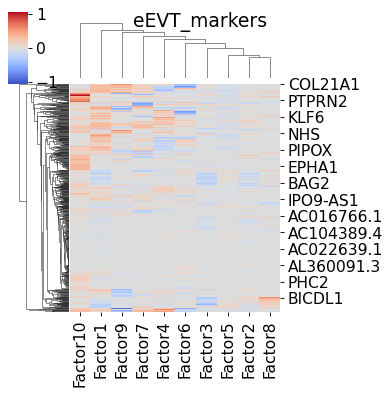

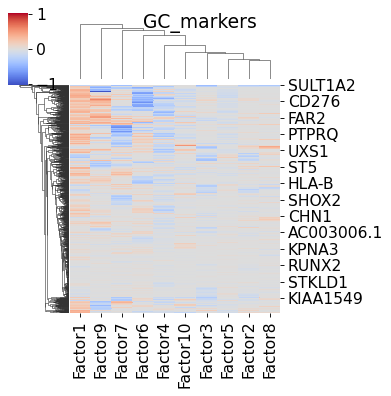

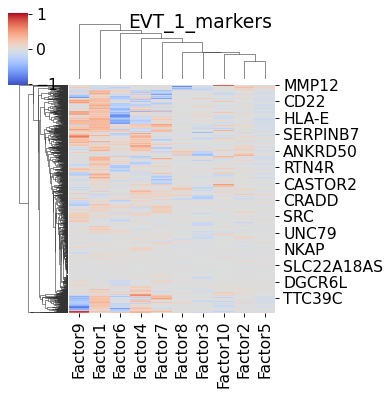

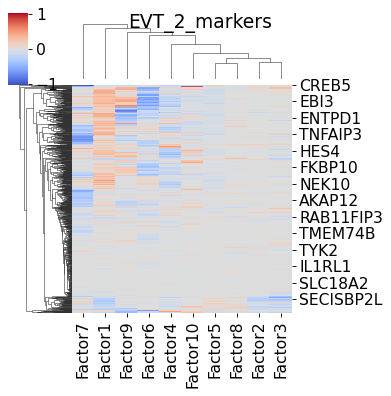

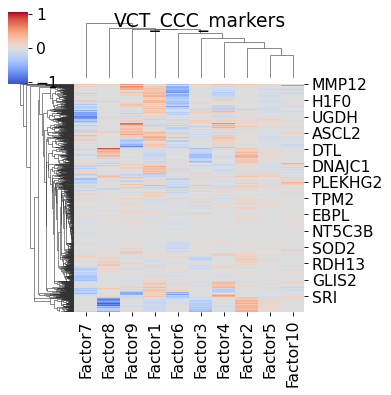

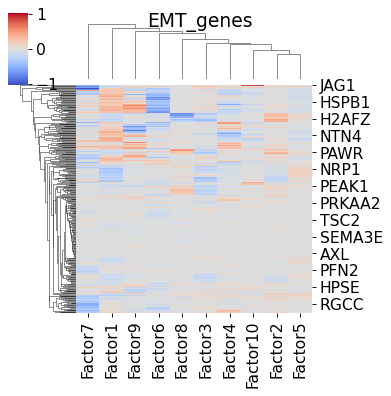

In [90]:
for group in list(genes.keys()):
    #print(group)
    curr_table = RNA_weights.loc[list(set(genes[group]) & set(RNA_weights.index))]
    curr_color_limit = max( abs(np.max(curr_table.values)), abs(np.min(curr_table.values)) )
    
    sns.clustermap(curr_table, cmap='coolwarm', vmax=curr_color_limit, vmin = -curr_color_limit,
                  figsize=(5,5)).fig.suptitle(group) 

# preliminary takeaway from the gene enrichment:

Factors 1,7,9: general invasion, EMT, GC

Factor 10: eEVT

In [91]:
mdata['ATAC_all'].var

peak_width  exon  gene  promoter  annotation  \
peak_id                                                                  
chr1:904345-904907               563     0     0         0  intergenic   
chr1:938156-938411               256     0     1         1    promoter   
chr1:959000-959712               713     1     1         1        exon   
chr1:966208-966555               348     1     1         1        exon   
chr1:966847-967127               281     0     1         0      intron   
...                              ...   ...   ...       ...         ...   
chrX:154805785-154806070         286     0     1         1    promoter   
chrX:155026470-155027451         982     1     1         1        exon   
chrX:155070780-155071828        1049     1     1         1        exon   
chrX:155215852-155216966        1115     1     1         1        exon   
chrX:155880939-155881650         712     1     1         1        exon   

                         gene_name          gene_id  tss_distance  \
peak_id                                                             
chr1:904345-904907             nan              nan         19020   
chr1:938156-938411          SAMD11  ENSG00000187634           863   
chr1:959000-959712          KLHL17  ENSG00000187961             0   
chr1:966208-966555         PLEKHN1  ENSG00000187583             0   
chr1:966847-967127         PLEKHN1  ENSG00000187583           344   
...                            ...              ...           ...   
chrX:154805785-154806070      MPP1  ENSG00000130830           257   
chrX:155026470-155027451    FUNDC2  ENSG00000165775             0   
chrX:155070780-155071828     BRCC3  ENSG00000185515             0   
chrX:155215852-155216966      VBP1  ENSG00000155959             0   
chrX:155880939-155881650     VAMP7  ENSG00000124333             0   

                          ENCODE_blacklist  n_cells_by_counts  mean_counts  \
peak_id                                                                      
chr1:904345-904907                       0                147     0.019650   
chr1:938156-938411                       0                 50     0.006684   
chr1:959000-959712                       0                273     0.036492   
chr1:966208-966555                       0                 97     0.012966   
chr1:966847-967127                       0                104     0.013902   
...                                    ...                ...          ...   
chrX:154805785-154806070                 0                120     0.016041   
chrX:155026470-155027451                 0                431     0.057613   
chrX:155070780-155071828                 0                483     0.064564   
chrX:155215852-155216966                 0                203     0.027135   
chrX:155880939-155881650                 0                214     0.028606   

                          log1p_mean_counts  pct_dropout_by_counts  \
peak_id                                                              
chr1:904345-904907                 0.019459              98.035022   
chr1:938156-938411                 0.006661              99.331640   
chr1:959000-959712                 0.035842              96.350755   
chr1:966208-966555                 0.012883              98.703382   
chr1:966847-967127                 0.013806              98.609812   
...                                     ...                    ...   
chrX:154805785-154806070           0.015913              98.395936   
chrX:155026470-155027451           0.056014              94.238738   
chrX:155070780-155071828           0.062565              93.543644   
chrX:155215852-155216966           0.026774              97.286459   
chrX:155880939-155881650           0.028204              97.139420   

                          total_counts  log1p_total_counts  \
peak_id                                                      
chr1:904345-904907               147.0            4.997212   
chr1:938156-938411                50.0            3.9

In [92]:
mdata['ATAC_all'].var['annotation'].value_counts()

intergenic    14832
exon          13140
intron        12496
promoter       2090
Name: annotation, dtype: int64

In [93]:
peaks = {}

In [94]:
mdata['ATAC_all']#[mdata['ATAC_all'].var['annotation'] == 'exon']

AnnData object with n_obs × n_vars = 1605 × 42558
    obs: 'cellatac_code', 'sample', 'barcode', 'donor', 'annot_multiome_combined', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'age', 'tissue', 'technology', 'celltype'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'contains_primed_enhancers', 'contains_active_enhancers', 'contains_repressed_enhancers', 'highly_variable'
    uns: 'age_colors', 'annot_multiome_combined_colors', 'celltype_colors', 'donor_colors', 'neighbors', 'sample_colors', 'technology_colors', 'tissue_colors', 'umap'
    obsm: 'X_cistopic_50', 'X_umap'
    varm: 'peak2gene'
    layers: 'binary_raw'
    obsp: 'co

In [95]:
peaks['exon'] = list(mdata['ATAC_all'].var[mdata['ATAC_all'].var['annotation'] == 'exon'].index)
peaks['intergenic'] = list(mdata['ATAC_all'].var[mdata['ATAC_all'].var['annotation'] == 'intergenic'].index)
peaks['intron'] = list(mdata['ATAC_all'].var[mdata['ATAC_all'].var['annotation'] == 'intron'].index)
peaks['promoter'] = list(mdata['ATAC_all'].var[mdata['ATAC_all'].var['annotation'] == 'promoter'].index)

In [96]:
peaks['primed_enhancers'] = list(mdata['ATAC_all'].var[mdata['ATAC_all'].var['contains_primed_enhancers'] == 1].index)
peaks['active_enhancers'] = list(mdata['ATAC_all'].var[mdata['ATAC_all'].var['contains_active_enhancers'] == 1].index)
peaks['repressed_enhancers'] = list(mdata['ATAC_all'].var[mdata['ATAC_all'].var['contains_repressed_enhancers'] == 1].index)

# to do: add conserved 2nd & 3rd trimester enhancers

In [97]:
for group in list(peaks.keys()):
    print(group)
    print('number of peaks present in ATAC features for MOFA/MEFISTO:', len(set(peaks[group]) & set(ATAC_weights['ATAC_all'].index)))


exon
number of peaks present in ATAC features for MOFA/MEFISTO: 5387
intergenic
number of peaks present in ATAC features for MOFA/MEFISTO: 2772
intron
number of peaks present in ATAC features for MOFA/MEFISTO: 2084
promoter
number of peaks present in ATAC features for MOFA/MEFISTO: 397
primed_enhancers
number of peaks present in ATAC features for MOFA/MEFISTO: 2037
active_enhancers
number of peaks present in ATAC features for MOFA/MEFISTO: 6821
repressed_enhancers
number of peaks present in ATAC features for MOFA/MEFISTO: 2084


In [98]:
ATAC_weights['ATAC_all']

Factor1   Factor2   Factor3   Factor4   Factor5  \
chr1:999901-1000393       0.021972 -0.002206  0.006699  0.014004  0.095256   
chr1:1019192-1019792      0.022885 -0.000070 -0.001551  0.014184  0.126844   
chr1:1073233-1074498      0.076824  0.062108  0.026969  0.046422  0.104564   
chr1:1079363-1080404      0.075861  0.009298 -0.008317  0.012773  0.110339   
chr1:1115778-1116666      0.001281  0.009092 -0.012297  0.018624  0.156804   
...                            ...       ...       ...       ...       ...   
chrX:154719165-154719708  0.069933 -0.002228 -0.005659  0.001297  0.000017   
chrX:154805075-154805684 -0.036522 -0.004526 -0.001615  0.000196  0.019909   
chrX:154805785-154806070 -0.004101 -0.001407 -0.002678 -0.003022  0.034212   
chrX:155026470-155027451  0.017082 -0.000172  0.040572 -0.000223  0.142277   
chrX:155070780-155071828 -0.000610 -0.010886 -0.007174  0.000359  0.137544   

                           Factor6   Factor7   Factor8   Factor9  Factor10  
chr1:999901-1000393      -0.006901 -0.001335  0.003311 -0.014631 -0.013661  
chr1:1019192-1019792     -0.002182  0.030693 -0.004817  0.010640 -0.032377  
chr1:1073233-1074498      0.009809 -0.043817 -0.016851 -0.006142  0.001124  
chr1:1079363-1080404     -0.013114 -0.002638  0.004088 -0.014389  0.050362  
chr1:1115778-1116666     -0.004518  0.015393 -0.010867 -0.007142  0.007841  
...                            ...       ...       ...       ...       ...  
chrX:154719165-154719708 -0.018895  0.004122 -0.005270  0.008012  0.042709  
chrX:154805075-154805684 -0.001888  0.008267  0.004334  0.002819  0.108959  
chrX:154805785-154806070  0.001963  0.020829 -0.011322 -0.004830  0.106529  
chrX:155026470-155027451 -0.001065 -0.029132 -0.000444  0.003345 -0.013232  
chrX:155070780-155071828 -0.009297  0.040064  0.008945  0.011079  0.004114  

[10640 rows x 10 columns]

/opt/conda/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


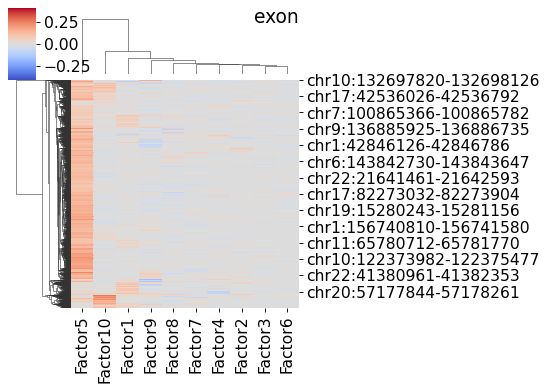

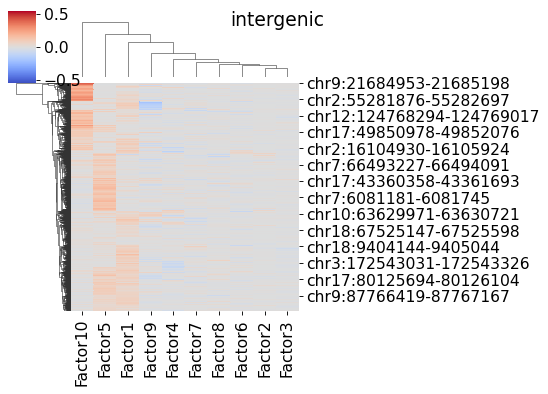

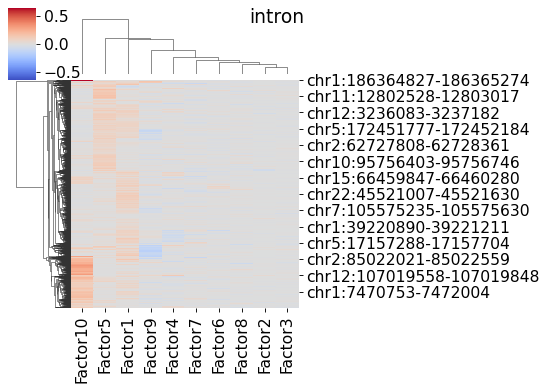

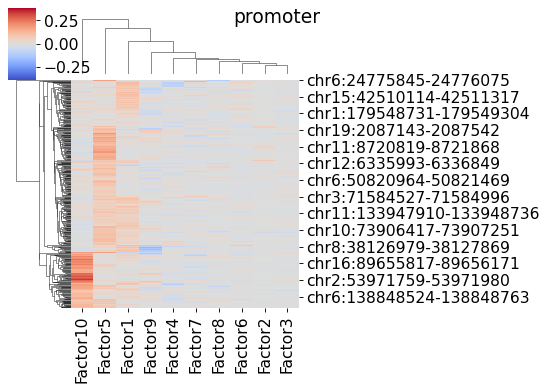

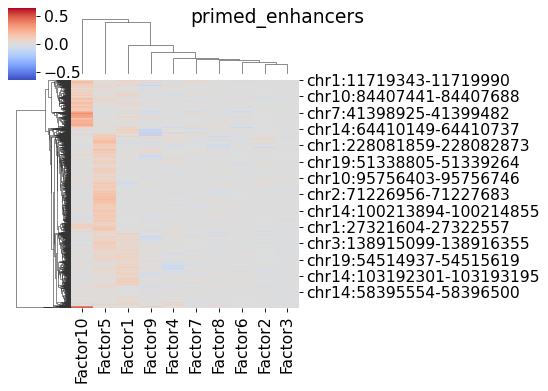

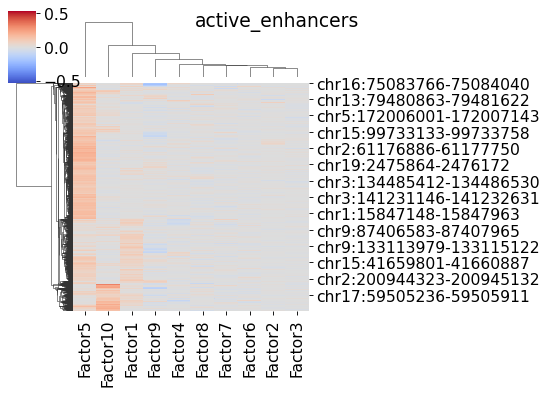

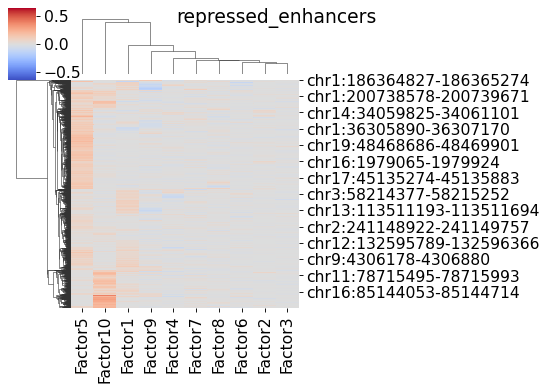

In [99]:
for group in list(peaks.keys()):
    #print(group)
    curr_table = ATAC_weights['ATAC_all'].loc[list(set(peaks[group]) & set(ATAC_weights['ATAC_all'].index))]
    curr_color_limit = max( abs(np.max(curr_table.values)), abs(np.min(curr_table.values)) )
    
    sns.clustermap(curr_table, cmap='coolwarm', vmax=curr_color_limit, vmin = -curr_color_limit,
                  figsize=(7,5)).fig.suptitle(group) 

# preliminary takeaway from the peak enrichment:

Factor 10: (eEVT-driven) seems to be enriched in peaks with enhancers (all types), promoters and intron/intergenic regions - this may indicate very active chromatin remodelling state! 

## Then I proceed to notebook `S2` to test enrichment properly with MEFISTO functions